<img src="files/logo.jpg"/>

## はじめに

このOptunaのチュートリアルは、Google Colaboratry で書かれたノートブックに沿って進めます。Google Colaboratry ではブラウザ上で Python プログラムを実行することができます。

試しに以下のコードを実行してみましょう。

In [2]:
print('Hello Notebook!')  # shift + enter で実行できます

Hello Notebook!


Optunaは、次のようにインストールできます。

In [20]:
!pip install optuna


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## 1. Optuna を使って目的関数を最小化する

まずは簡単な二次関数の最小化問題を考えてみましょう。
$(x - 2) ^ 2$ が最小となる $x$ を求める問題です。
$(x - 2) ^ 2$ のような最小化対象の関数を**目的関数** ***(objective function)*** と呼びます。
以下のコードを実行して目的関数を定義してみましょう。

In [3]:
def objective(x):
    return (x - 2) ** 2

人間は $x = 2$ の時に最小値が0であると解りますが、Optuna はこの問題の解き方を知りません。
そこで実際に複数の $x$ を代入して出力を計算し、出力が最小となった $x$ が最も良い解であると判断します。
以下のような計算をするイメージです。

In [4]:
import random

outputs = []  # 計算結果を保存しておくリスト

# 区間　[-100, 100]　から適当な x を 100 パターン試す
for _ in range(100):
    x = random.uniform(-100, 100)
    objective_value = objective(x)
    outputs.append(objective_value)

minimum_output = min(outputs)
print(f'目的関数の最小値: {minimum_output}')

目的関数の最小値: 2.0011392650963353


上記の例ではランダムな $x$ を 100 個試していますが、Optuna はこれまでに試した入力 $x$ と出力 $(x - 2) ^ 2$ からヒントを得ることで、より良い結果が得られそうな $x$ に当たりをつけていきます。

Optuna を使って $(x - 2) ^ 2$ を最小化する $x$ を求めてみましょう。
以下の 4 つのステップが必要となります。

1.   目的関数を定義する
2.   目的関数の内部で適当な変数を決める ***(suggest)***
3.   実験 ***study*** オブジェクトを作成する。
4.   施行 ***(trial)*** の回数を設定して最適化を開始する ***(optimize)***

目的関数を定義します。
先ほど定義した目的関数とは少し違っており、$x$ の代わりに ***trial*** オブジェクトを引数としています。
これは Optuna で目的関数を書くときの決まりごとです。
***trial*** オブジェクトの ***suggest_float*** メソッド実行したタイミングで、次に試すべき $x$ の値が提案 ***(suggest)*** されます。
提案された $x$ を使って関数からの出力 $(x - 2) ^ 2$ を計算します。

In [2]:
import optuna
def objective(trial):                                           # 目的関数の定義
    x = trial.suggest_float("x", -100, 100)  # 区間　[-100, 100]　から適当な x を決める
    return (x - 2) ** 2                                          # 目的関数の計算結果を返す

この目的関数を最小化する $x$ を求めることが Optuna の役目です。
以下のコードを実行してみましょう。
実験 ***(study)*** のオブジェクトを作成し、***optimize*** メソッドに目的関数と施行の回数を与えることで最小化実験が始まります。

In [6]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2023-03-06 21:18:16,921] A new study created in memory with name: no-name-53986c6e-9292-4628-b438-2d2a46fa32a4
[I 2023-03-06 21:18:16,925] Trial 0 finished with value: 84.728191378443 and parameters: {'x': 11.20479176181857}. Best is trial 0 with value: 84.728191378443.
[I 2023-03-06 21:18:16,926] Trial 1 finished with value: 9679.77161717759 and parameters: {'x': -96.38583036788168}. Best is trial 0 with value: 84.728191378443.
[I 2023-03-06 21:18:16,927] Trial 2 finished with value: 1265.0292511346515 and parameters: {'x': -33.567249698769956}. Best is trial 0 with value: 84.728191378443.
[I 2023-03-06 21:18:16,927] Trial 3 finished with value: 8231.624421576436 and parameters: {'x': -88.72830000378292}. Best is trial 0 with value: 84.728191378443.
[I 2023-03-06 21:18:16,928] Trial 4 finished with value: 5771.2393803444165 and parameters: {'x': 77.9686736776707}. Best is trial 0 with value: 84.728191378443.
[I 2023-03-06 21:18:16,929] Trial 5 finished with value: 6622.009835036876

100 行のログが出力されているはずです。
Optuna が $(x - 2) ^ 2$ を 100 回実行し、そのつど異なる $x$ を試したことを意味しています。

実験結果を見てみましょう。
***study.best_value*** で 100 試行中の最小となる出力 $(x - 2) ^ 2$ の値が、***study.best_params*** でその時の入力 $x$ がわかります。

In [7]:
print(f"目的関数の最小値: {study.best_value}")
print(f"出力が最小となる入力: {study.best_params}")

目的関数の最小値: 0.006023015079880227
出力が最小となる入力: {'x': 2.0776080864335684}


## 2. MNIST (手書き文字認識)

このチュートリアルでは例として、MNISTというデータセットと簡単なニューラルネットワークを使って手書き文字認識を行います。


MNISTには、次のような手書き文字が28x28の画像として訓練用60000枚 + 評価用10000枚収められています。

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png" width="500"/>

(画像: https://ja.wikipedia.org/wiki/MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%83%99%E3%83%BC%E3%82%B9#/media/%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB:MnistExamples.png)

以下のプログラムを実行すると、自動的にデータセットがダウンロードされます。

In [7]:
import torch
from torchvision.datasets import MNIST

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # あればGPUを使う

# データを読み込む (今回はデータが少ないので、全てメモリ上に入れる)
# 訓練用データセット
train = MNIST(root='./data', download=True, train=True)
train_X = train.data.to(device).to(torch.float32) # 60000x28x28
train_y = train.targets.to(device) # 60000

# 評価用データセット
validation = MNIST(root='./data', download=True, train=False)
validation_X = validation.data.to(device).to(torch.float32) # 10000x28x28
validation_y = validation.targets.to(device) # 10000

これらの画像を認識するために、今回は非常に単純な2層ニューラルネットワークを使って学習を行います。

<img src="https://upload.wikimedia.org/wikipedia/commons/c/c2/MultiLayerNeuralNetworkBigger_english.png" width="400">

(画像: https://simple.wikipedia.org/wiki/Deep_learning#/media/File:MultiLayerNeuralNetworkBigger_english.png)

今回は入力層(input layer)のサイズは画像サイズ28×28=768, 出力層(output layer)のサイズは0~9の文字に対応する10個です。中間層(hidden layer)のサイズと、中間層でかける活性化関数はうまく学習ができるように調整する必要があります。

深層学習フレームワークPyTorchを使うと、このモデルは次のように簡単に書けます。

In [4]:
import torch.nn as nn

# モデルの定義
hidden_dim = 30            # 中間層の次元数
activation = nn.Sigmoid()  # 活性化関数

model = nn.Sequential(
    nn.Flatten(),                  # 二次元の画像を一次元に変換
    nn.Linear(28*28, hidden_dim),  # 入力層から中間層への線形変換
    activation,                    # 活性化関数
    nn.Linear(hidden_dim, 10),     # 中間層から出力層への線形変換
).to(device)


今はとりあえず中間層のサイズは30, 活性化関数はSigmoidを使っておきました。

データセットがあってモデルを立てたら、次にどのようにそのモデルのパラメタ(ハイパーパラメータではなく、モデル内の`nn.Linear`の重みなどのことです)を最適化するかを決めなければなりません。
今回は最も基本的な最適化アルゴリズムである確率的勾配降下法(Stochastic gradient descent; SGD)を使うことにします。

In [3]:
import torch.optim as optim

# 最適化アルゴリズムの定義
lr = 1e-3  # 学習率
momentum = 0.9  # モーメンタム
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

モデルだけではなく最適化アルゴリズムにもハイパーパラメータはつきもので、学習率(`lr`)やモーメンタム(`momentum`)などをいい感じに調整する必要があります。

さて、今定義したモデルと最適化アルゴリズムを用いてモデルを訓練するコードは次のように書けます。以後何度もこのコードを使うので、モデルと最適化アルゴリズムを渡すとMNISTのデータで訓練と評価を行ってくれる関数を作ります。

In [5]:
def fit_mnist_and_evaluate(model, optimizer):

    # 損失関数の定義
    loss_func = nn.CrossEntropyLoss() 

    # 学習 (今回はepoch数は20で固定とします。)
    epochs = 20
    for epoch in range(epochs):
        
        loss_sum = 0.0
        
        # batchをシャッフルする (今回はbatch sizeは600で固定とします。)
        batch_size = 600
        batch_idxs = torch.randperm(len(train_X), device=device).view(-1, batch_size)

        for i, batch in enumerate(batch_idxs):
            # 各batchについて最適化を回す

            optimizer.zero_grad() # 微分係数の初期化
            outputs = model(train_X[batch])          # 予測
            loss = loss_func(outputs, train_y[batch]) # 損失関数の計算 
            loss.backward()  # 微分の計算
            optimizer.step() # 最適化の1ステップの計算 

            loss_sum += loss.item()

        train_loss = loss_sum / (i + 1) # batchごとの損失関数の平均をとる

        # 評価
        with torch.no_grad():
            outputs = model(validation_X)
            _, predicted = torch.max(outputs.data, dim=1) # 最も予測値が高かったものをとる
            total = len(validation_X)
            correct = (predicted == validation_y).sum().item()
            validation_accuracy = correct / total

        print(f"Epoch {epoch + 1}: train_loss={train_loss:.3f}, validation_accuracy={validation_accuracy:.4f}")

    return validation_accuracy

場合によっては、`batch_size`などもハイパーパラメータとして調整する必要があるかもしれません。今回はColabのGPUインスタンスで効率的に学習できる600で固定しておきました。

早速この関数を用いて学習してみましょう。

In [6]:
fit_mnist_and_evaluate(model, optimizer)

Epoch 1: train_loss=2.410, validation_accuracy=0.0995
Epoch 2: train_loss=2.410, validation_accuracy=0.0995
Epoch 3: train_loss=2.410, validation_accuracy=0.0995
Epoch 4: train_loss=2.410, validation_accuracy=0.0995
Epoch 5: train_loss=2.410, validation_accuracy=0.0995
Epoch 6: train_loss=2.410, validation_accuracy=0.0995
Epoch 7: train_loss=2.410, validation_accuracy=0.0995
Epoch 8: train_loss=2.410, validation_accuracy=0.0995
Epoch 9: train_loss=2.410, validation_accuracy=0.0995
Epoch 10: train_loss=2.410, validation_accuracy=0.0995
Epoch 11: train_loss=2.410, validation_accuracy=0.0995
Epoch 12: train_loss=2.410, validation_accuracy=0.0995
Epoch 13: train_loss=2.410, validation_accuracy=0.0995
Epoch 14: train_loss=2.410, validation_accuracy=0.0995
Epoch 15: train_loss=2.410, validation_accuracy=0.0995
Epoch 16: train_loss=2.410, validation_accuracy=0.0995
Epoch 17: train_loss=2.410, validation_accuracy=0.0995
Epoch 18: train_loss=2.410, validation_accuracy=0.0995
Epoch 19: train_los

0.0995

学習がうまくいけば、validation accuracyが0.90~0.91前後になると思います。(実行するたびに変わります。)

この学習したモデルを使って認識した結果をいくつか表示してみましょう。

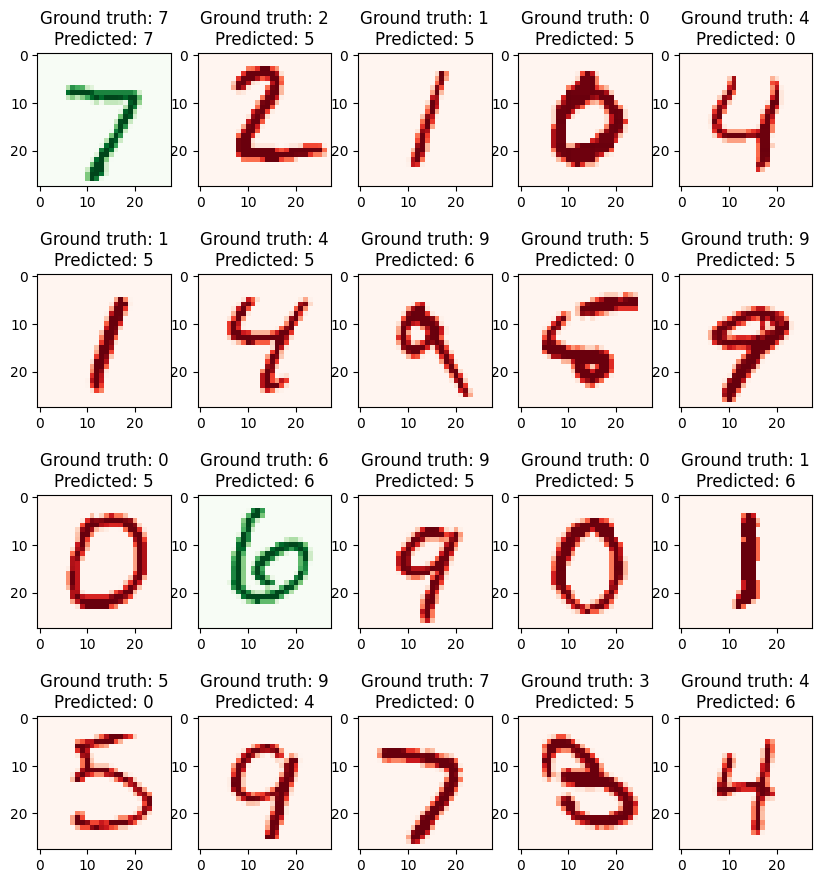

In [7]:
import matplotlib.pyplot as plt

def visualize_model(model):

    fig, axs = plt.subplots(4, 5, figsize=(10, 11))
    axs = [ax for ax1 in axs for ax in ax1]
    show_X = validation_X[:len(axs)]
    show_y = validation_y[:len(axs)]
    show_outputs = model(show_X)
    _, show_predicted = torch.max(show_outputs.data, dim=1)
    for i, ax in enumerate(axs):
        correct = show_y[i].item() == show_predicted[i].item()
        cmap = 'Greens' if correct else 'Reds'
        ax.imshow(show_X[i].cpu(), cmap=cmap)
        ax.set_title(f"Ground truth: {show_y[i].item()}\nPredicted: {show_predicted[i].item()}")
    
    return fig

fig = visualize_model(model)

正しく認識されたものは緑、間違って認識されたものは赤で表示しています。

この中にはいくつか誤認識されたものがあるかもしれません。では、次の節でモデルと最適化アルゴリズムのハイパーパラメタをoptunaで最適化して、認識精度を上げてみましょう。

## 3. Optuna で機械学習のハイパーパラメータを決める

今回調整するハイパーパラメータは、

* モデルの中間層のサイズ (`hidden_dim`)
* モデルの中間層の活性化関数 (`activation`)
* 最適化時の学習率 (`lr`)
* 最適化時のmomentum (`momentum`)

の4つです。これら全てを手動で調整するのは大変なので、今回はこの4つのハイパーパラメータをoptunaで自動的に調整して、モデルの精度を上げます。

(注: 実際に使われるより複雑なモデルでは、今回よりずっと多くのハイパーパラメータが含まれることがあります。)

Optunaでハイパーパラメータを調整するために、先ほどと同様に、`model`と`optimizer`を作って`fit_mnist_and_evaluate`を呼ぶプログラム全体を`objective`関数に包みます。

In [339]:
def objective(trial):
        
    # モデルの定義
    hidden_dim = trial.suggest_int('hidden_dim', 10, 50)  # <-- 10から50までの間で探索
    activation_func = trial.suggest_categorical('activation_func', ['Sigmoid', 'Tanh', 'ReLU', 'ELU'])  # <-- この選択肢の中から探索
    activation_funcs = {
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'ReLU': nn.ReLU(),
        'ELU': nn.ELU(),
    }
    activation = activation_funcs[activation_func]

    model = nn.Sequential(
        nn.Flatten(),                  # 二次元の画像を一次元に変換
        nn.Linear(28*28, hidden_dim),  # 入力層から中間層への線形変換
        activation,                    # 活性化関数
        nn.Linear(hidden_dim, 10),     # 中間層から出力層への線形変換
    )

    # 最適化アルゴリズムの定義
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True) # <-- 1e-5から1e-2までの間で、対数スケールで探索
    momentum = trial.suggest_float("momentum", 0.5, 1.0) # <-- 0.5から1.0までの間で探索
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

    validation_accuracy = fit_mnist_and_evaluate(model, optimizer)
    return validation_accuracy


コメントで`<--`と書いた4カ所と、最後に`return validation_accuracy`としているところが主な変更点です。

では、この目的関数をoptunaを用いて最適化しましょう。

In [340]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(f"最良の精度: {study.best_value}")
print(f"最良のハイパーパラメータ: {study.best_params}")

[I 2023-03-07 19:31:05,873] A new study created in memory with name: no-name-f3fd9487-6bbf-4770-8bb0-a33dc3b119bc


Epoch 1: train_loss=2.295, validation_accuracy=0.2052
Epoch 2: train_loss=2.120, validation_accuracy=0.2989
Epoch 3: train_loss=1.989, validation_accuracy=0.3784
Epoch 4: train_loss=1.875, validation_accuracy=0.4430
Epoch 5: train_loss=1.783, validation_accuracy=0.5043
Epoch 6: train_loss=1.708, validation_accuracy=0.5517
Epoch 7: train_loss=1.641, validation_accuracy=0.5970
Epoch 8: train_loss=1.580, validation_accuracy=0.6315
Epoch 9: train_loss=1.527, validation_accuracy=0.6596
Epoch 10: train_loss=1.479, validation_accuracy=0.6841
Epoch 11: train_loss=1.437, validation_accuracy=0.7027
Epoch 12: train_loss=1.400, validation_accuracy=0.7144
Epoch 13: train_loss=1.367, validation_accuracy=0.7291
Epoch 14: train_loss=1.336, validation_accuracy=0.7392
Epoch 15: train_loss=1.308, validation_accuracy=0.7493
Epoch 16: train_loss=1.281, validation_accuracy=0.7580
Epoch 17: train_loss=1.257, validation_accuracy=0.7641
Epoch 18: train_loss=1.233, validation_accuracy=0.7696


[I 2023-03-07 19:31:07,603] Trial 0 finished with value: 0.7811 and parameters: {'hidden_dim': 48, 'activation_func': 'Tanh', 'lr': 1.7884984611272574e-05, 'momentum': 0.9073629369292808}. Best is trial 0 with value: 0.7811.


Epoch 19: train_loss=1.211, validation_accuracy=0.7761
Epoch 20: train_loss=1.189, validation_accuracy=0.7811
Epoch 1: train_loss=11.140, validation_accuracy=0.1135
Epoch 2: train_loss=2.303, validation_accuracy=0.1135
Epoch 3: train_loss=2.301, validation_accuracy=0.1135
Epoch 4: train_loss=2.300, validation_accuracy=0.1147
Epoch 5: train_loss=2.283, validation_accuracy=0.1500
Epoch 6: train_loss=2.297, validation_accuracy=0.1135
Epoch 7: train_loss=2.302, validation_accuracy=0.1135
Epoch 8: train_loss=2.301, validation_accuracy=0.1135
Epoch 9: train_loss=2.301, validation_accuracy=0.1135
Epoch 10: train_loss=2.301, validation_accuracy=0.1135
Epoch 11: train_loss=2.301, validation_accuracy=0.1135
Epoch 12: train_loss=2.301, validation_accuracy=0.1135
Epoch 13: train_loss=2.301, validation_accuracy=0.1135
Epoch 14: train_loss=2.301, validation_accuracy=0.1135
Epoch 15: train_loss=2.301, validation_accuracy=0.1135
Epoch 16: train_loss=2.301, validation_accuracy=0.1135
Epoch 17: train_lo

[I 2023-03-07 19:31:09,061] Trial 1 finished with value: 0.1135 and parameters: {'hidden_dim': 22, 'activation_func': 'ReLU', 'lr': 0.0018958571671095403, 'momentum': 0.9860071194540374}. Best is trial 0 with value: 0.7811.


Epoch 19: train_loss=2.301, validation_accuracy=0.1135
Epoch 20: train_loss=2.301, validation_accuracy=0.1135
Epoch 1: train_loss=2.924, validation_accuracy=0.1979
Epoch 2: train_loss=2.074, validation_accuracy=0.2036
Epoch 3: train_loss=2.057, validation_accuracy=0.2061
Epoch 4: train_loss=2.046, validation_accuracy=0.2065
Epoch 5: train_loss=2.037, validation_accuracy=0.2081
Epoch 6: train_loss=2.030, validation_accuracy=0.2087
Epoch 7: train_loss=2.023, validation_accuracy=0.2095
Epoch 8: train_loss=2.016, validation_accuracy=0.2360
Epoch 9: train_loss=1.832, validation_accuracy=0.3045
Epoch 10: train_loss=1.762, validation_accuracy=0.3111
Epoch 11: train_loss=1.717, validation_accuracy=0.3667
Epoch 12: train_loss=1.732, validation_accuracy=0.3278
Epoch 13: train_loss=1.699, validation_accuracy=0.3965
Epoch 14: train_loss=1.586, validation_accuracy=0.3716
Epoch 15: train_loss=1.565, validation_accuracy=0.4463
Epoch 16: train_loss=1.481, validation_accuracy=0.4817
Epoch 17: train_los

[I 2023-03-07 19:31:10,523] Trial 2 finished with value: 0.526 and parameters: {'hidden_dim': 31, 'activation_func': 'ReLU', 'lr': 0.0015168786055192328, 'momentum': 0.8792115310408857}. Best is trial 0 with value: 0.7811.


Epoch 20: train_loss=1.426, validation_accuracy=0.5260
Epoch 1: train_loss=5.952, validation_accuracy=0.2371
Epoch 2: train_loss=2.359, validation_accuracy=0.2649
Epoch 3: train_loss=2.115, validation_accuracy=0.2873
Epoch 4: train_loss=1.990, validation_accuracy=0.3087
Epoch 5: train_loss=1.892, validation_accuracy=0.3349
Epoch 6: train_loss=1.806, validation_accuracy=0.3595
Epoch 7: train_loss=1.726, validation_accuracy=0.3865
Epoch 8: train_loss=1.650, validation_accuracy=0.4132
Epoch 9: train_loss=1.579, validation_accuracy=0.4384
Epoch 10: train_loss=1.512, validation_accuracy=0.4675
Epoch 11: train_loss=1.451, validation_accuracy=0.4875
Epoch 12: train_loss=1.394, validation_accuracy=0.5261
Epoch 13: train_loss=1.343, validation_accuracy=0.5487
Epoch 14: train_loss=1.298, validation_accuracy=0.5656
Epoch 15: train_loss=1.255, validation_accuracy=0.5822
Epoch 16: train_loss=1.216, validation_accuracy=0.5967
Epoch 17: train_loss=1.178, validation_accuracy=0.6082
Epoch 18: train_los

[I 2023-03-07 19:31:11,952] Trial 3 finished with value: 0.6426 and parameters: {'hidden_dim': 27, 'activation_func': 'ReLU', 'lr': 1.4256516553133118e-05, 'momentum': 0.7407734900285801}. Best is trial 0 with value: 0.7811.


Epoch 20: train_loss=1.075, validation_accuracy=0.6426
Epoch 1: train_loss=1.768, validation_accuracy=0.6643
Epoch 2: train_loss=1.341, validation_accuracy=0.7386
Epoch 3: train_loss=1.179, validation_accuracy=0.7528
Epoch 4: train_loss=1.071, validation_accuracy=0.7692
Epoch 5: train_loss=0.985, validation_accuracy=0.8065
Epoch 6: train_loss=0.914, validation_accuracy=0.8302
Epoch 7: train_loss=0.852, validation_accuracy=0.8420
Epoch 8: train_loss=0.800, validation_accuracy=0.8509
Epoch 9: train_loss=0.758, validation_accuracy=0.8629
Epoch 10: train_loss=0.722, validation_accuracy=0.8620
Epoch 11: train_loss=0.691, validation_accuracy=0.8659
Epoch 12: train_loss=0.662, validation_accuracy=0.8637
Epoch 13: train_loss=0.636, validation_accuracy=0.8715
Epoch 14: train_loss=0.615, validation_accuracy=0.8773
Epoch 15: train_loss=0.592, validation_accuracy=0.8732
Epoch 16: train_loss=0.577, validation_accuracy=0.8686
Epoch 17: train_loss=0.562, validation_accuracy=0.8722
Epoch 18: train_los

[I 2023-03-07 19:31:13,326] Trial 4 finished with value: 0.8837 and parameters: {'hidden_dim': 14, 'activation_func': 'Tanh', 'lr': 0.0013699932141826698, 'momentum': 0.7181836592480387}. Best is trial 4 with value: 0.8837.


Epoch 19: train_loss=0.537, validation_accuracy=0.8815
Epoch 20: train_loss=0.524, validation_accuracy=0.8837
Epoch 1: train_loss=2.111, validation_accuracy=0.4728
Epoch 2: train_loss=1.831, validation_accuracy=0.6120
Epoch 3: train_loss=1.707, validation_accuracy=0.6893
Epoch 4: train_loss=1.615, validation_accuracy=0.7424
Epoch 5: train_loss=1.545, validation_accuracy=0.7729
Epoch 6: train_loss=1.488, validation_accuracy=0.7851
Epoch 7: train_loss=1.437, validation_accuracy=0.7979
Epoch 8: train_loss=1.392, validation_accuracy=0.8098
Epoch 9: train_loss=1.350, validation_accuracy=0.8189
Epoch 10: train_loss=1.311, validation_accuracy=0.8299
Epoch 11: train_loss=1.274, validation_accuracy=0.8357
Epoch 12: train_loss=1.238, validation_accuracy=0.8361
Epoch 13: train_loss=1.205, validation_accuracy=0.8425
Epoch 14: train_loss=1.173, validation_accuracy=0.8466
Epoch 15: train_loss=1.143, validation_accuracy=0.8500
Epoch 16: train_loss=1.114, validation_accuracy=0.8569
Epoch 17: train_los

[I 2023-03-07 19:31:14,905] Trial 5 finished with value: 0.8661 and parameters: {'hidden_dim': 22, 'activation_func': 'Sigmoid', 'lr': 0.0008678928057781409, 'momentum': 0.6951331506648264}. Best is trial 4 with value: 0.8837.


Epoch 20: train_loss=1.011, validation_accuracy=0.8661
Epoch 1: train_loss=3.919, validation_accuracy=0.5386
Epoch 2: train_loss=1.206, validation_accuracy=0.6972
Epoch 3: train_loss=0.916, validation_accuracy=0.7714
Epoch 4: train_loss=0.758, validation_accuracy=0.8055
Epoch 5: train_loss=0.666, validation_accuracy=0.8291
Epoch 6: train_loss=0.606, validation_accuracy=0.8449
Epoch 7: train_loss=0.562, validation_accuracy=0.8564
Epoch 8: train_loss=0.529, validation_accuracy=0.8660
Epoch 9: train_loss=0.502, validation_accuracy=0.8747
Epoch 10: train_loss=0.479, validation_accuracy=0.8787
Epoch 11: train_loss=0.460, validation_accuracy=0.8833
Epoch 12: train_loss=0.444, validation_accuracy=0.8880
Epoch 13: train_loss=0.429, validation_accuracy=0.8912
Epoch 14: train_loss=0.415, validation_accuracy=0.8949
Epoch 15: train_loss=0.403, validation_accuracy=0.8971
Epoch 16: train_loss=0.393, validation_accuracy=0.8981
Epoch 17: train_loss=0.383, validation_accuracy=0.9023
Epoch 18: train_los

[I 2023-03-07 19:31:16,900] Trial 6 finished with value: 0.9067 and parameters: {'hidden_dim': 36, 'activation_func': 'ELU', 'lr': 1.2832545390956608e-05, 'momentum': 0.9784680995982606}. Best is trial 6 with value: 0.9067.


Epoch 19: train_loss=0.365, validation_accuracy=0.9043
Epoch 20: train_loss=0.358, validation_accuracy=0.9067
Epoch 1: train_loss=2.369, validation_accuracy=0.0976
Epoch 2: train_loss=2.339, validation_accuracy=0.1091
Epoch 3: train_loss=2.314, validation_accuracy=0.1222
Epoch 4: train_loss=2.293, validation_accuracy=0.1372
Epoch 5: train_loss=2.274, validation_accuracy=0.1517
Epoch 6: train_loss=2.257, validation_accuracy=0.1683
Epoch 7: train_loss=2.241, validation_accuracy=0.1848
Epoch 8: train_loss=2.226, validation_accuracy=0.2038
Epoch 9: train_loss=2.211, validation_accuracy=0.2260
Epoch 10: train_loss=2.197, validation_accuracy=0.2496
Epoch 11: train_loss=2.183, validation_accuracy=0.2715
Epoch 12: train_loss=2.170, validation_accuracy=0.2881
Epoch 13: train_loss=2.158, validation_accuracy=0.3035
Epoch 14: train_loss=2.146, validation_accuracy=0.3163
Epoch 15: train_loss=2.134, validation_accuracy=0.3290
Epoch 16: train_loss=2.124, validation_accuracy=0.3415
Epoch 17: train_los

[I 2023-03-07 19:31:18,517] Trial 7 finished with value: 0.384 and parameters: {'hidden_dim': 31, 'activation_func': 'Sigmoid', 'lr': 1.6499386871508213e-05, 'momentum': 0.8252702287052598}. Best is trial 6 with value: 0.9067.


Epoch 20: train_loss=2.083, validation_accuracy=0.3840
Epoch 1: train_loss=4.831, validation_accuracy=0.5662
Epoch 2: train_loss=1.769, validation_accuracy=0.6337
Epoch 3: train_loss=1.380, validation_accuracy=0.6872
Epoch 4: train_loss=1.186, validation_accuracy=0.7211
Epoch 5: train_loss=1.063, validation_accuracy=0.7466
Epoch 6: train_loss=0.975, validation_accuracy=0.7666
Epoch 7: train_loss=0.909, validation_accuracy=0.7804
Epoch 8: train_loss=0.855, validation_accuracy=0.7937
Epoch 9: train_loss=0.811, validation_accuracy=0.8040
Epoch 10: train_loss=0.774, validation_accuracy=0.8129
Epoch 11: train_loss=0.742, validation_accuracy=0.8190
Epoch 12: train_loss=0.713, validation_accuracy=0.8254
Epoch 13: train_loss=0.688, validation_accuracy=0.8335
Epoch 14: train_loss=0.666, validation_accuracy=0.8380
Epoch 15: train_loss=0.646, validation_accuracy=0.8438
Epoch 16: train_loss=0.628, validation_accuracy=0.8469
Epoch 17: train_loss=0.611, validation_accuracy=0.8496


[I 2023-03-07 19:31:20,088] Trial 8 finished with value: 0.8591 and parameters: {'hidden_dim': 49, 'activation_func': 'ReLU', 'lr': 1.8022454658839353e-05, 'momentum': 0.8095968674096524}. Best is trial 6 with value: 0.9067.


Epoch 18: train_loss=0.596, validation_accuracy=0.8523
Epoch 19: train_loss=0.582, validation_accuracy=0.8545
Epoch 20: train_loss=0.569, validation_accuracy=0.8591
Epoch 1: train_loss=2.186, validation_accuracy=0.4890
Epoch 2: train_loss=1.879, validation_accuracy=0.6423
Epoch 3: train_loss=1.695, validation_accuracy=0.7008
Epoch 4: train_loss=1.551, validation_accuracy=0.7480
Epoch 5: train_loss=1.423, validation_accuracy=0.7794
Epoch 6: train_loss=1.312, validation_accuracy=0.8133
Epoch 7: train_loss=1.215, validation_accuracy=0.8296
Epoch 8: train_loss=1.129, validation_accuracy=0.8481
Epoch 9: train_loss=1.055, validation_accuracy=0.8593
Epoch 10: train_loss=0.987, validation_accuracy=0.8667
Epoch 11: train_loss=0.928, validation_accuracy=0.8704
Epoch 12: train_loss=0.875, validation_accuracy=0.8729
Epoch 13: train_loss=0.829, validation_accuracy=0.8786
Epoch 14: train_loss=0.788, validation_accuracy=0.8791
Epoch 15: train_loss=0.752, validation_accuracy=0.8802
Epoch 16: train_los

[I 2023-03-07 19:31:21,659] Trial 9 finished with value: 0.8928 and parameters: {'hidden_dim': 23, 'activation_func': 'Sigmoid', 'lr': 0.00012116922979219344, 'momentum': 0.9850415521883736}. Best is trial 6 with value: 0.9067.


Epoch 19: train_loss=0.639, validation_accuracy=0.8885
Epoch 20: train_loss=0.617, validation_accuracy=0.8928
Epoch 1: train_loss=165.530, validation_accuracy=0.1032
Epoch 2: train_loss=28.210, validation_accuracy=0.1135
Epoch 3: train_loss=17.510, validation_accuracy=0.1135
Epoch 4: train_loss=10.664, validation_accuracy=0.1135
Epoch 5: train_loss=5.710, validation_accuracy=0.1135
Epoch 6: train_loss=2.823, validation_accuracy=0.1135
Epoch 7: train_loss=2.302, validation_accuracy=0.1135
Epoch 8: train_loss=2.302, validation_accuracy=0.1135
Epoch 9: train_loss=2.302, validation_accuracy=0.1135
Epoch 10: train_loss=2.301, validation_accuracy=0.1135
Epoch 11: train_loss=2.301, validation_accuracy=0.1135
Epoch 12: train_loss=2.302, validation_accuracy=0.1135
Epoch 13: train_loss=2.302, validation_accuracy=0.1135
Epoch 14: train_loss=2.302, validation_accuracy=0.1135
Epoch 15: train_loss=2.302, validation_accuracy=0.1135
Epoch 16: train_loss=2.301, validation_accuracy=0.1135
Epoch 17: trai

[I 2023-03-07 19:31:23,412] Trial 10 finished with value: 0.1135 and parameters: {'hidden_dim': 39, 'activation_func': 'ELU', 'lr': 0.00879154045336726, 'momentum': 0.5647559528063972}. Best is trial 6 with value: 0.9067.


Epoch 20: train_loss=2.302, validation_accuracy=0.1135
Epoch 1: train_loss=2.479, validation_accuracy=0.6025
Epoch 2: train_loss=1.010, validation_accuracy=0.7843
Epoch 3: train_loss=0.775, validation_accuracy=0.8290
Epoch 4: train_loss=0.635, validation_accuracy=0.8566
Epoch 5: train_loss=0.538, validation_accuracy=0.8698
Epoch 6: train_loss=0.478, validation_accuracy=0.8847
Epoch 7: train_loss=0.433, validation_accuracy=0.8937
Epoch 8: train_loss=0.398, validation_accuracy=0.8990
Epoch 9: train_loss=0.372, validation_accuracy=0.9065
Epoch 10: train_loss=0.354, validation_accuracy=0.9080
Epoch 11: train_loss=0.334, validation_accuracy=0.9119
Epoch 12: train_loss=0.320, validation_accuracy=0.9179
Epoch 13: train_loss=0.309, validation_accuracy=0.9192
Epoch 14: train_loss=0.299, validation_accuracy=0.9216
Epoch 15: train_loss=0.289, validation_accuracy=0.9237
Epoch 16: train_loss=0.282, validation_accuracy=0.9259
Epoch 17: train_loss=0.276, validation_accuracy=0.9253
Epoch 18: train_los

[I 2023-03-07 19:31:25,356] Trial 11 finished with value: 0.9281 and parameters: {'hidden_dim': 40, 'activation_func': 'ELU', 'lr': 9.035152376488792e-05, 'momentum': 0.9914151175397956}. Best is trial 11 with value: 0.9281.


Epoch 20: train_loss=0.260, validation_accuracy=0.9281
Epoch 1: train_loss=1.927, validation_accuracy=0.7722
Epoch 2: train_loss=0.727, validation_accuracy=0.8319
Epoch 3: train_loss=0.559, validation_accuracy=0.8617
Epoch 4: train_loss=0.462, validation_accuracy=0.8764
Epoch 5: train_loss=0.403, validation_accuracy=0.8940
Epoch 6: train_loss=0.362, validation_accuracy=0.9046
Epoch 7: train_loss=0.335, validation_accuracy=0.9109
Epoch 8: train_loss=0.312, validation_accuracy=0.9137
Epoch 9: train_loss=0.294, validation_accuracy=0.9134
Epoch 10: train_loss=0.283, validation_accuracy=0.9186
Epoch 11: train_loss=0.270, validation_accuracy=0.9212
Epoch 12: train_loss=0.260, validation_accuracy=0.9221
Epoch 13: train_loss=0.252, validation_accuracy=0.9220
Epoch 14: train_loss=0.247, validation_accuracy=0.9253
Epoch 15: train_loss=0.241, validation_accuracy=0.9268
Epoch 16: train_loss=0.235, validation_accuracy=0.9269
Epoch 17: train_loss=0.230, validation_accuracy=0.9283
Epoch 18: train_los

[I 2023-03-07 19:31:27,269] Trial 12 finished with value: 0.9312 and parameters: {'hidden_dim': 40, 'activation_func': 'ELU', 'lr': 8.178829839367222e-05, 'momentum': 0.9888853232962571}. Best is trial 12 with value: 0.9312.


Epoch 20: train_loss=0.215, validation_accuracy=0.9312
Epoch 1: train_loss=2.008, validation_accuracy=0.7945
Epoch 2: train_loss=0.648, validation_accuracy=0.8460
Epoch 3: train_loss=0.514, validation_accuracy=0.8696
Epoch 4: train_loss=0.440, validation_accuracy=0.8846
Epoch 5: train_loss=0.390, validation_accuracy=0.8936
Epoch 6: train_loss=0.354, validation_accuracy=0.9000
Epoch 7: train_loss=0.327, validation_accuracy=0.9044
Epoch 8: train_loss=0.305, validation_accuracy=0.9125
Epoch 9: train_loss=0.286, validation_accuracy=0.9162
Epoch 10: train_loss=0.271, validation_accuracy=0.9181
Epoch 11: train_loss=0.259, validation_accuracy=0.9208
Epoch 12: train_loss=0.248, validation_accuracy=0.9232
Epoch 13: train_loss=0.239, validation_accuracy=0.9239
Epoch 14: train_loss=0.231, validation_accuracy=0.9274
Epoch 15: train_loss=0.224, validation_accuracy=0.9271
Epoch 16: train_loss=0.218, validation_accuracy=0.9284
Epoch 17: train_loss=0.213, validation_accuracy=0.9300
Epoch 18: train_los

[I 2023-03-07 19:31:29,608] Trial 13 finished with value: 0.9338 and parameters: {'hidden_dim': 41, 'activation_func': 'ELU', 'lr': 0.00010943889377667568, 'momentum': 0.9180707709898601}. Best is trial 13 with value: 0.9338.


Epoch 20: train_loss=0.199, validation_accuracy=0.9338
Epoch 1: train_loss=2.143, validation_accuracy=0.7033
Epoch 2: train_loss=0.838, validation_accuracy=0.8103
Epoch 3: train_loss=0.636, validation_accuracy=0.8402
Epoch 4: train_loss=0.537, validation_accuracy=0.8623
Epoch 5: train_loss=0.475, validation_accuracy=0.8772
Epoch 6: train_loss=0.431, validation_accuracy=0.8857
Epoch 7: train_loss=0.396, validation_accuracy=0.8914
Epoch 8: train_loss=0.370, validation_accuracy=0.8979
Epoch 9: train_loss=0.349, validation_accuracy=0.9024
Epoch 10: train_loss=0.331, validation_accuracy=0.9048
Epoch 11: train_loss=0.316, validation_accuracy=0.9065
Epoch 12: train_loss=0.304, validation_accuracy=0.9087
Epoch 13: train_loss=0.293, validation_accuracy=0.9120
Epoch 14: train_loss=0.283, validation_accuracy=0.9139
Epoch 15: train_loss=0.274, validation_accuracy=0.9155
Epoch 16: train_loss=0.267, validation_accuracy=0.9178
Epoch 17: train_loss=0.259, validation_accuracy=0.9196
Epoch 18: train_los

[I 2023-03-07 19:31:32,038] Trial 14 finished with value: 0.9233 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 7.40538801349256e-05, 'momentum': 0.907808743721846}. Best is trial 13 with value: 0.9338.


Epoch 20: train_loss=0.241, validation_accuracy=0.9233
Epoch 1: train_loss=1.642, validation_accuracy=0.7930
Epoch 2: train_loss=0.592, validation_accuracy=0.8605
Epoch 3: train_loss=0.463, validation_accuracy=0.8895
Epoch 4: train_loss=0.385, validation_accuracy=0.9039
Epoch 5: train_loss=0.337, validation_accuracy=0.9142
Epoch 6: train_loss=0.306, validation_accuracy=0.9186
Epoch 7: train_loss=0.283, validation_accuracy=0.9229
Epoch 8: train_loss=0.266, validation_accuracy=0.9242
Epoch 9: train_loss=0.252, validation_accuracy=0.9274
Epoch 10: train_loss=0.240, validation_accuracy=0.9276
Epoch 11: train_loss=0.230, validation_accuracy=0.9299
Epoch 12: train_loss=0.221, validation_accuracy=0.9305
Epoch 13: train_loss=0.215, validation_accuracy=0.9319
Epoch 14: train_loss=0.207, validation_accuracy=0.9323
Epoch 15: train_loss=0.201, validation_accuracy=0.9343
Epoch 16: train_loss=0.195, validation_accuracy=0.9371
Epoch 17: train_loss=0.189, validation_accuracy=0.9375
Epoch 18: train_los

[I 2023-03-07 19:31:34,316] Trial 15 finished with value: 0.9397 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.00024546678976831987, 'momentum': 0.9163587003857323}. Best is trial 15 with value: 0.9397.


Epoch 20: train_loss=0.176, validation_accuracy=0.9397
Epoch 1: train_loss=1.882, validation_accuracy=0.7986
Epoch 2: train_loss=0.567, validation_accuracy=0.8625
Epoch 3: train_loss=0.439, validation_accuracy=0.8877
Epoch 4: train_loss=0.376, validation_accuracy=0.8982
Epoch 5: train_loss=0.335, validation_accuracy=0.9072
Epoch 6: train_loss=0.308, validation_accuracy=0.9116
Epoch 7: train_loss=0.286, validation_accuracy=0.9173
Epoch 8: train_loss=0.268, validation_accuracy=0.9205
Epoch 9: train_loss=0.255, validation_accuracy=0.9256
Epoch 10: train_loss=0.242, validation_accuracy=0.9270
Epoch 11: train_loss=0.231, validation_accuracy=0.9296
Epoch 12: train_loss=0.223, validation_accuracy=0.9319
Epoch 13: train_loss=0.215, validation_accuracy=0.9346
Epoch 14: train_loss=0.209, validation_accuracy=0.9359
Epoch 15: train_loss=0.203, validation_accuracy=0.9372
Epoch 16: train_loss=0.198, validation_accuracy=0.9392
Epoch 17: train_loss=0.193, validation_accuracy=0.9385
Epoch 18: train_los

[I 2023-03-07 19:31:36,850] Trial 16 finished with value: 0.9419 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.0002660970028436869, 'momentum': 0.8384625783626596}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=0.180, validation_accuracy=0.9419
Epoch 1: train_loss=1.545, validation_accuracy=0.8306
Epoch 2: train_loss=0.545, validation_accuracy=0.8703
Epoch 3: train_loss=0.435, validation_accuracy=0.8864
Epoch 4: train_loss=0.380, validation_accuracy=0.8979
Epoch 5: train_loss=0.345, validation_accuracy=0.9032
Epoch 6: train_loss=0.319, validation_accuracy=0.9089
Epoch 7: train_loss=0.299, validation_accuracy=0.9133
Epoch 8: train_loss=0.283, validation_accuracy=0.9141
Epoch 9: train_loss=0.270, validation_accuracy=0.9188
Epoch 10: train_loss=0.258, validation_accuracy=0.9220
Epoch 11: train_loss=0.248, validation_accuracy=0.9245
Epoch 12: train_loss=0.239, validation_accuracy=0.9270
Epoch 13: train_loss=0.231, validation_accuracy=0.9291
Epoch 14: train_loss=0.224, validation_accuracy=0.9303
Epoch 15: train_loss=0.217, validation_accuracy=0.9302
Epoch 16: train_loss=0.211, validation_accuracy=0.9324
Epoch 17: train_loss=0.206, validation_accuracy=0.9335
Epoch 18: train_los

[I 2023-03-07 19:31:39,339] Trial 17 finished with value: 0.9358 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.0004022147930903596, 'momentum': 0.8016712300801881}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=0.190, validation_accuracy=0.9358
Epoch 1: train_loss=1.776, validation_accuracy=0.7787
Epoch 2: train_loss=0.628, validation_accuracy=0.8453
Epoch 3: train_loss=0.491, validation_accuracy=0.8694
Epoch 4: train_loss=0.423, validation_accuracy=0.8833
Epoch 5: train_loss=0.382, validation_accuracy=0.8904
Epoch 6: train_loss=0.353, validation_accuracy=0.8970
Epoch 7: train_loss=0.332, validation_accuracy=0.9020
Epoch 8: train_loss=0.315, validation_accuracy=0.9082
Epoch 9: train_loss=0.301, validation_accuracy=0.9084
Epoch 10: train_loss=0.289, validation_accuracy=0.9104
Epoch 11: train_loss=0.280, validation_accuracy=0.9152
Epoch 12: train_loss=0.270, validation_accuracy=0.9171
Epoch 13: train_loss=0.262, validation_accuracy=0.9184
Epoch 14: train_loss=0.255, validation_accuracy=0.9205
Epoch 15: train_loss=0.249, validation_accuracy=0.9203
Epoch 16: train_loss=0.244, validation_accuracy=0.9224
Epoch 17: train_loss=0.238, validation_accuracy=0.9237
Epoch 18: train_los

[I 2023-03-07 19:31:41,512] Trial 18 finished with value: 0.9269 and parameters: {'hidden_dim': 35, 'activation_func': 'ELU', 'lr': 0.0002584902415874618, 'momentum': 0.8585627899580573}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=0.223, validation_accuracy=0.9269
Epoch 1: train_loss=1.869, validation_accuracy=0.6164
Epoch 2: train_loss=1.349, validation_accuracy=0.7330
Epoch 3: train_loss=1.131, validation_accuracy=0.7856
Epoch 4: train_loss=0.996, validation_accuracy=0.8156
Epoch 5: train_loss=0.902, validation_accuracy=0.8361
Epoch 6: train_loss=0.830, validation_accuracy=0.8500
Epoch 7: train_loss=0.774, validation_accuracy=0.8582
Epoch 8: train_loss=0.727, validation_accuracy=0.8660
Epoch 9: train_loss=0.686, validation_accuracy=0.8694
Epoch 10: train_loss=0.652, validation_accuracy=0.8756
Epoch 11: train_loss=0.622, validation_accuracy=0.8782
Epoch 12: train_loss=0.596, validation_accuracy=0.8845
Epoch 13: train_loss=0.573, validation_accuracy=0.8861
Epoch 14: train_loss=0.553, validation_accuracy=0.8881
Epoch 15: train_loss=0.534, validation_accuracy=0.8915
Epoch 16: train_loss=0.518, validation_accuracy=0.8945
Epoch 17: train_loss=0.503, validation_accuracy=0.8945


[I 2023-03-07 19:31:43,278] Trial 19 finished with value: 0.9007 and parameters: {'hidden_dim': 45, 'activation_func': 'Tanh', 'lr': 0.00036573633284952775, 'momentum': 0.7769429749807124}. Best is trial 16 with value: 0.9419.


Epoch 18: train_loss=0.491, validation_accuracy=0.8969
Epoch 19: train_loss=0.478, validation_accuracy=0.8986
Epoch 20: train_loss=0.467, validation_accuracy=0.9007
Epoch 1: train_loss=1.676, validation_accuracy=0.8226
Epoch 2: train_loss=0.583, validation_accuracy=0.8641
Epoch 3: train_loss=0.462, validation_accuracy=0.8852
Epoch 4: train_loss=0.396, validation_accuracy=0.8963
Epoch 5: train_loss=0.352, validation_accuracy=0.9067
Epoch 6: train_loss=0.322, validation_accuracy=0.9120
Epoch 7: train_loss=0.299, validation_accuracy=0.9168
Epoch 8: train_loss=0.280, validation_accuracy=0.9208
Epoch 9: train_loss=0.264, validation_accuracy=0.9230
Epoch 10: train_loss=0.251, validation_accuracy=0.9254
Epoch 11: train_loss=0.240, validation_accuracy=0.9293
Epoch 12: train_loss=0.230, validation_accuracy=0.9298
Epoch 13: train_loss=0.221, validation_accuracy=0.9312
Epoch 14: train_loss=0.214, validation_accuracy=0.9332
Epoch 15: train_loss=0.206, validation_accuracy=0.9345
Epoch 16: train_los

[I 2023-03-07 19:31:45,806] Trial 20 finished with value: 0.9392 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 0.0001983892617479747, 'momentum': 0.8564603723859742}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.184, validation_accuracy=0.9394
Epoch 20: train_loss=0.179, validation_accuracy=0.9392
Epoch 1: train_loss=1.866, validation_accuracy=0.8098
Epoch 2: train_loss=0.621, validation_accuracy=0.8504
Epoch 3: train_loss=0.501, validation_accuracy=0.8746
Epoch 4: train_loss=0.433, validation_accuracy=0.8859
Epoch 5: train_loss=0.387, validation_accuracy=0.8945
Epoch 6: train_loss=0.352, validation_accuracy=0.9017
Epoch 7: train_loss=0.325, validation_accuracy=0.9074
Epoch 8: train_loss=0.304, validation_accuracy=0.9119
Epoch 9: train_loss=0.287, validation_accuracy=0.9165
Epoch 10: train_loss=0.272, validation_accuracy=0.9190
Epoch 11: train_loss=0.260, validation_accuracy=0.9223
Epoch 12: train_loss=0.248, validation_accuracy=0.9237
Epoch 13: train_loss=0.239, validation_accuracy=0.9246
Epoch 14: train_loss=0.231, validation_accuracy=0.9257
Epoch 15: train_loss=0.223, validation_accuracy=0.9282
Epoch 16: train_loss=0.217, validation_accuracy=0.9285
Epoch 17: train_los

[I 2023-03-07 19:31:48,309] Trial 21 finished with value: 0.932 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.0001788613211710298, 'momentum': 0.8549599999073267}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.200, validation_accuracy=0.9320
Epoch 20: train_loss=0.195, validation_accuracy=0.9320
Epoch 1: train_loss=2.394, validation_accuracy=0.5607
Epoch 2: train_loss=1.033, validation_accuracy=0.6823
Epoch 3: train_loss=0.797, validation_accuracy=0.7528
Epoch 4: train_loss=0.616, validation_accuracy=0.8282
Epoch 5: train_loss=0.516, validation_accuracy=0.8521
Epoch 6: train_loss=0.462, validation_accuracy=0.8676
Epoch 7: train_loss=0.430, validation_accuracy=0.8763
Epoch 8: train_loss=0.410, validation_accuracy=0.8784
Epoch 9: train_loss=0.393, validation_accuracy=0.8822
Epoch 10: train_loss=0.377, validation_accuracy=0.8913
Epoch 11: train_loss=0.359, validation_accuracy=0.8964
Epoch 12: train_loss=0.341, validation_accuracy=0.8989
Epoch 13: train_loss=0.328, validation_accuracy=0.9045
Epoch 14: train_loss=0.316, validation_accuracy=0.9082
Epoch 15: train_loss=0.307, validation_accuracy=0.9105
Epoch 16: train_loss=0.297, validation_accuracy=0.9137
Epoch 17: train_los

[I 2023-03-07 19:31:50,313] Trial 22 finished with value: 0.9222 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.0005599320833020706, 'momentum': 0.9343089492578196}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.269, validation_accuracy=0.9203
Epoch 20: train_loss=0.259, validation_accuracy=0.9222
Epoch 1: train_loss=1.695, validation_accuracy=0.8077
Epoch 2: train_loss=0.577, validation_accuracy=0.8555
Epoch 3: train_loss=0.456, validation_accuracy=0.8830
Epoch 4: train_loss=0.392, validation_accuracy=0.8959
Epoch 5: train_loss=0.351, validation_accuracy=0.9053
Epoch 6: train_loss=0.321, validation_accuracy=0.9126
Epoch 7: train_loss=0.298, validation_accuracy=0.9161
Epoch 8: train_loss=0.280, validation_accuracy=0.9201
Epoch 9: train_loss=0.265, validation_accuracy=0.9224
Epoch 10: train_loss=0.252, validation_accuracy=0.9252
Epoch 11: train_loss=0.242, validation_accuracy=0.9282
Epoch 12: train_loss=0.233, validation_accuracy=0.9288
Epoch 13: train_loss=0.225, validation_accuracy=0.9299
Epoch 14: train_loss=0.218, validation_accuracy=0.9318
Epoch 15: train_loss=0.211, validation_accuracy=0.9325
Epoch 16: train_loss=0.205, validation_accuracy=0.9341
Epoch 17: train_los

[I 2023-03-07 19:31:52,941] Trial 23 finished with value: 0.9371 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00019150676004093796, 'momentum': 0.8618230492360812}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.192, validation_accuracy=0.9365
Epoch 20: train_loss=0.188, validation_accuracy=0.9371
Epoch 1: train_loss=3.031, validation_accuracy=0.7913
Epoch 2: train_loss=0.708, validation_accuracy=0.8407
Epoch 3: train_loss=0.573, validation_accuracy=0.8664
Epoch 4: train_loss=0.496, validation_accuracy=0.8798
Epoch 5: train_loss=0.444, validation_accuracy=0.8901
Epoch 6: train_loss=0.405, validation_accuracy=0.8931
Epoch 7: train_loss=0.374, validation_accuracy=0.8994
Epoch 8: train_loss=0.350, validation_accuracy=0.9035
Epoch 9: train_loss=0.331, validation_accuracy=0.9079
Epoch 10: train_loss=0.314, validation_accuracy=0.9145
Epoch 11: train_loss=0.300, validation_accuracy=0.9182
Epoch 12: train_loss=0.288, validation_accuracy=0.9196
Epoch 13: train_loss=0.277, validation_accuracy=0.9208
Epoch 14: train_loss=0.268, validation_accuracy=0.9221
Epoch 15: train_loss=0.259, validation_accuracy=0.9223
Epoch 16: train_loss=0.252, validation_accuracy=0.9254
Epoch 17: train_los

[I 2023-03-07 19:31:55,524] Trial 24 finished with value: 0.9294 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 4.714322045719687e-05, 'momentum': 0.9385067904945825}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.232, validation_accuracy=0.9273
Epoch 20: train_loss=0.227, validation_accuracy=0.9294
Epoch 1: train_loss=1.899, validation_accuracy=0.8034
Epoch 2: train_loss=0.596, validation_accuracy=0.8635
Epoch 3: train_loss=0.477, validation_accuracy=0.8855
Epoch 4: train_loss=0.419, validation_accuracy=0.8967
Epoch 5: train_loss=0.381, validation_accuracy=0.9017
Epoch 6: train_loss=0.353, validation_accuracy=0.9076
Epoch 7: train_loss=0.332, validation_accuracy=0.9105
Epoch 8: train_loss=0.313, validation_accuracy=0.9137
Epoch 9: train_loss=0.297, validation_accuracy=0.9163
Epoch 10: train_loss=0.285, validation_accuracy=0.9182
Epoch 11: train_loss=0.274, validation_accuracy=0.9201
Epoch 12: train_loss=0.265, validation_accuracy=0.9208
Epoch 13: train_loss=0.257, validation_accuracy=0.9262
Epoch 14: train_loss=0.249, validation_accuracy=0.9286
Epoch 15: train_loss=0.243, validation_accuracy=0.9282
Epoch 16: train_loss=0.237, validation_accuracy=0.9309
Epoch 17: train_los

[I 2023-03-07 19:31:57,721] Trial 25 finished with value: 0.9333 and parameters: {'hidden_dim': 37, 'activation_func': 'ELU', 'lr': 0.00028042894467293866, 'momentum': 0.84190125982011}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.222, validation_accuracy=0.9327
Epoch 20: train_loss=0.218, validation_accuracy=0.9333
Epoch 1: train_loss=2.820, validation_accuracy=0.2382
Epoch 2: train_loss=2.050, validation_accuracy=0.3230
Epoch 3: train_loss=1.900, validation_accuracy=0.3513
Epoch 4: train_loss=1.825, validation_accuracy=0.3632
Epoch 5: train_loss=1.782, validation_accuracy=0.3722
Epoch 6: train_loss=1.751, validation_accuracy=0.3770
Epoch 7: train_loss=1.722, validation_accuracy=0.3830
Epoch 8: train_loss=1.689, validation_accuracy=0.3901
Epoch 9: train_loss=1.657, validation_accuracy=0.3928
Epoch 10: train_loss=1.631, validation_accuracy=0.3970
Epoch 11: train_loss=1.605, validation_accuracy=0.4084
Epoch 12: train_loss=1.572, validation_accuracy=0.4250
Epoch 13: train_loss=1.516, validation_accuracy=0.4431
Epoch 14: train_loss=1.467, validation_accuracy=0.4522
Epoch 15: train_loss=1.432, validation_accuracy=0.4671
Epoch 16: train_loss=1.410, validation_accuracy=0.4688
Epoch 17: train_los

[I 2023-03-07 19:31:59,185] Trial 26 finished with value: 0.4798 and parameters: {'hidden_dim': 11, 'activation_func': 'ELU', 'lr': 4.0612811500850435e-05, 'momentum': 0.7761555487807899}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=1.354, validation_accuracy=0.4798
Epoch 1: train_loss=2.208, validation_accuracy=0.3981
Epoch 2: train_loss=1.972, validation_accuracy=0.5167
Epoch 3: train_loss=1.818, validation_accuracy=0.5997
Epoch 4: train_loss=1.707, validation_accuracy=0.6502
Epoch 5: train_loss=1.619, validation_accuracy=0.6842
Epoch 6: train_loss=1.546, validation_accuracy=0.7124
Epoch 7: train_loss=1.483, validation_accuracy=0.7380
Epoch 8: train_loss=1.427, validation_accuracy=0.7568
Epoch 9: train_loss=1.377, validation_accuracy=0.7769
Epoch 10: train_loss=1.330, validation_accuracy=0.7944
Epoch 11: train_loss=1.285, validation_accuracy=0.8078
Epoch 12: train_loss=1.245, validation_accuracy=0.8184
Epoch 13: train_loss=1.207, validation_accuracy=0.8278
Epoch 14: train_loss=1.171, validation_accuracy=0.8360
Epoch 15: train_loss=1.137, validation_accuracy=0.8406
Epoch 16: train_loss=1.105, validation_accuracy=0.8437
Epoch 17: train_loss=1.075, validation_accuracy=0.8494
Epoch 18: train_los

[I 2023-03-07 19:32:01,510] Trial 27 finished with value: 0.8584 and parameters: {'hidden_dim': 47, 'activation_func': 'Sigmoid', 'lr': 0.00016397974121165322, 'momentum': 0.886478309921702}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=0.992, validation_accuracy=0.8584
Epoch 1: train_loss=1.833, validation_accuracy=0.6705
Epoch 2: train_loss=1.301, validation_accuracy=0.7765
Epoch 3: train_loss=1.094, validation_accuracy=0.8213
Epoch 4: train_loss=0.961, validation_accuracy=0.8456
Epoch 5: train_loss=0.864, validation_accuracy=0.8577
Epoch 6: train_loss=0.791, validation_accuracy=0.8677
Epoch 7: train_loss=0.732, validation_accuracy=0.8743
Epoch 8: train_loss=0.684, validation_accuracy=0.8782
Epoch 9: train_loss=0.642, validation_accuracy=0.8828
Epoch 10: train_loss=0.607, validation_accuracy=0.8847
Epoch 11: train_loss=0.577, validation_accuracy=0.8889
Epoch 12: train_loss=0.551, validation_accuracy=0.8911
Epoch 13: train_loss=0.528, validation_accuracy=0.8954
Epoch 14: train_loss=0.505, validation_accuracy=0.8961
Epoch 15: train_loss=0.488, validation_accuracy=0.8984
Epoch 16: train_loss=0.470, validation_accuracy=0.8988
Epoch 17: train_loss=0.455, validation_accuracy=0.9019
Epoch 18: train_los

[I 2023-03-07 19:32:03,276] Trial 28 finished with value: 0.9032 and parameters: {'hidden_dim': 34, 'activation_func': 'Tanh', 'lr': 0.0005225831119454467, 'momentum': 0.8283476168625541}. Best is trial 16 with value: 0.9419.


Epoch 19: train_loss=0.429, validation_accuracy=0.9034
Epoch 20: train_loss=0.418, validation_accuracy=0.9032
Epoch 1: train_loss=1.791, validation_accuracy=0.6964
Epoch 2: train_loss=1.207, validation_accuracy=0.7958
Epoch 3: train_loss=0.983, validation_accuracy=0.8261
Epoch 4: train_loss=0.850, validation_accuracy=0.8418
Epoch 5: train_loss=0.757, validation_accuracy=0.8543
Epoch 6: train_loss=0.688, validation_accuracy=0.8660
Epoch 7: train_loss=0.636, validation_accuracy=0.8731
Epoch 8: train_loss=0.594, validation_accuracy=0.8774
Epoch 9: train_loss=0.559, validation_accuracy=0.8812
Epoch 10: train_loss=0.531, validation_accuracy=0.8833
Epoch 11: train_loss=0.506, validation_accuracy=0.8866
Epoch 12: train_loss=0.486, validation_accuracy=0.8911
Epoch 13: train_loss=0.467, validation_accuracy=0.8937
Epoch 14: train_loss=0.451, validation_accuracy=0.8932
Epoch 15: train_loss=0.436, validation_accuracy=0.8971
Epoch 16: train_loss=0.423, validation_accuracy=0.8955
Epoch 17: train_los

[I 2023-03-07 19:32:05,082] Trial 29 finished with value: 0.9045 and parameters: {'hidden_dim': 50, 'activation_func': 'Tanh', 'lr': 0.00024802566310253097, 'momentum': 0.8967900431140616}. Best is trial 16 with value: 0.9419.


Epoch 20: train_loss=0.382, validation_accuracy=0.9045
Epoch 1: train_loss=1.794, validation_accuracy=0.8372
Epoch 2: train_loss=0.504, validation_accuracy=0.8817
Epoch 3: train_loss=0.396, validation_accuracy=0.8979
Epoch 4: train_loss=0.338, validation_accuracy=0.9090
Epoch 5: train_loss=0.302, validation_accuracy=0.9192
Epoch 6: train_loss=0.278, validation_accuracy=0.9224
Epoch 7: train_loss=0.260, validation_accuracy=0.9271
Epoch 8: train_loss=0.245, validation_accuracy=0.9290
Epoch 9: train_loss=0.233, validation_accuracy=0.9315
Epoch 10: train_loss=0.222, validation_accuracy=0.9327
Epoch 11: train_loss=0.214, validation_accuracy=0.9340
Epoch 12: train_loss=0.208, validation_accuracy=0.9348
Epoch 13: train_loss=0.201, validation_accuracy=0.9374
Epoch 14: train_loss=0.196, validation_accuracy=0.9366
Epoch 15: train_loss=0.190, validation_accuracy=0.9390
Epoch 16: train_loss=0.186, validation_accuracy=0.9396
Epoch 17: train_loss=0.182, validation_accuracy=0.9403
Epoch 18: train_los

[I 2023-03-07 19:32:07,350] Trial 30 finished with value: 0.9421 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00014907503625148617, 'momentum': 0.94605407828453}. Best is trial 30 with value: 0.9421.


Epoch 20: train_loss=0.171, validation_accuracy=0.9421
Epoch 1: train_loss=2.033, validation_accuracy=0.7813
Epoch 2: train_loss=0.661, validation_accuracy=0.8639
Epoch 3: train_loss=0.476, validation_accuracy=0.8847
Epoch 4: train_loss=0.397, validation_accuracy=0.8983
Epoch 5: train_loss=0.351, validation_accuracy=0.9078
Epoch 6: train_loss=0.319, validation_accuracy=0.9139
Epoch 7: train_loss=0.296, validation_accuracy=0.9184
Epoch 8: train_loss=0.276, validation_accuracy=0.9197
Epoch 9: train_loss=0.261, validation_accuracy=0.9248
Epoch 10: train_loss=0.249, validation_accuracy=0.9268
Epoch 11: train_loss=0.238, validation_accuracy=0.9287
Epoch 12: train_loss=0.229, validation_accuracy=0.9306
Epoch 13: train_loss=0.220, validation_accuracy=0.9340
Epoch 14: train_loss=0.213, validation_accuracy=0.9333
Epoch 15: train_loss=0.208, validation_accuracy=0.9370
Epoch 16: train_loss=0.203, validation_accuracy=0.9370
Epoch 17: train_loss=0.198, validation_accuracy=0.9388
Epoch 18: train_los

[I 2023-03-07 19:32:09,466] Trial 31 finished with value: 0.9399 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00015032060908039475, 'momentum': 0.9447836589030433}. Best is trial 30 with value: 0.9421.


Epoch 19: train_loss=0.189, validation_accuracy=0.9405
Epoch 20: train_loss=0.186, validation_accuracy=0.9399
Epoch 1: train_loss=2.043, validation_accuracy=0.7925
Epoch 2: train_loss=0.622, validation_accuracy=0.8561
Epoch 3: train_loss=0.475, validation_accuracy=0.8853
Epoch 4: train_loss=0.395, validation_accuracy=0.8988
Epoch 5: train_loss=0.345, validation_accuracy=0.9091
Epoch 6: train_loss=0.311, validation_accuracy=0.9158
Epoch 7: train_loss=0.288, validation_accuracy=0.9177
Epoch 8: train_loss=0.269, validation_accuracy=0.9238
Epoch 9: train_loss=0.253, validation_accuracy=0.9270
Epoch 10: train_loss=0.241, validation_accuracy=0.9275
Epoch 11: train_loss=0.231, validation_accuracy=0.9299
Epoch 12: train_loss=0.223, validation_accuracy=0.9328
Epoch 13: train_loss=0.215, validation_accuracy=0.9321
Epoch 14: train_loss=0.209, validation_accuracy=0.9349
Epoch 15: train_loss=0.202, validation_accuracy=0.9360
Epoch 16: train_loss=0.197, validation_accuracy=0.9375
Epoch 17: train_los

[I 2023-03-07 19:32:11,555] Trial 32 finished with value: 0.9408 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.00013388523825287713, 'momentum': 0.9564551924002929}. Best is trial 30 with value: 0.9421.


Epoch 19: train_loss=0.181, validation_accuracy=0.9400
Epoch 20: train_loss=0.177, validation_accuracy=0.9408
Epoch 1: train_loss=1.830, validation_accuracy=0.8311
Epoch 2: train_loss=0.508, validation_accuracy=0.8793
Epoch 3: train_loss=0.395, validation_accuracy=0.9001
Epoch 4: train_loss=0.336, validation_accuracy=0.9100
Epoch 5: train_loss=0.298, validation_accuracy=0.9153
Epoch 6: train_loss=0.271, validation_accuracy=0.9200
Epoch 7: train_loss=0.252, validation_accuracy=0.9250
Epoch 8: train_loss=0.236, validation_accuracy=0.9287
Epoch 9: train_loss=0.223, validation_accuracy=0.9305
Epoch 10: train_loss=0.211, validation_accuracy=0.9325
Epoch 11: train_loss=0.202, validation_accuracy=0.9344
Epoch 12: train_loss=0.193, validation_accuracy=0.9361
Epoch 13: train_loss=0.186, validation_accuracy=0.9373
Epoch 14: train_loss=0.179, validation_accuracy=0.9381
Epoch 15: train_loss=0.173, validation_accuracy=0.9414
Epoch 16: train_loss=0.167, validation_accuracy=0.9412
Epoch 17: train_los

[I 2023-03-07 19:32:13,772] Trial 33 finished with value: 0.9448 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00013517560908049732, 'momentum': 0.9507501082623552}. Best is trial 33 with value: 0.9448.


Epoch 19: train_loss=0.154, validation_accuracy=0.9425
Epoch 20: train_loss=0.150, validation_accuracy=0.9448
Epoch 1: train_loss=2.491, validation_accuracy=0.5793
Epoch 2: train_loss=1.120, validation_accuracy=0.7320
Epoch 3: train_loss=0.939, validation_accuracy=0.7782
Epoch 4: train_loss=0.827, validation_accuracy=0.8025
Epoch 5: train_loss=0.749, validation_accuracy=0.8089
Epoch 6: train_loss=0.696, validation_accuracy=0.8162
Epoch 7: train_loss=0.654, validation_accuracy=0.8252
Epoch 8: train_loss=0.605, validation_accuracy=0.8418
Epoch 9: train_loss=0.548, validation_accuracy=0.8504
Epoch 10: train_loss=0.494, validation_accuracy=0.8603
Epoch 11: train_loss=0.451, validation_accuracy=0.8699
Epoch 12: train_loss=0.420, validation_accuracy=0.8763
Epoch 13: train_loss=0.396, validation_accuracy=0.8808
Epoch 14: train_loss=0.378, validation_accuracy=0.8849
Epoch 15: train_loss=0.362, validation_accuracy=0.8872
Epoch 16: train_loss=0.350, validation_accuracy=0.8899
Epoch 17: train_los

[I 2023-03-07 19:32:15,279] Trial 34 finished with value: 0.9014 and parameters: {'hidden_dim': 38, 'activation_func': 'ReLU', 'lr': 5.4789035619553734e-05, 'momentum': 0.962557567589222}. Best is trial 33 with value: 0.9448.


Epoch 19: train_loss=0.320, validation_accuracy=0.8998
Epoch 20: train_loss=0.312, validation_accuracy=0.9014
Epoch 1: train_loss=2.544, validation_accuracy=0.4747
Epoch 2: train_loss=1.164, validation_accuracy=0.7174
Epoch 3: train_loss=0.791, validation_accuracy=0.8004
Epoch 4: train_loss=0.633, validation_accuracy=0.8358
Epoch 5: train_loss=0.547, validation_accuracy=0.8577
Epoch 6: train_loss=0.493, validation_accuracy=0.8695
Epoch 7: train_loss=0.453, validation_accuracy=0.8789
Epoch 8: train_loss=0.424, validation_accuracy=0.8858
Epoch 9: train_loss=0.401, validation_accuracy=0.8907
Epoch 10: train_loss=0.382, validation_accuracy=0.8945
Epoch 11: train_loss=0.367, validation_accuracy=0.8953
Epoch 12: train_loss=0.355, validation_accuracy=0.8991
Epoch 13: train_loss=0.344, validation_accuracy=0.9001
Epoch 14: train_loss=0.336, validation_accuracy=0.9020
Epoch 15: train_loss=0.328, validation_accuracy=0.9029
Epoch 16: train_loss=0.321, validation_accuracy=0.9051
Epoch 17: train_los

[I 2023-03-07 19:32:16,992] Trial 35 finished with value: 0.9099 and parameters: {'hidden_dim': 33, 'activation_func': 'ELU', 'lr': 0.00011105108679259807, 'momentum': 0.9578719782106638}. Best is trial 33 with value: 0.9448.


Epoch 20: train_loss=0.298, validation_accuracy=0.9099
Epoch 1: train_loss=3.282, validation_accuracy=0.4506
Epoch 2: train_loss=1.539, validation_accuracy=0.5551
Epoch 3: train_loss=1.288, validation_accuracy=0.6397
Epoch 4: train_loss=1.112, validation_accuracy=0.6922
Epoch 5: train_loss=0.982, validation_accuracy=0.7332
Epoch 6: train_loss=0.887, validation_accuracy=0.7609
Epoch 7: train_loss=0.819, validation_accuracy=0.7788
Epoch 8: train_loss=0.766, validation_accuracy=0.7914
Epoch 9: train_loss=0.722, validation_accuracy=0.8034
Epoch 10: train_loss=0.685, validation_accuracy=0.8152
Epoch 11: train_loss=0.654, validation_accuracy=0.8252
Epoch 12: train_loss=0.626, validation_accuracy=0.8320
Epoch 13: train_loss=0.601, validation_accuracy=0.8411
Epoch 14: train_loss=0.579, validation_accuracy=0.8452
Epoch 15: train_loss=0.560, validation_accuracy=0.8503
Epoch 16: train_loss=0.543, validation_accuracy=0.8552


[I 2023-03-07 19:32:18,312] Trial 36 finished with value: 0.869 and parameters: {'hidden_dim': 28, 'activation_func': 'ReLU', 'lr': 3.108645847887955e-05, 'momentum': 0.8915268320345964}. Best is trial 33 with value: 0.9448.


Epoch 17: train_loss=0.527, validation_accuracy=0.8580
Epoch 18: train_loss=0.513, validation_accuracy=0.8643
Epoch 19: train_loss=0.499, validation_accuracy=0.8696
Epoch 20: train_loss=0.487, validation_accuracy=0.8690
Epoch 1: train_loss=2.056, validation_accuracy=0.8383
Epoch 2: train_loss=0.548, validation_accuracy=0.8723
Epoch 3: train_loss=0.448, validation_accuracy=0.8875
Epoch 4: train_loss=0.395, validation_accuracy=0.9002
Epoch 5: train_loss=0.360, validation_accuracy=0.9050
Epoch 6: train_loss=0.334, validation_accuracy=0.9103
Epoch 7: train_loss=0.313, validation_accuracy=0.9149
Epoch 8: train_loss=0.295, validation_accuracy=0.9183
Epoch 9: train_loss=0.280, validation_accuracy=0.9222
Epoch 10: train_loss=0.268, validation_accuracy=0.9245
Epoch 11: train_loss=0.256, validation_accuracy=0.9270
Epoch 12: train_loss=0.246, validation_accuracy=0.9292
Epoch 13: train_loss=0.236, validation_accuracy=0.9295
Epoch 14: train_loss=0.228, validation_accuracy=0.9327
Epoch 15: train_los

[I 2023-03-07 19:32:20,819] Trial 37 finished with value: 0.939 and parameters: {'hidden_dim': 47, 'activation_func': 'ELU', 'lr': 6.439005839207221e-05, 'momentum': 0.9575411957842059}. Best is trial 33 with value: 0.9448.


Epoch 19: train_loss=0.196, validation_accuracy=0.9373
Epoch 20: train_loss=0.191, validation_accuracy=0.9390
Epoch 1: train_loss=2.116, validation_accuracy=0.6341
Epoch 2: train_loss=1.679, validation_accuracy=0.7020
Epoch 3: train_loss=1.366, validation_accuracy=0.7775
Epoch 4: train_loss=1.041, validation_accuracy=0.8129
Epoch 5: train_loss=0.781, validation_accuracy=0.8385
Epoch 6: train_loss=0.619, validation_accuracy=0.8527
Epoch 7: train_loss=0.533, validation_accuracy=0.8654
Epoch 8: train_loss=0.479, validation_accuracy=0.8718
Epoch 9: train_loss=0.457, validation_accuracy=0.8748
Epoch 10: train_loss=0.447, validation_accuracy=0.8769
Epoch 11: train_loss=0.443, validation_accuracy=0.8802
Epoch 12: train_loss=0.440, validation_accuracy=0.8827
Epoch 13: train_loss=0.438, validation_accuracy=0.8853
Epoch 14: train_loss=0.438, validation_accuracy=0.8874
Epoch 15: train_loss=0.439, validation_accuracy=0.8917
Epoch 16: train_loss=0.441, validation_accuracy=0.8938
Epoch 17: train_los

[I 2023-03-07 19:32:22,504] Trial 38 finished with value: 0.8933 and parameters: {'hidden_dim': 38, 'activation_func': 'Sigmoid', 'lr': 0.00011829869526731271, 'momentum': 0.9997746964189058}. Best is trial 33 with value: 0.9448.


Epoch 19: train_loss=0.463, validation_accuracy=0.8922
Epoch 20: train_loss=0.472, validation_accuracy=0.8933
Epoch 1: train_loss=1.877, validation_accuracy=0.6418
Epoch 2: train_loss=1.374, validation_accuracy=0.7415
Epoch 3: train_loss=1.175, validation_accuracy=0.7887
Epoch 4: train_loss=1.046, validation_accuracy=0.8110
Epoch 5: train_loss=0.945, validation_accuracy=0.8304
Epoch 6: train_loss=0.863, validation_accuracy=0.8421
Epoch 7: train_loss=0.798, validation_accuracy=0.8528
Epoch 8: train_loss=0.745, validation_accuracy=0.8602
Epoch 9: train_loss=0.701, validation_accuracy=0.8630
Epoch 10: train_loss=0.665, validation_accuracy=0.8704
Epoch 11: train_loss=0.633, validation_accuracy=0.8696
Epoch 12: train_loss=0.603, validation_accuracy=0.8743
Epoch 13: train_loss=0.579, validation_accuracy=0.8722
Epoch 14: train_loss=0.562, validation_accuracy=0.8788
Epoch 15: train_loss=0.541, validation_accuracy=0.8825
Epoch 16: train_loss=0.527, validation_accuracy=0.8806
Epoch 17: train_los

[I 2023-03-07 19:32:23,771] Trial 39 finished with value: 0.8872 and parameters: {'hidden_dim': 16, 'activation_func': 'Tanh', 'lr': 0.00036813287090880446, 'momentum': 0.9287345281334032}. Best is trial 33 with value: 0.9448.


Epoch 18: train_loss=0.499, validation_accuracy=0.8826
Epoch 19: train_loss=0.488, validation_accuracy=0.8873
Epoch 20: train_loss=0.477, validation_accuracy=0.8872
Epoch 1: train_loss=2.710, validation_accuracy=0.5456
Epoch 2: train_loss=1.189, validation_accuracy=0.6900
Epoch 3: train_loss=0.921, validation_accuracy=0.7604
Epoch 4: train_loss=0.773, validation_accuracy=0.7940
Epoch 5: train_loss=0.691, validation_accuracy=0.8129
Epoch 6: train_loss=0.634, validation_accuracy=0.8269
Epoch 7: train_loss=0.592, validation_accuracy=0.8374
Epoch 8: train_loss=0.559, validation_accuracy=0.8447
Epoch 9: train_loss=0.530, validation_accuracy=0.8533
Epoch 10: train_loss=0.506, validation_accuracy=0.8591
Epoch 11: train_loss=0.485, validation_accuracy=0.8646
Epoch 12: train_loss=0.465, validation_accuracy=0.8689
Epoch 13: train_loss=0.448, validation_accuracy=0.8730
Epoch 14: train_loss=0.432, validation_accuracy=0.8778
Epoch 15: train_loss=0.419, validation_accuracy=0.8794
Epoch 16: train_los

[I 2023-03-07 19:32:25,047] Trial 40 finished with value: 0.8937 and parameters: {'hidden_dim': 25, 'activation_func': 'ReLU', 'lr': 7.512707053981215e-05, 'momentum': 0.8791426960813119}. Best is trial 33 with value: 0.9448.


Epoch 18: train_loss=0.383, validation_accuracy=0.8904
Epoch 19: train_loss=0.374, validation_accuracy=0.8922
Epoch 20: train_loss=0.364, validation_accuracy=0.8937
Epoch 1: train_loss=1.595, validation_accuracy=0.8367
Epoch 2: train_loss=0.509, validation_accuracy=0.8813
Epoch 3: train_loss=0.407, validation_accuracy=0.9019
Epoch 4: train_loss=0.350, validation_accuracy=0.9088
Epoch 5: train_loss=0.317, validation_accuracy=0.9191
Epoch 6: train_loss=0.289, validation_accuracy=0.9222
Epoch 7: train_loss=0.269, validation_accuracy=0.9280
Epoch 8: train_loss=0.252, validation_accuracy=0.9307
Epoch 9: train_loss=0.239, validation_accuracy=0.9332
Epoch 10: train_loss=0.228, validation_accuracy=0.9354
Epoch 11: train_loss=0.218, validation_accuracy=0.9369
Epoch 12: train_loss=0.210, validation_accuracy=0.9374
Epoch 13: train_loss=0.203, validation_accuracy=0.9389
Epoch 14: train_loss=0.196, validation_accuracy=0.9400
Epoch 15: train_loss=0.190, validation_accuracy=0.9413
Epoch 16: train_los

[I 2023-03-07 19:32:27,071] Trial 41 finished with value: 0.9451 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00014813846042473206, 'momentum': 0.952352749284626}. Best is trial 41 with value: 0.9451.


Epoch 19: train_loss=0.172, validation_accuracy=0.9442
Epoch 20: train_loss=0.169, validation_accuracy=0.9451
Epoch 1: train_loss=1.698, validation_accuracy=0.8152
Epoch 2: train_loss=0.562, validation_accuracy=0.8772
Epoch 3: train_loss=0.414, validation_accuracy=0.9000
Epoch 4: train_loss=0.333, validation_accuracy=0.9151
Epoch 5: train_loss=0.288, validation_accuracy=0.9205
Epoch 6: train_loss=0.261, validation_accuracy=0.9246
Epoch 7: train_loss=0.243, validation_accuracy=0.9304
Epoch 8: train_loss=0.230, validation_accuracy=0.9312
Epoch 9: train_loss=0.220, validation_accuracy=0.9334
Epoch 10: train_loss=0.211, validation_accuracy=0.9357
Epoch 11: train_loss=0.203, validation_accuracy=0.9379
Epoch 12: train_loss=0.198, validation_accuracy=0.9396
Epoch 13: train_loss=0.192, validation_accuracy=0.9380
Epoch 14: train_loss=0.186, validation_accuracy=0.9421
Epoch 15: train_loss=0.181, validation_accuracy=0.9408
Epoch 16: train_loss=0.176, validation_accuracy=0.9432
Epoch 17: train_los

[I 2023-03-07 19:32:29,054] Trial 42 finished with value: 0.9462 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.0001438697920405901, 'momentum': 0.9699784024166463}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.164, validation_accuracy=0.9447
Epoch 20: train_loss=0.161, validation_accuracy=0.9462
Epoch 1: train_loss=2.461, validation_accuracy=0.5575
Epoch 2: train_loss=1.131, validation_accuracy=0.6312
Epoch 3: train_loss=0.922, validation_accuracy=0.7310
Epoch 4: train_loss=0.736, validation_accuracy=0.7888
Epoch 5: train_loss=0.599, validation_accuracy=0.8387
Epoch 6: train_loss=0.504, validation_accuracy=0.8715
Epoch 7: train_loss=0.433, validation_accuracy=0.8835
Epoch 8: train_loss=0.391, validation_accuracy=0.8902
Epoch 9: train_loss=0.363, validation_accuracy=0.8980
Epoch 10: train_loss=0.342, validation_accuracy=0.8981
Epoch 11: train_loss=0.326, validation_accuracy=0.9014
Epoch 12: train_loss=0.313, validation_accuracy=0.9055
Epoch 13: train_loss=0.304, validation_accuracy=0.9061
Epoch 14: train_loss=0.296, validation_accuracy=0.9074
Epoch 15: train_loss=0.289, validation_accuracy=0.9107
Epoch 16: train_loss=0.283, validation_accuracy=0.9116
Epoch 17: train_los

[I 2023-03-07 19:32:31,070] Trial 43 finished with value: 0.9199 and parameters: {'hidden_dim': 41, 'activation_func': 'ELU', 'lr': 0.00014493078448679544, 'momentum': 0.9714783937288286}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.272, validation_accuracy=0.9150
Epoch 19: train_loss=0.266, validation_accuracy=0.9162
Epoch 20: train_loss=0.261, validation_accuracy=0.9199
Epoch 1: train_loss=2.457, validation_accuracy=0.6554
Epoch 2: train_loss=0.886, validation_accuracy=0.7673
Epoch 3: train_loss=0.682, validation_accuracy=0.8121
Epoch 4: train_loss=0.588, validation_accuracy=0.8330
Epoch 5: train_loss=0.532, validation_accuracy=0.8535
Epoch 6: train_loss=0.490, validation_accuracy=0.8650
Epoch 7: train_loss=0.459, validation_accuracy=0.8742
Epoch 8: train_loss=0.432, validation_accuracy=0.8827
Epoch 9: train_loss=0.408, validation_accuracy=0.8894
Epoch 10: train_loss=0.387, validation_accuracy=0.8939
Epoch 11: train_loss=0.367, validation_accuracy=0.8969
Epoch 12: train_loss=0.351, validation_accuracy=0.9008
Epoch 13: train_loss=0.337, validation_accuracy=0.9027
Epoch 14: train_loss=0.326, validation_accuracy=0.9072
Epoch 15: train_loss=0.315, validation_accuracy=0.9083
Epoch 16: train_los

[I 2023-03-07 19:32:32,942] Trial 44 finished with value: 0.9159 and parameters: {'hidden_dim': 32, 'activation_func': 'ELU', 'lr': 9.599394510989447e-05, 'momentum': 0.9210586727011874}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.291, validation_accuracy=0.9138
Epoch 19: train_loss=0.285, validation_accuracy=0.9155
Epoch 20: train_loss=0.279, validation_accuracy=0.9159
Epoch 1: train_loss=1.989, validation_accuracy=0.7638
Epoch 2: train_loss=0.632, validation_accuracy=0.8591
Epoch 3: train_loss=0.471, validation_accuracy=0.8784
Epoch 4: train_loss=0.388, validation_accuracy=0.8997
Epoch 5: train_loss=0.339, validation_accuracy=0.9084
Epoch 6: train_loss=0.314, validation_accuracy=0.9130
Epoch 7: train_loss=0.297, validation_accuracy=0.9136
Epoch 8: train_loss=0.283, validation_accuracy=0.9204
Epoch 9: train_loss=0.274, validation_accuracy=0.9230
Epoch 10: train_loss=0.265, validation_accuracy=0.9196
Epoch 11: train_loss=0.257, validation_accuracy=0.9253
Epoch 12: train_loss=0.250, validation_accuracy=0.9239
Epoch 13: train_loss=0.245, validation_accuracy=0.9262
Epoch 14: train_loss=0.242, validation_accuracy=0.9268
Epoch 15: train_loss=0.237, validation_accuracy=0.9267
Epoch 16: train_los

[I 2023-03-07 19:32:34,969] Trial 45 finished with value: 0.9293 and parameters: {'hidden_dim': 39, 'activation_func': 'ELU', 'lr': 0.00020046560798051382, 'momentum': 0.9723359929068874}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.225, validation_accuracy=0.9314
Epoch 20: train_loss=0.220, validation_accuracy=0.9293
Epoch 1: train_loss=2.132, validation_accuracy=0.7463
Epoch 2: train_loss=0.854, validation_accuracy=0.8174
Epoch 3: train_loss=0.650, validation_accuracy=0.8432
Epoch 4: train_loss=0.555, validation_accuracy=0.8616
Epoch 5: train_loss=0.486, validation_accuracy=0.8781
Epoch 6: train_loss=0.433, validation_accuracy=0.8876
Epoch 7: train_loss=0.397, validation_accuracy=0.8907
Epoch 8: train_loss=0.378, validation_accuracy=0.8958
Epoch 9: train_loss=0.366, validation_accuracy=0.9021
Epoch 10: train_loss=0.346, validation_accuracy=0.9006
Epoch 11: train_loss=0.334, validation_accuracy=0.9037
Epoch 12: train_loss=0.325, validation_accuracy=0.9103
Epoch 13: train_loss=0.317, validation_accuracy=0.9115
Epoch 14: train_loss=0.307, validation_accuracy=0.9141
Epoch 15: train_loss=0.304, validation_accuracy=0.9153
Epoch 16: train_loss=0.298, validation_accuracy=0.9147
Epoch 17: train_los

[I 2023-03-07 19:32:37,102] Trial 46 finished with value: 0.9196 and parameters: {'hidden_dim': 47, 'activation_func': 'ELU', 'lr': 9.12388434318063e-05, 'momentum': 0.9949153152070669}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.276, validation_accuracy=0.9196
Epoch 1: train_loss=1.912, validation_accuracy=0.7529
Epoch 2: train_loss=1.395, validation_accuracy=0.8304
Epoch 3: train_loss=1.127, validation_accuracy=0.8615
Epoch 4: train_loss=0.942, validation_accuracy=0.8779
Epoch 5: train_loss=0.812, validation_accuracy=0.8844
Epoch 6: train_loss=0.717, validation_accuracy=0.8914
Epoch 7: train_loss=0.645, validation_accuracy=0.8984
Epoch 8: train_loss=0.590, validation_accuracy=0.9008
Epoch 9: train_loss=0.546, validation_accuracy=0.9059
Epoch 10: train_loss=0.509, validation_accuracy=0.9076
Epoch 11: train_loss=0.480, validation_accuracy=0.9097
Epoch 12: train_loss=0.456, validation_accuracy=0.9123
Epoch 13: train_loss=0.435, validation_accuracy=0.9128
Epoch 14: train_loss=0.415, validation_accuracy=0.9132
Epoch 15: train_loss=0.400, validation_accuracy=0.9141
Epoch 16: train_loss=0.388, validation_accuracy=0.9158
Epoch 17: train_loss=0.376, validation_accuracy=0.9162


[I 2023-03-07 19:32:39,157] Trial 47 finished with value: 0.9219 and parameters: {'hidden_dim': 36, 'activation_func': 'Sigmoid', 'lr': 0.000720593165991397, 'momentum': 0.9456761247379641}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.366, validation_accuracy=0.9213
Epoch 19: train_loss=0.353, validation_accuracy=0.9221
Epoch 20: train_loss=0.344, validation_accuracy=0.9219
Epoch 1: train_loss=1.743, validation_accuracy=0.7895
Epoch 2: train_loss=0.586, validation_accuracy=0.8719
Epoch 3: train_loss=0.438, validation_accuracy=0.8913
Epoch 4: train_loss=0.374, validation_accuracy=0.9002
Epoch 5: train_loss=0.331, validation_accuracy=0.9079
Epoch 6: train_loss=0.301, validation_accuracy=0.9152
Epoch 7: train_loss=0.280, validation_accuracy=0.9201
Epoch 8: train_loss=0.265, validation_accuracy=0.9220
Epoch 9: train_loss=0.252, validation_accuracy=0.9254
Epoch 10: train_loss=0.242, validation_accuracy=0.9274
Epoch 11: train_loss=0.233, validation_accuracy=0.9269
Epoch 12: train_loss=0.225, validation_accuracy=0.9294
Epoch 13: train_loss=0.218, validation_accuracy=0.9305
Epoch 14: train_loss=0.212, validation_accuracy=0.9321
Epoch 15: train_loss=0.206, validation_accuracy=0.9347
Epoch 16: train_los

[I 2023-03-07 19:32:41,364] Trial 48 finished with value: 0.9385 and parameters: {'hidden_dim': 41, 'activation_func': 'ELU', 'lr': 0.00029366618206255176, 'momentum': 0.8999861081593569}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.189, validation_accuracy=0.9378
Epoch 20: train_loss=0.185, validation_accuracy=0.9385
Epoch 1: train_loss=1.826, validation_accuracy=0.7635
Epoch 2: train_loss=0.652, validation_accuracy=0.8504
Epoch 3: train_loss=0.492, validation_accuracy=0.8793
Epoch 4: train_loss=0.411, validation_accuracy=0.8945
Epoch 5: train_loss=0.362, validation_accuracy=0.9035
Epoch 6: train_loss=0.331, validation_accuracy=0.9084
Epoch 7: train_loss=0.308, validation_accuracy=0.9147
Epoch 8: train_loss=0.290, validation_accuracy=0.9181
Epoch 9: train_loss=0.277, validation_accuracy=0.9199
Epoch 10: train_loss=0.265, validation_accuracy=0.9244
Epoch 11: train_loss=0.255, validation_accuracy=0.9247
Epoch 12: train_loss=0.247, validation_accuracy=0.9261
Epoch 13: train_loss=0.239, validation_accuracy=0.9278
Epoch 14: train_loss=0.232, validation_accuracy=0.9305
Epoch 15: train_loss=0.226, validation_accuracy=0.9304
Epoch 16: train_loss=0.221, validation_accuracy=0.9329
Epoch 17: train_los

[I 2023-03-07 19:32:43,880] Trial 49 finished with value: 0.936 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 0.0001455198000158879, 'momentum': 0.9201150153745523}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.203, validation_accuracy=0.9360
Epoch 1: train_loss=2.705, validation_accuracy=0.3076
Epoch 2: train_loss=1.752, validation_accuracy=0.3562
Epoch 3: train_loss=1.648, validation_accuracy=0.3928
Epoch 4: train_loss=1.565, validation_accuracy=0.4223
Epoch 5: train_loss=1.478, validation_accuracy=0.4494
Epoch 6: train_loss=1.404, validation_accuracy=0.4633
Epoch 7: train_loss=1.354, validation_accuracy=0.4808
Epoch 8: train_loss=1.322, validation_accuracy=0.4802
Epoch 9: train_loss=1.297, validation_accuracy=0.4910
Epoch 10: train_loss=1.275, validation_accuracy=0.5103
Epoch 11: train_loss=1.257, validation_accuracy=0.5101
Epoch 12: train_loss=1.239, validation_accuracy=0.5116
Epoch 13: train_loss=1.224, validation_accuracy=0.5138
Epoch 14: train_loss=1.206, validation_accuracy=0.5190
Epoch 15: train_loss=1.187, validation_accuracy=0.5270
Epoch 16: train_loss=1.170, validation_accuracy=0.5302
Epoch 17: train_loss=1.157, validation_accuracy=0.5467


[I 2023-03-07 19:32:45,466] Trial 50 finished with value: 0.5616 and parameters: {'hidden_dim': 19, 'activation_func': 'ELU', 'lr': 6.349900941113971e-05, 'momentum': 0.9749453627595306}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=1.143, validation_accuracy=0.5477
Epoch 19: train_loss=1.128, validation_accuracy=0.5579
Epoch 20: train_loss=1.113, validation_accuracy=0.5616
Epoch 1: train_loss=2.046, validation_accuracy=0.7490
Epoch 2: train_loss=0.684, validation_accuracy=0.8397
Epoch 3: train_loss=0.518, validation_accuracy=0.8727
Epoch 4: train_loss=0.441, validation_accuracy=0.8876
Epoch 5: train_loss=0.391, validation_accuracy=0.8954
Epoch 6: train_loss=0.355, validation_accuracy=0.9026
Epoch 7: train_loss=0.331, validation_accuracy=0.9068
Epoch 8: train_loss=0.312, validation_accuracy=0.9119
Epoch 9: train_loss=0.298, validation_accuracy=0.9153
Epoch 10: train_loss=0.286, validation_accuracy=0.9154
Epoch 11: train_loss=0.273, validation_accuracy=0.9185
Epoch 12: train_loss=0.264, validation_accuracy=0.9180
Epoch 13: train_loss=0.255, validation_accuracy=0.9227
Epoch 14: train_loss=0.246, validation_accuracy=0.9252
Epoch 15: train_loss=0.237, validation_accuracy=0.9272
Epoch 16: train_los

[I 2023-03-07 19:32:48,088] Trial 51 finished with value: 0.9349 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00012126771633289403, 'momentum': 0.9505171095242184}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.210, validation_accuracy=0.9333
Epoch 20: train_loss=0.205, validation_accuracy=0.9349
Epoch 1: train_loss=2.072, validation_accuracy=0.8047
Epoch 2: train_loss=0.619, validation_accuracy=0.8652
Epoch 3: train_loss=0.461, validation_accuracy=0.8827
Epoch 4: train_loss=0.397, validation_accuracy=0.8958
Epoch 5: train_loss=0.360, validation_accuracy=0.9037
Epoch 6: train_loss=0.335, validation_accuracy=0.9095
Epoch 7: train_loss=0.316, validation_accuracy=0.9100
Epoch 8: train_loss=0.302, validation_accuracy=0.9130
Epoch 9: train_loss=0.291, validation_accuracy=0.9140
Epoch 10: train_loss=0.282, validation_accuracy=0.9171
Epoch 11: train_loss=0.275, validation_accuracy=0.9198
Epoch 12: train_loss=0.267, validation_accuracy=0.9195
Epoch 13: train_loss=0.262, validation_accuracy=0.9208
Epoch 14: train_loss=0.256, validation_accuracy=0.9239
Epoch 15: train_loss=0.252, validation_accuracy=0.9244
Epoch 16: train_loss=0.246, validation_accuracy=0.9254
Epoch 17: train_los

[I 2023-03-07 19:32:50,514] Trial 52 finished with value: 0.9295 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.00013464417654612378, 'momentum': 0.9726533325578182}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.229, validation_accuracy=0.9295
Epoch 1: train_loss=1.637, validation_accuracy=0.8574
Epoch 2: train_loss=0.497, validation_accuracy=0.8835
Epoch 3: train_loss=0.404, validation_accuracy=0.8956
Epoch 4: train_loss=0.352, validation_accuracy=0.9048
Epoch 5: train_loss=0.316, validation_accuracy=0.9095
Epoch 6: train_loss=0.290, validation_accuracy=0.9176
Epoch 7: train_loss=0.269, validation_accuracy=0.9209
Epoch 8: train_loss=0.252, validation_accuracy=0.9231
Epoch 9: train_loss=0.239, validation_accuracy=0.9259
Epoch 10: train_loss=0.226, validation_accuracy=0.9286
Epoch 11: train_loss=0.217, validation_accuracy=0.9294
Epoch 12: train_loss=0.208, validation_accuracy=0.9305
Epoch 13: train_loss=0.200, validation_accuracy=0.9328
Epoch 14: train_loss=0.193, validation_accuracy=0.9350
Epoch 15: train_loss=0.187, validation_accuracy=0.9368
Epoch 16: train_loss=0.181, validation_accuracy=0.9372
Epoch 17: train_loss=0.176, validation_accuracy=0.9399
Epoch 18: train_los

[I 2023-03-07 19:32:53,084] Trial 53 finished with value: 0.9421 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.00022199504414328018, 'momentum': 0.9084574940888153}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.163, validation_accuracy=0.9421
Epoch 1: train_loss=1.610, validation_accuracy=0.7484
Epoch 2: train_loss=0.656, validation_accuracy=0.8289
Epoch 3: train_loss=0.527, validation_accuracy=0.8622
Epoch 4: train_loss=0.454, validation_accuracy=0.8787
Epoch 5: train_loss=0.406, validation_accuracy=0.8891
Epoch 6: train_loss=0.372, validation_accuracy=0.8968
Epoch 7: train_loss=0.347, validation_accuracy=0.9027
Epoch 8: train_loss=0.327, validation_accuracy=0.9080
Epoch 9: train_loss=0.307, validation_accuracy=0.9147
Epoch 10: train_loss=0.290, validation_accuracy=0.9180
Epoch 11: train_loss=0.277, validation_accuracy=0.9203
Epoch 12: train_loss=0.266, validation_accuracy=0.9227
Epoch 13: train_loss=0.256, validation_accuracy=0.9239
Epoch 14: train_loss=0.247, validation_accuracy=0.9280
Epoch 15: train_loss=0.239, validation_accuracy=0.9289
Epoch 16: train_loss=0.232, validation_accuracy=0.9305
Epoch 17: train_loss=0.225, validation_accuracy=0.9316
Epoch 18: train_los

[I 2023-03-07 19:32:55,231] Trial 54 finished with value: 0.9353 and parameters: {'hidden_dim': 40, 'activation_func': 'ELU', 'lr': 0.0002497551365070088, 'momentum': 0.9114864037947822}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.208, validation_accuracy=0.9353
Epoch 1: train_loss=1.542, validation_accuracy=0.8486
Epoch 2: train_loss=0.467, validation_accuracy=0.8841
Epoch 3: train_loss=0.379, validation_accuracy=0.8986
Epoch 4: train_loss=0.333, validation_accuracy=0.9067
Epoch 5: train_loss=0.302, validation_accuracy=0.9142
Epoch 6: train_loss=0.279, validation_accuracy=0.9193
Epoch 7: train_loss=0.262, validation_accuracy=0.9235
Epoch 8: train_loss=0.248, validation_accuracy=0.9249
Epoch 9: train_loss=0.235, validation_accuracy=0.9294
Epoch 10: train_loss=0.225, validation_accuracy=0.9306
Epoch 11: train_loss=0.215, validation_accuracy=0.9333
Epoch 12: train_loss=0.206, validation_accuracy=0.9368
Epoch 13: train_loss=0.198, validation_accuracy=0.9372
Epoch 14: train_loss=0.190, validation_accuracy=0.9395
Epoch 15: train_loss=0.183, validation_accuracy=0.9403
Epoch 16: train_loss=0.177, validation_accuracy=0.9423
Epoch 17: train_loss=0.172, validation_accuracy=0.9416
Epoch 18: train_los

[I 2023-03-07 19:32:57,550] Trial 55 finished with value: 0.9439 and parameters: {'hidden_dim': 48, 'activation_func': 'ELU', 'lr': 0.00022143796737477496, 'momentum': 0.933236023285647}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.158, validation_accuracy=0.9439
Epoch 1: train_loss=1.980, validation_accuracy=0.8051
Epoch 2: train_loss=0.594, validation_accuracy=0.8502
Epoch 3: train_loss=0.473, validation_accuracy=0.8777
Epoch 4: train_loss=0.408, validation_accuracy=0.8916
Epoch 5: train_loss=0.365, validation_accuracy=0.8996
Epoch 6: train_loss=0.335, validation_accuracy=0.9054
Epoch 7: train_loss=0.311, validation_accuracy=0.9110
Epoch 8: train_loss=0.292, validation_accuracy=0.9149
Epoch 9: train_loss=0.276, validation_accuracy=0.9179
Epoch 10: train_loss=0.264, validation_accuracy=0.9204
Epoch 11: train_loss=0.252, validation_accuracy=0.9240
Epoch 12: train_loss=0.241, validation_accuracy=0.9274
Epoch 13: train_loss=0.233, validation_accuracy=0.9292
Epoch 14: train_loss=0.225, validation_accuracy=0.9308
Epoch 15: train_loss=0.218, validation_accuracy=0.9317
Epoch 16: train_loss=0.211, validation_accuracy=0.9333
Epoch 17: train_loss=0.205, validation_accuracy=0.9338
Epoch 18: train_los

[I 2023-03-07 19:32:59,331] Trial 56 finished with value: 0.937 and parameters: {'hidden_dim': 48, 'activation_func': 'ReLU', 'lr': 9.211152310015401e-05, 'momentum': 0.9357296290446812}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.190, validation_accuracy=0.9370
Epoch 1: train_loss=2.031, validation_accuracy=0.6275
Epoch 2: train_loss=1.239, validation_accuracy=0.6382
Epoch 3: train_loss=1.312, validation_accuracy=0.5952
Epoch 4: train_loss=1.350, validation_accuracy=0.6400
Epoch 5: train_loss=1.444, validation_accuracy=0.5639
Epoch 6: train_loss=1.480, validation_accuracy=0.5439
Epoch 7: train_loss=1.669, validation_accuracy=0.5242
Epoch 8: train_loss=1.983, validation_accuracy=0.4967
Epoch 9: train_loss=1.686, validation_accuracy=0.4624
Epoch 10: train_loss=1.740, validation_accuracy=0.4328
Epoch 11: train_loss=2.537, validation_accuracy=0.4199
Epoch 12: train_loss=1.991, validation_accuracy=0.3759
Epoch 13: train_loss=1.803, validation_accuracy=0.3681
Epoch 14: train_loss=1.803, validation_accuracy=0.3658
Epoch 15: train_loss=1.824, validation_accuracy=0.3688
Epoch 16: train_loss=1.799, validation_accuracy=0.3696
Epoch 17: train_loss=1.746, validation_accuracy=0.3814
Epoch 18: train_los

[I 2023-03-07 19:33:01,460] Trial 57 finished with value: 0.3407 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 0.0002007620436866521, 'momentum': 0.999982924543581}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=3.089, validation_accuracy=0.3407
Epoch 1: train_loss=2.092, validation_accuracy=0.5444
Epoch 2: train_loss=1.197, validation_accuracy=0.5910
Epoch 3: train_loss=1.072, validation_accuracy=0.6440
Epoch 4: train_loss=0.939, validation_accuracy=0.6897
Epoch 5: train_loss=0.847, validation_accuracy=0.7162
Epoch 6: train_loss=0.789, validation_accuracy=0.7401
Epoch 7: train_loss=0.737, validation_accuracy=0.7482
Epoch 8: train_loss=0.681, validation_accuracy=0.8052
Epoch 9: train_loss=0.616, validation_accuracy=0.8332
Epoch 10: train_loss=0.562, validation_accuracy=0.8432
Epoch 11: train_loss=0.525, validation_accuracy=0.8496
Epoch 12: train_loss=0.495, validation_accuracy=0.8569
Epoch 13: train_loss=0.464, validation_accuracy=0.8728
Epoch 14: train_loss=0.436, validation_accuracy=0.8827
Epoch 15: train_loss=0.417, validation_accuracy=0.8863
Epoch 16: train_loss=0.402, validation_accuracy=0.8894
Epoch 17: train_loss=0.392, validation_accuracy=0.8891


[I 2023-03-07 19:33:03,138] Trial 58 finished with value: 0.8943 and parameters: {'hidden_dim': 29, 'activation_func': 'ELU', 'lr': 0.0003324697184674038, 'momentum': 0.8750979158269607}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.383, validation_accuracy=0.8937
Epoch 19: train_loss=0.375, validation_accuracy=0.8942
Epoch 20: train_loss=0.368, validation_accuracy=0.8943
Epoch 1: train_loss=2.163, validation_accuracy=0.4378
Epoch 2: train_loss=1.862, validation_accuracy=0.6107
Epoch 3: train_loss=1.684, validation_accuracy=0.6925
Epoch 4: train_loss=1.563, validation_accuracy=0.7479
Epoch 5: train_loss=1.469, validation_accuracy=0.7802
Epoch 6: train_loss=1.391, validation_accuracy=0.8018
Epoch 7: train_loss=1.322, validation_accuracy=0.8170
Epoch 8: train_loss=1.260, validation_accuracy=0.8299
Epoch 9: train_loss=1.206, validation_accuracy=0.8374
Epoch 10: train_loss=1.157, validation_accuracy=0.8430
Epoch 11: train_loss=1.113, validation_accuracy=0.8496
Epoch 12: train_loss=1.072, validation_accuracy=0.8546
Epoch 13: train_loss=1.034, validation_accuracy=0.8585
Epoch 14: train_loss=0.999, validation_accuracy=0.8623
Epoch 15: train_loss=0.967, validation_accuracy=0.8666
Epoch 16: train_los

[I 2023-03-07 19:33:05,035] Trial 59 finished with value: 0.8785 and parameters: {'hidden_dim': 46, 'activation_func': 'Sigmoid', 'lr': 0.00018543419733320436, 'momentum': 0.9064735027169302}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.858, validation_accuracy=0.8766
Epoch 20: train_loss=0.834, validation_accuracy=0.8785
Epoch 1: train_loss=1.699, validation_accuracy=0.7153
Epoch 2: train_loss=0.790, validation_accuracy=0.7988
Epoch 3: train_loss=0.589, validation_accuracy=0.8587
Epoch 4: train_loss=0.463, validation_accuracy=0.8908
Epoch 5: train_loss=0.386, validation_accuracy=0.8974
Epoch 6: train_loss=0.344, validation_accuracy=0.9061
Epoch 7: train_loss=0.324, validation_accuracy=0.9103
Epoch 8: train_loss=0.309, validation_accuracy=0.9117
Epoch 9: train_loss=0.298, validation_accuracy=0.9146
Epoch 10: train_loss=0.288, validation_accuracy=0.9154
Epoch 11: train_loss=0.283, validation_accuracy=0.9152
Epoch 12: train_loss=0.274, validation_accuracy=0.9187
Epoch 13: train_loss=0.270, validation_accuracy=0.9195
Epoch 14: train_loss=0.267, validation_accuracy=0.9200
Epoch 15: train_loss=0.261, validation_accuracy=0.9204
Epoch 16: train_loss=0.261, validation_accuracy=0.9217
Epoch 17: train_los

[I 2023-03-07 19:33:06,966] Trial 60 finished with value: 0.9236 and parameters: {'hidden_dim': 39, 'activation_func': 'ELU', 'lr': 0.00037667781921846066, 'momentum': 0.9837010803771731}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.242, validation_accuracy=0.9236
Epoch 1: train_loss=2.185, validation_accuracy=0.7842
Epoch 2: train_loss=0.631, validation_accuracy=0.8453
Epoch 3: train_loss=0.488, validation_accuracy=0.8695
Epoch 4: train_loss=0.416, validation_accuracy=0.8938
Epoch 5: train_loss=0.369, validation_accuracy=0.9036
Epoch 6: train_loss=0.335, validation_accuracy=0.9070
Epoch 7: train_loss=0.313, validation_accuracy=0.9170
Epoch 8: train_loss=0.296, validation_accuracy=0.9196
Epoch 9: train_loss=0.283, validation_accuracy=0.9208
Epoch 10: train_loss=0.272, validation_accuracy=0.9222
Epoch 11: train_loss=0.264, validation_accuracy=0.9249
Epoch 12: train_loss=0.257, validation_accuracy=0.9241
Epoch 13: train_loss=0.252, validation_accuracy=0.9261
Epoch 14: train_loss=0.247, validation_accuracy=0.9260
Epoch 15: train_loss=0.241, validation_accuracy=0.9294
Epoch 16: train_loss=0.236, validation_accuracy=0.9297
Epoch 17: train_loss=0.233, validation_accuracy=0.9296
Epoch 18: train_los

[I 2023-03-07 19:33:09,015] Trial 61 finished with value: 0.9317 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.00025357173922542, 'momentum': 0.9343745146554743}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.222, validation_accuracy=0.9317
Epoch 1: train_loss=2.130, validation_accuracy=0.8134
Epoch 2: train_loss=0.539, validation_accuracy=0.8764
Epoch 3: train_loss=0.411, validation_accuracy=0.8970
Epoch 4: train_loss=0.351, validation_accuracy=0.9069
Epoch 5: train_loss=0.314, validation_accuracy=0.9132
Epoch 6: train_loss=0.288, validation_accuracy=0.9202
Epoch 7: train_loss=0.269, validation_accuracy=0.9231
Epoch 8: train_loss=0.254, validation_accuracy=0.9263
Epoch 9: train_loss=0.240, validation_accuracy=0.9274
Epoch 10: train_loss=0.230, validation_accuracy=0.9310
Epoch 11: train_loss=0.221, validation_accuracy=0.9323
Epoch 12: train_loss=0.213, validation_accuracy=0.9341
Epoch 13: train_loss=0.206, validation_accuracy=0.9354
Epoch 14: train_loss=0.200, validation_accuracy=0.9371
Epoch 15: train_loss=0.195, validation_accuracy=0.9386
Epoch 16: train_loss=0.190, validation_accuracy=0.9393
Epoch 17: train_loss=0.185, validation_accuracy=0.9402
Epoch 18: train_los

[I 2023-03-07 19:33:11,261] Trial 62 finished with value: 0.9421 and parameters: {'hidden_dim': 48, 'activation_func': 'ELU', 'lr': 0.00022654671442044896, 'momentum': 0.9132819558231389}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.173, validation_accuracy=0.9421
Epoch 1: train_loss=2.021, validation_accuracy=0.8239
Epoch 2: train_loss=0.523, validation_accuracy=0.8814
Epoch 3: train_loss=0.397, validation_accuracy=0.8996
Epoch 4: train_loss=0.338, validation_accuracy=0.9113
Epoch 5: train_loss=0.301, validation_accuracy=0.9158
Epoch 6: train_loss=0.277, validation_accuracy=0.9225
Epoch 7: train_loss=0.259, validation_accuracy=0.9266
Epoch 8: train_loss=0.246, validation_accuracy=0.9280
Epoch 9: train_loss=0.235, validation_accuracy=0.9310
Epoch 10: train_loss=0.226, validation_accuracy=0.9310
Epoch 11: train_loss=0.217, validation_accuracy=0.9325
Epoch 12: train_loss=0.210, validation_accuracy=0.9338
Epoch 13: train_loss=0.204, validation_accuracy=0.9363
Epoch 14: train_loss=0.198, validation_accuracy=0.9353
Epoch 15: train_loss=0.192, validation_accuracy=0.9380
Epoch 16: train_loss=0.188, validation_accuracy=0.9390
Epoch 17: train_loss=0.183, validation_accuracy=0.9412
Epoch 18: train_los

[I 2023-03-07 19:33:13,735] Trial 63 finished with value: 0.9428 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00019684167938032682, 'momentum': 0.9217494302008884}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.170, validation_accuracy=0.9428
Epoch 1: train_loss=1.694, validation_accuracy=0.8360
Epoch 2: train_loss=0.501, validation_accuracy=0.8736
Epoch 3: train_loss=0.403, validation_accuracy=0.8908
Epoch 4: train_loss=0.351, validation_accuracy=0.9023
Epoch 5: train_loss=0.318, validation_accuracy=0.9094
Epoch 6: train_loss=0.293, validation_accuracy=0.9153
Epoch 7: train_loss=0.274, validation_accuracy=0.9204
Epoch 8: train_loss=0.258, validation_accuracy=0.9243
Epoch 9: train_loss=0.244, validation_accuracy=0.9288
Epoch 10: train_loss=0.233, validation_accuracy=0.9316
Epoch 11: train_loss=0.223, validation_accuracy=0.9334
Epoch 12: train_loss=0.213, validation_accuracy=0.9353
Epoch 13: train_loss=0.206, validation_accuracy=0.9341
Epoch 14: train_loss=0.198, validation_accuracy=0.9387
Epoch 15: train_loss=0.191, validation_accuracy=0.9395
Epoch 16: train_loss=0.185, validation_accuracy=0.9395
Epoch 17: train_loss=0.179, validation_accuracy=0.9396
Epoch 18: train_los

[I 2023-03-07 19:33:16,187] Trial 64 finished with value: 0.9425 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00016646590291112472, 'momentum': 0.9285945747161642}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.164, validation_accuracy=0.9425
Epoch 1: train_loss=1.935, validation_accuracy=0.6629
Epoch 2: train_loss=1.242, validation_accuracy=0.7872
Epoch 3: train_loss=0.977, validation_accuracy=0.8290
Epoch 4: train_loss=0.829, validation_accuracy=0.8533
Epoch 5: train_loss=0.729, validation_accuracy=0.8663
Epoch 6: train_loss=0.657, validation_accuracy=0.8759
Epoch 7: train_loss=0.602, validation_accuracy=0.8826
Epoch 8: train_loss=0.559, validation_accuracy=0.8870
Epoch 9: train_loss=0.523, validation_accuracy=0.8889
Epoch 10: train_loss=0.496, validation_accuracy=0.8940
Epoch 11: train_loss=0.472, validation_accuracy=0.8993
Epoch 12: train_loss=0.452, validation_accuracy=0.8980
Epoch 13: train_loss=0.434, validation_accuracy=0.9005
Epoch 14: train_loss=0.418, validation_accuracy=0.9030
Epoch 15: train_loss=0.405, validation_accuracy=0.9023
Epoch 16: train_loss=0.392, validation_accuracy=0.9047
Epoch 17: train_loss=0.380, validation_accuracy=0.9067


[I 2023-03-07 19:33:17,901] Trial 65 finished with value: 0.9112 and parameters: {'hidden_dim': 48, 'activation_func': 'Tanh', 'lr': 0.00016813421141844808, 'momentum': 0.9476697764372144}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.371, validation_accuracy=0.9071
Epoch 19: train_loss=0.362, validation_accuracy=0.9108
Epoch 20: train_loss=0.353, validation_accuracy=0.9112
Epoch 1: train_loss=1.783, validation_accuracy=0.8197
Epoch 2: train_loss=0.575, validation_accuracy=0.8609
Epoch 3: train_loss=0.456, validation_accuracy=0.8852
Epoch 4: train_loss=0.390, validation_accuracy=0.8977
Epoch 5: train_loss=0.348, validation_accuracy=0.9077
Epoch 6: train_loss=0.318, validation_accuracy=0.9123
Epoch 7: train_loss=0.294, validation_accuracy=0.9158
Epoch 8: train_loss=0.275, validation_accuracy=0.9196
Epoch 9: train_loss=0.260, validation_accuracy=0.9240
Epoch 10: train_loss=0.246, validation_accuracy=0.9266
Epoch 11: train_loss=0.234, validation_accuracy=0.9290
Epoch 12: train_loss=0.225, validation_accuracy=0.9300
Epoch 13: train_loss=0.216, validation_accuracy=0.9322
Epoch 14: train_loss=0.209, validation_accuracy=0.9328
Epoch 15: train_loss=0.202, validation_accuracy=0.9345
Epoch 16: train_los

[I 2023-03-07 19:33:20,639] Trial 66 finished with value: 0.9411 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00010530213737177028, 'momentum': 0.9266573963582411}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.177, validation_accuracy=0.9411
Epoch 1: train_loss=1.782, validation_accuracy=0.8044
Epoch 2: train_loss=0.670, validation_accuracy=0.8638
Epoch 3: train_loss=0.494, validation_accuracy=0.8904
Epoch 4: train_loss=0.397, validation_accuracy=0.9067
Epoch 5: train_loss=0.339, validation_accuracy=0.9147
Epoch 6: train_loss=0.302, validation_accuracy=0.9207
Epoch 7: train_loss=0.277, validation_accuracy=0.9262
Epoch 8: train_loss=0.256, validation_accuracy=0.9281
Epoch 9: train_loss=0.241, validation_accuracy=0.9283
Epoch 10: train_loss=0.229, validation_accuracy=0.9317
Epoch 11: train_loss=0.219, validation_accuracy=0.9323
Epoch 12: train_loss=0.209, validation_accuracy=0.9349
Epoch 13: train_loss=0.200, validation_accuracy=0.9360
Epoch 14: train_loss=0.193, validation_accuracy=0.9370
Epoch 15: train_loss=0.188, validation_accuracy=0.9390
Epoch 16: train_loss=0.182, validation_accuracy=0.9393
Epoch 17: train_loss=0.176, validation_accuracy=0.9395
Epoch 18: train_los

[I 2023-03-07 19:33:22,658] Trial 67 finished with value: 0.9427 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.0001611913572150103, 'momentum': 0.981837950106063}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.164, validation_accuracy=0.9427
Epoch 1: train_loss=2.048, validation_accuracy=0.8056
Epoch 2: train_loss=0.571, validation_accuracy=0.8634
Epoch 3: train_loss=0.432, validation_accuracy=0.8876
Epoch 4: train_loss=0.360, validation_accuracy=0.9027
Epoch 5: train_loss=0.321, validation_accuracy=0.9109
Epoch 6: train_loss=0.295, validation_accuracy=0.9143
Epoch 7: train_loss=0.278, validation_accuracy=0.9180
Epoch 8: train_loss=0.263, validation_accuracy=0.9209
Epoch 9: train_loss=0.250, validation_accuracy=0.9245
Epoch 10: train_loss=0.240, validation_accuracy=0.9248
Epoch 11: train_loss=0.231, validation_accuracy=0.9312
Epoch 12: train_loss=0.224, validation_accuracy=0.9302
Epoch 13: train_loss=0.218, validation_accuracy=0.9321
Epoch 14: train_loss=0.212, validation_accuracy=0.9343
Epoch 15: train_loss=0.207, validation_accuracy=0.9359
Epoch 16: train_loss=0.203, validation_accuracy=0.9346
Epoch 17: train_loss=0.199, validation_accuracy=0.9383


[I 2023-03-07 19:33:24,656] Trial 68 finished with value: 0.9403 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 8.077605018236301e-05, 'momentum': 0.9816495736652071}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.194, validation_accuracy=0.9381
Epoch 19: train_loss=0.191, validation_accuracy=0.9405
Epoch 20: train_loss=0.187, validation_accuracy=0.9403
Epoch 1: train_loss=1.656, validation_accuracy=0.8401
Epoch 2: train_loss=0.485, validation_accuracy=0.8881
Epoch 3: train_loss=0.365, validation_accuracy=0.9080
Epoch 4: train_loss=0.309, validation_accuracy=0.9211
Epoch 5: train_loss=0.278, validation_accuracy=0.9228
Epoch 6: train_loss=0.261, validation_accuracy=0.9275
Epoch 7: train_loss=0.249, validation_accuracy=0.9299
Epoch 8: train_loss=0.239, validation_accuracy=0.9341
Epoch 9: train_loss=0.229, validation_accuracy=0.9344
Epoch 10: train_loss=0.221, validation_accuracy=0.9364
Epoch 11: train_loss=0.215, validation_accuracy=0.9375
Epoch 12: train_loss=0.210, validation_accuracy=0.9375
Epoch 13: train_loss=0.205, validation_accuracy=0.9381
Epoch 14: train_loss=0.201, validation_accuracy=0.9389
Epoch 15: train_loss=0.195, validation_accuracy=0.9409
Epoch 16: train_los

[I 2023-03-07 19:33:26,633] Trial 69 finished with value: 0.9453 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.00030673019946849013, 'momentum': 0.961778614821173}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.180, validation_accuracy=0.9427
Epoch 20: train_loss=0.176, validation_accuracy=0.9453
Epoch 1: train_loss=1.773, validation_accuracy=0.8201
Epoch 2: train_loss=0.528, validation_accuracy=0.8858
Epoch 3: train_loss=0.404, validation_accuracy=0.9004
Epoch 4: train_loss=0.346, validation_accuracy=0.9112
Epoch 5: train_loss=0.317, validation_accuracy=0.9140
Epoch 6: train_loss=0.296, validation_accuracy=0.9179
Epoch 7: train_loss=0.280, validation_accuracy=0.9208
Epoch 8: train_loss=0.269, validation_accuracy=0.9243
Epoch 9: train_loss=0.259, validation_accuracy=0.9240
Epoch 10: train_loss=0.253, validation_accuracy=0.9258
Epoch 11: train_loss=0.249, validation_accuracy=0.9280
Epoch 12: train_loss=0.241, validation_accuracy=0.9309
Epoch 13: train_loss=0.237, validation_accuracy=0.9313
Epoch 14: train_loss=0.232, validation_accuracy=0.9325
Epoch 15: train_loss=0.228, validation_accuracy=0.9314
Epoch 16: train_loss=0.225, validation_accuracy=0.9342
Epoch 17: train_los

[I 2023-03-07 19:33:28,635] Trial 70 finished with value: 0.9351 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.00046430621989649543, 'momentum': 0.9697558994388211}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.215, validation_accuracy=0.9342
Epoch 20: train_loss=0.211, validation_accuracy=0.9351
Epoch 1: train_loss=1.730, validation_accuracy=0.8261
Epoch 2: train_loss=0.544, validation_accuracy=0.8814
Epoch 3: train_loss=0.407, validation_accuracy=0.9003
Epoch 4: train_loss=0.347, validation_accuracy=0.9085
Epoch 5: train_loss=0.314, validation_accuracy=0.9184
Epoch 6: train_loss=0.287, validation_accuracy=0.9222
Epoch 7: train_loss=0.269, validation_accuracy=0.9257
Epoch 8: train_loss=0.255, validation_accuracy=0.9285
Epoch 9: train_loss=0.242, validation_accuracy=0.9298
Epoch 10: train_loss=0.233, validation_accuracy=0.9294
Epoch 11: train_loss=0.226, validation_accuracy=0.9319
Epoch 12: train_loss=0.218, validation_accuracy=0.9330
Epoch 13: train_loss=0.214, validation_accuracy=0.9328
Epoch 14: train_loss=0.208, validation_accuracy=0.9331
Epoch 15: train_loss=0.203, validation_accuracy=0.9359
Epoch 16: train_loss=0.199, validation_accuracy=0.9358
Epoch 17: train_los

[I 2023-03-07 19:33:31,090] Trial 71 finished with value: 0.9393 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.0002998555713583689, 'momentum': 0.9629396729014644}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.185, validation_accuracy=0.9393
Epoch 1: train_loss=1.809, validation_accuracy=0.7849
Epoch 2: train_loss=0.682, validation_accuracy=0.8434
Epoch 3: train_loss=0.510, validation_accuracy=0.8778
Epoch 4: train_loss=0.431, validation_accuracy=0.8883
Epoch 5: train_loss=0.382, validation_accuracy=0.9016
Epoch 6: train_loss=0.353, validation_accuracy=0.9064
Epoch 7: train_loss=0.335, validation_accuracy=0.9101
Epoch 8: train_loss=0.319, validation_accuracy=0.9135
Epoch 9: train_loss=0.311, validation_accuracy=0.9176
Epoch 10: train_loss=0.300, validation_accuracy=0.9204
Epoch 11: train_loss=0.289, validation_accuracy=0.9226
Epoch 12: train_loss=0.283, validation_accuracy=0.9206
Epoch 13: train_loss=0.276, validation_accuracy=0.9241
Epoch 14: train_loss=0.269, validation_accuracy=0.9243
Epoch 15: train_loss=0.265, validation_accuracy=0.9239
Epoch 16: train_loss=0.260, validation_accuracy=0.9294
Epoch 17: train_loss=0.256, validation_accuracy=0.9310
Epoch 18: train_los

[I 2023-03-07 19:33:33,019] Trial 72 finished with value: 0.931 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00017367531702090097, 'momentum': 0.9880643548860186}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.243, validation_accuracy=0.9310
Epoch 1: train_loss=2.460, validation_accuracy=0.7876
Epoch 2: train_loss=0.737, validation_accuracy=0.8394
Epoch 3: train_loss=0.589, validation_accuracy=0.8630
Epoch 4: train_loss=0.490, validation_accuracy=0.8804
Epoch 5: train_loss=0.420, validation_accuracy=0.8924
Epoch 6: train_loss=0.371, validation_accuracy=0.9012
Epoch 7: train_loss=0.338, validation_accuracy=0.9078
Epoch 8: train_loss=0.314, validation_accuracy=0.9108
Epoch 9: train_loss=0.296, validation_accuracy=0.9145
Epoch 10: train_loss=0.281, validation_accuracy=0.9187
Epoch 11: train_loss=0.269, validation_accuracy=0.9194
Epoch 12: train_loss=0.259, validation_accuracy=0.9222
Epoch 13: train_loss=0.250, validation_accuracy=0.9233
Epoch 14: train_loss=0.241, validation_accuracy=0.9242
Epoch 15: train_loss=0.234, validation_accuracy=0.9270
Epoch 16: train_loss=0.228, validation_accuracy=0.9276
Epoch 17: train_loss=0.223, validation_accuracy=0.9293
Epoch 18: train_los

[I 2023-03-07 19:33:35,376] Trial 73 finished with value: 0.9321 and parameters: {'hidden_dim': 47, 'activation_func': 'ELU', 'lr': 0.00011608655799848767, 'momentum': 0.9345557639538118}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.208, validation_accuracy=0.9321
Epoch 1: train_loss=1.608, validation_accuracy=0.8120
Epoch 2: train_loss=0.553, validation_accuracy=0.8674
Epoch 3: train_loss=0.421, validation_accuracy=0.8925
Epoch 4: train_loss=0.343, validation_accuracy=0.9056
Epoch 5: train_loss=0.302, validation_accuracy=0.9157
Epoch 6: train_loss=0.276, validation_accuracy=0.9217
Epoch 7: train_loss=0.258, validation_accuracy=0.9259
Epoch 8: train_loss=0.243, validation_accuracy=0.9290
Epoch 9: train_loss=0.231, validation_accuracy=0.9329
Epoch 10: train_loss=0.222, validation_accuracy=0.9331
Epoch 11: train_loss=0.212, validation_accuracy=0.9370
Epoch 12: train_loss=0.205, validation_accuracy=0.9370
Epoch 13: train_loss=0.198, validation_accuracy=0.9383
Epoch 14: train_loss=0.192, validation_accuracy=0.9391
Epoch 15: train_loss=0.188, validation_accuracy=0.9380
Epoch 16: train_loss=0.183, validation_accuracy=0.9421
Epoch 17: train_loss=0.177, validation_accuracy=0.9414


[I 2023-03-07 19:33:37,344] Trial 74 finished with value: 0.9431 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 0.0003113906508908332, 'momentum': 0.955686980125698}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.173, validation_accuracy=0.9445
Epoch 19: train_loss=0.170, validation_accuracy=0.9427
Epoch 20: train_loss=0.166, validation_accuracy=0.9431
Epoch 1: train_loss=1.948, validation_accuracy=0.7864
Epoch 2: train_loss=0.557, validation_accuracy=0.8731
Epoch 3: train_loss=0.393, validation_accuracy=0.8989
Epoch 4: train_loss=0.328, validation_accuracy=0.9087
Epoch 5: train_loss=0.300, validation_accuracy=0.9168
Epoch 6: train_loss=0.282, validation_accuracy=0.9218
Epoch 7: train_loss=0.271, validation_accuracy=0.9226
Epoch 8: train_loss=0.262, validation_accuracy=0.9241
Epoch 9: train_loss=0.254, validation_accuracy=0.9257
Epoch 10: train_loss=0.248, validation_accuracy=0.9255
Epoch 11: train_loss=0.241, validation_accuracy=0.9287
Epoch 12: train_loss=0.236, validation_accuracy=0.9303
Epoch 13: train_loss=0.233, validation_accuracy=0.9317
Epoch 14: train_loss=0.228, validation_accuracy=0.9325
Epoch 15: train_loss=0.224, validation_accuracy=0.9324
Epoch 16: train_los

[I 2023-03-07 19:33:39,194] Trial 75 finished with value: 0.9344 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 0.0003142579471762771, 'momentum': 0.958578046103839}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.213, validation_accuracy=0.9352
Epoch 20: train_loss=0.209, validation_accuracy=0.9344
Epoch 1: train_loss=1.485, validation_accuracy=0.8053
Epoch 2: train_loss=0.683, validation_accuracy=0.8638
Epoch 3: train_loss=0.487, validation_accuracy=0.8932
Epoch 4: train_loss=0.412, validation_accuracy=0.8978
Epoch 5: train_loss=0.377, validation_accuracy=0.9000
Epoch 6: train_loss=0.356, validation_accuracy=0.9059
Epoch 7: train_loss=0.340, validation_accuracy=0.9051
Epoch 8: train_loss=0.318, validation_accuracy=0.9137
Epoch 9: train_loss=0.314, validation_accuracy=0.9131
Epoch 10: train_loss=0.299, validation_accuracy=0.9164
Epoch 11: train_loss=0.303, validation_accuracy=0.9111
Epoch 12: train_loss=0.299, validation_accuracy=0.9163
Epoch 13: train_loss=0.289, validation_accuracy=0.9155
Epoch 14: train_loss=0.283, validation_accuracy=0.9191
Epoch 15: train_loss=0.271, validation_accuracy=0.9195
Epoch 16: train_loss=0.268, validation_accuracy=0.9211
Epoch 17: train_los

[I 2023-03-07 19:33:40,859] Trial 76 finished with value: 0.9275 and parameters: {'hidden_dim': 45, 'activation_func': 'Tanh', 'lr': 0.00047756348559916377, 'momentum': 0.9813754863167118}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.254, validation_accuracy=0.9275
Epoch 1: train_loss=1.628, validation_accuracy=0.8473
Epoch 2: train_loss=0.467, validation_accuracy=0.8893
Epoch 3: train_loss=0.359, validation_accuracy=0.9061
Epoch 4: train_loss=0.306, validation_accuracy=0.9148
Epoch 5: train_loss=0.274, validation_accuracy=0.9210
Epoch 6: train_loss=0.252, validation_accuracy=0.9258
Epoch 7: train_loss=0.236, validation_accuracy=0.9291
Epoch 8: train_loss=0.224, validation_accuracy=0.9308
Epoch 9: train_loss=0.214, validation_accuracy=0.9330
Epoch 10: train_loss=0.206, validation_accuracy=0.9344
Epoch 11: train_loss=0.199, validation_accuracy=0.9375
Epoch 12: train_loss=0.192, validation_accuracy=0.9389
Epoch 13: train_loss=0.187, validation_accuracy=0.9405
Epoch 14: train_loss=0.182, validation_accuracy=0.9404
Epoch 15: train_loss=0.177, validation_accuracy=0.9420
Epoch 16: train_loss=0.174, validation_accuracy=0.9412
Epoch 17: train_loss=0.170, validation_accuracy=0.9433
Epoch 18: train_los

[I 2023-03-07 19:33:43,109] Trial 77 finished with value: 0.9435 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.00020581765918666636, 'momentum': 0.9496468234340045}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.160, validation_accuracy=0.9435
Epoch 1: train_loss=1.649, validation_accuracy=0.7853
Epoch 2: train_loss=0.566, validation_accuracy=0.8688
Epoch 3: train_loss=0.420, validation_accuracy=0.8943
Epoch 4: train_loss=0.348, validation_accuracy=0.9114
Epoch 5: train_loss=0.303, validation_accuracy=0.9157
Epoch 6: train_loss=0.276, validation_accuracy=0.9228
Epoch 7: train_loss=0.257, validation_accuracy=0.9260
Epoch 8: train_loss=0.244, validation_accuracy=0.9293
Epoch 9: train_loss=0.232, validation_accuracy=0.9326
Epoch 10: train_loss=0.223, validation_accuracy=0.9333
Epoch 11: train_loss=0.216, validation_accuracy=0.9346
Epoch 12: train_loss=0.210, validation_accuracy=0.9366
Epoch 13: train_loss=0.205, validation_accuracy=0.9364
Epoch 14: train_loss=0.200, validation_accuracy=0.9363
Epoch 15: train_loss=0.196, validation_accuracy=0.9384
Epoch 16: train_loss=0.192, validation_accuracy=0.9386
Epoch 17: train_loss=0.189, validation_accuracy=0.9384


[I 2023-03-07 19:33:44,592] Trial 78 finished with value: 0.9407 and parameters: {'hidden_dim': 44, 'activation_func': 'ReLU', 'lr': 0.00023145475991463547, 'momentum': 0.9525829552161056}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.185, validation_accuracy=0.9397
Epoch 19: train_loss=0.182, validation_accuracy=0.9412
Epoch 20: train_loss=0.180, validation_accuracy=0.9407
Epoch 1: train_loss=2.080, validation_accuracy=0.4648
Epoch 2: train_loss=1.755, validation_accuracy=0.6839
Epoch 3: train_loss=1.577, validation_accuracy=0.7642
Epoch 4: train_loss=1.434, validation_accuracy=0.7961
Epoch 5: train_loss=1.325, validation_accuracy=0.8173
Epoch 6: train_loss=1.235, validation_accuracy=0.8356
Epoch 7: train_loss=1.155, validation_accuracy=0.8456
Epoch 8: train_loss=1.084, validation_accuracy=0.8545
Epoch 9: train_loss=1.020, validation_accuracy=0.8618
Epoch 10: train_loss=0.963, validation_accuracy=0.8682
Epoch 11: train_loss=0.914, validation_accuracy=0.8694
Epoch 12: train_loss=0.870, validation_accuracy=0.8760
Epoch 13: train_loss=0.830, validation_accuracy=0.8778
Epoch 14: train_loss=0.794, validation_accuracy=0.8817
Epoch 15: train_loss=0.762, validation_accuracy=0.8842
Epoch 16: train_los

[I 2023-03-07 19:33:46,409] Trial 79 finished with value: 0.8912 and parameters: {'hidden_dim': 40, 'activation_func': 'Sigmoid', 'lr': 0.00043974902897130574, 'momentum': 0.8890597995734997}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.655, validation_accuracy=0.8888
Epoch 20: train_loss=0.634, validation_accuracy=0.8912
Epoch 1: train_loss=1.743, validation_accuracy=0.7166
Epoch 2: train_loss=0.694, validation_accuracy=0.8537
Epoch 3: train_loss=0.476, validation_accuracy=0.8847
Epoch 4: train_loss=0.393, validation_accuracy=0.8966
Epoch 5: train_loss=0.354, validation_accuracy=0.9036
Epoch 6: train_loss=0.333, validation_accuracy=0.9078
Epoch 7: train_loss=0.314, validation_accuracy=0.9129
Epoch 8: train_loss=0.302, validation_accuracy=0.9136
Epoch 9: train_loss=0.292, validation_accuracy=0.9173
Epoch 10: train_loss=0.281, validation_accuracy=0.9165
Epoch 11: train_loss=0.274, validation_accuracy=0.9203
Epoch 12: train_loss=0.266, validation_accuracy=0.9218
Epoch 13: train_loss=0.258, validation_accuracy=0.9205
Epoch 14: train_loss=0.253, validation_accuracy=0.9236
Epoch 15: train_loss=0.246, validation_accuracy=0.9256
Epoch 16: train_loss=0.240, validation_accuracy=0.9257
Epoch 17: train_los

[I 2023-03-07 19:33:48,813] Trial 80 finished with value: 0.928 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.0003589004039097349, 'momentum': 0.9444361239734625}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.218, validation_accuracy=0.9280
Epoch 1: train_loss=2.087, validation_accuracy=0.7817
Epoch 2: train_loss=0.606, validation_accuracy=0.8590
Epoch 3: train_loss=0.437, validation_accuracy=0.8899
Epoch 4: train_loss=0.361, validation_accuracy=0.9044
Epoch 5: train_loss=0.323, validation_accuracy=0.9139
Epoch 6: train_loss=0.298, validation_accuracy=0.9162
Epoch 7: train_loss=0.279, validation_accuracy=0.9221
Epoch 8: train_loss=0.264, validation_accuracy=0.9255
Epoch 9: train_loss=0.251, validation_accuracy=0.9262
Epoch 10: train_loss=0.239, validation_accuracy=0.9284
Epoch 11: train_loss=0.232, validation_accuracy=0.9307
Epoch 12: train_loss=0.223, validation_accuracy=0.9327
Epoch 13: train_loss=0.216, validation_accuracy=0.9326
Epoch 14: train_loss=0.209, validation_accuracy=0.9315
Epoch 15: train_loss=0.204, validation_accuracy=0.9320
Epoch 16: train_loss=0.200, validation_accuracy=0.9366
Epoch 17: train_loss=0.195, validation_accuracy=0.9377
Epoch 18: train_los

[I 2023-03-07 19:33:51,017] Trial 81 finished with value: 0.9373 and parameters: {'hidden_dim': 47, 'activation_func': 'ELU', 'lr': 0.00020538578825378577, 'momentum': 0.9665665745162416}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.183, validation_accuracy=0.9373
Epoch 1: train_loss=1.689, validation_accuracy=0.7690
Epoch 2: train_loss=0.679, validation_accuracy=0.8412
Epoch 3: train_loss=0.509, validation_accuracy=0.8712
Epoch 4: train_loss=0.403, validation_accuracy=0.8961
Epoch 5: train_loss=0.342, validation_accuracy=0.9087
Epoch 6: train_loss=0.309, validation_accuracy=0.9139
Epoch 7: train_loss=0.282, validation_accuracy=0.9189
Epoch 8: train_loss=0.269, validation_accuracy=0.9251
Epoch 9: train_loss=0.257, validation_accuracy=0.9263
Epoch 10: train_loss=0.248, validation_accuracy=0.9263
Epoch 11: train_loss=0.239, validation_accuracy=0.9298
Epoch 12: train_loss=0.229, validation_accuracy=0.9290
Epoch 13: train_loss=0.228, validation_accuracy=0.9319
Epoch 14: train_loss=0.218, validation_accuracy=0.9336
Epoch 15: train_loss=0.215, validation_accuracy=0.9336
Epoch 16: train_loss=0.213, validation_accuracy=0.9329
Epoch 17: train_loss=0.207, validation_accuracy=0.9357
Epoch 18: train_los

[I 2023-03-07 19:33:52,993] Trial 82 finished with value: 0.9372 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.00012667455772444905, 'momentum': 0.9898261260920046}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.194, validation_accuracy=0.9372
Epoch 1: train_loss=1.873, validation_accuracy=0.7635
Epoch 2: train_loss=0.622, validation_accuracy=0.8720
Epoch 3: train_loss=0.442, validation_accuracy=0.8976
Epoch 4: train_loss=0.367, validation_accuracy=0.9064
Epoch 5: train_loss=0.328, validation_accuracy=0.9137
Epoch 6: train_loss=0.303, validation_accuracy=0.9172
Epoch 7: train_loss=0.286, validation_accuracy=0.9213
Epoch 8: train_loss=0.271, validation_accuracy=0.9220
Epoch 9: train_loss=0.262, validation_accuracy=0.9232
Epoch 10: train_loss=0.256, validation_accuracy=0.9244
Epoch 11: train_loss=0.249, validation_accuracy=0.9270
Epoch 12: train_loss=0.244, validation_accuracy=0.9265
Epoch 13: train_loss=0.238, validation_accuracy=0.9296
Epoch 14: train_loss=0.233, validation_accuracy=0.9303
Epoch 15: train_loss=0.229, validation_accuracy=0.9302
Epoch 16: train_loss=0.226, validation_accuracy=0.9319
Epoch 17: train_loss=0.223, validation_accuracy=0.9294
Epoch 18: train_los

[I 2023-03-07 19:33:54,968] Trial 83 finished with value: 0.9347 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.00027956498331487575, 'momentum': 0.9615026412470145}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.212, validation_accuracy=0.9347
Epoch 1: train_loss=1.965, validation_accuracy=0.8210
Epoch 2: train_loss=0.540, validation_accuracy=0.8707
Epoch 3: train_loss=0.424, validation_accuracy=0.8910
Epoch 4: train_loss=0.367, validation_accuracy=0.9006
Epoch 5: train_loss=0.331, validation_accuracy=0.9051
Epoch 6: train_loss=0.305, validation_accuracy=0.9114
Epoch 7: train_loss=0.285, validation_accuracy=0.9183
Epoch 8: train_loss=0.269, validation_accuracy=0.9191
Epoch 9: train_loss=0.255, validation_accuracy=0.9228
Epoch 10: train_loss=0.243, validation_accuracy=0.9265
Epoch 11: train_loss=0.233, validation_accuracy=0.9267
Epoch 12: train_loss=0.224, validation_accuracy=0.9291
Epoch 13: train_loss=0.216, validation_accuracy=0.9303
Epoch 14: train_loss=0.208, validation_accuracy=0.9314
Epoch 15: train_loss=0.202, validation_accuracy=0.9336
Epoch 16: train_loss=0.196, validation_accuracy=0.9337
Epoch 17: train_loss=0.191, validation_accuracy=0.9342
Epoch 18: train_los

[I 2023-03-07 19:33:57,362] Trial 84 finished with value: 0.9365 and parameters: {'hidden_dim': 48, 'activation_func': 'ELU', 'lr': 0.0001622290504144264, 'momentum': 0.9236420689402576}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.177, validation_accuracy=0.9365
Epoch 1: train_loss=1.770, validation_accuracy=0.8250
Epoch 2: train_loss=0.593, validation_accuracy=0.8761
Epoch 3: train_loss=0.424, validation_accuracy=0.9002
Epoch 4: train_loss=0.353, validation_accuracy=0.9130
Epoch 5: train_loss=0.311, validation_accuracy=0.9171
Epoch 6: train_loss=0.286, validation_accuracy=0.9211
Epoch 7: train_loss=0.268, validation_accuracy=0.9255
Epoch 8: train_loss=0.250, validation_accuracy=0.9262
Epoch 9: train_loss=0.239, validation_accuracy=0.9276
Epoch 10: train_loss=0.228, validation_accuracy=0.9295
Epoch 11: train_loss=0.219, validation_accuracy=0.9314
Epoch 12: train_loss=0.212, validation_accuracy=0.9327
Epoch 13: train_loss=0.207, validation_accuracy=0.9336
Epoch 14: train_loss=0.201, validation_accuracy=0.9353
Epoch 15: train_loss=0.196, validation_accuracy=0.9359
Epoch 16: train_loss=0.191, validation_accuracy=0.9382
Epoch 17: train_loss=0.186, validation_accuracy=0.9372
Epoch 18: train_los

[I 2023-03-07 19:33:59,241] Trial 85 finished with value: 0.9398 and parameters: {'hidden_dim': 41, 'activation_func': 'ELU', 'lr': 0.00014068355517863124, 'momentum': 0.975934833391343}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.177, validation_accuracy=0.9398
Epoch 1: train_loss=1.683, validation_accuracy=0.7792
Epoch 2: train_loss=0.618, validation_accuracy=0.8599
Epoch 3: train_loss=0.459, validation_accuracy=0.8846
Epoch 4: train_loss=0.386, validation_accuracy=0.9005
Epoch 5: train_loss=0.342, validation_accuracy=0.9102
Epoch 6: train_loss=0.315, validation_accuracy=0.9133
Epoch 7: train_loss=0.296, validation_accuracy=0.9159
Epoch 8: train_loss=0.280, validation_accuracy=0.9206
Epoch 9: train_loss=0.267, validation_accuracy=0.9219
Epoch 10: train_loss=0.256, validation_accuracy=0.9230
Epoch 11: train_loss=0.246, validation_accuracy=0.9266
Epoch 12: train_loss=0.238, validation_accuracy=0.9272
Epoch 13: train_loss=0.231, validation_accuracy=0.9308
Epoch 14: train_loss=0.224, validation_accuracy=0.9322
Epoch 15: train_loss=0.218, validation_accuracy=0.9347
Epoch 16: train_loss=0.214, validation_accuracy=0.9340
Epoch 17: train_loss=0.208, validation_accuracy=0.9365


[I 2023-03-07 19:34:01,549] Trial 86 finished with value: 0.9375 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.0002075866990140131, 'momentum': 0.9467273750328851}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.204, validation_accuracy=0.9356
Epoch 19: train_loss=0.199, validation_accuracy=0.9358
Epoch 20: train_loss=0.195, validation_accuracy=0.9375
Epoch 1: train_loss=2.548, validation_accuracy=0.5311
Epoch 2: train_loss=1.231, validation_accuracy=0.6437
Epoch 3: train_loss=0.960, validation_accuracy=0.6972
Epoch 4: train_loss=0.809, validation_accuracy=0.7410
Epoch 5: train_loss=0.694, validation_accuracy=0.7891
Epoch 6: train_loss=0.604, validation_accuracy=0.8203
Epoch 7: train_loss=0.534, validation_accuracy=0.8488
Epoch 8: train_loss=0.489, validation_accuracy=0.8563
Epoch 9: train_loss=0.449, validation_accuracy=0.8715
Epoch 10: train_loss=0.420, validation_accuracy=0.8767
Epoch 11: train_loss=0.394, validation_accuracy=0.8841
Epoch 12: train_loss=0.378, validation_accuracy=0.8874
Epoch 13: train_loss=0.366, validation_accuracy=0.8919
Epoch 14: train_loss=0.354, validation_accuracy=0.8983
Epoch 15: train_loss=0.344, validation_accuracy=0.8992
Epoch 16: train_los

[I 2023-03-07 19:34:03,236] Trial 87 finished with value: 0.9069 and parameters: {'hidden_dim': 37, 'activation_func': 'ELU', 'lr': 0.00010605002796072514, 'momentum': 0.986913039836939}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.316, validation_accuracy=0.9032
Epoch 20: train_loss=0.308, validation_accuracy=0.9069
Epoch 1: train_loss=2.147, validation_accuracy=0.7587
Epoch 2: train_loss=0.651, validation_accuracy=0.8441
Epoch 3: train_loss=0.475, validation_accuracy=0.8793
Epoch 4: train_loss=0.394, validation_accuracy=0.8984
Epoch 5: train_loss=0.351, validation_accuracy=0.9055
Epoch 6: train_loss=0.322, validation_accuracy=0.9111
Epoch 7: train_loss=0.300, validation_accuracy=0.9151
Epoch 8: train_loss=0.282, validation_accuracy=0.9154
Epoch 9: train_loss=0.268, validation_accuracy=0.9213
Epoch 10: train_loss=0.256, validation_accuracy=0.9234
Epoch 11: train_loss=0.247, validation_accuracy=0.9245
Epoch 12: train_loss=0.239, validation_accuracy=0.9296
Epoch 13: train_loss=0.233, validation_accuracy=0.9287
Epoch 14: train_loss=0.226, validation_accuracy=0.9306
Epoch 15: train_loss=0.221, validation_accuracy=0.9319
Epoch 16: train_loss=0.216, validation_accuracy=0.9345
Epoch 17: train_los

[I 2023-03-07 19:34:05,165] Trial 88 finished with value: 0.9362 and parameters: {'hidden_dim': 45, 'activation_func': 'ELU', 'lr': 0.0002701233270194532, 'momentum': 0.9394494853828814}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.200, validation_accuracy=0.9362
Epoch 1: train_loss=1.677, validation_accuracy=0.8337
Epoch 2: train_loss=0.487, validation_accuracy=0.8826
Epoch 3: train_loss=0.381, validation_accuracy=0.9014
Epoch 4: train_loss=0.327, validation_accuracy=0.9108
Epoch 5: train_loss=0.292, validation_accuracy=0.9161
Epoch 6: train_loss=0.269, validation_accuracy=0.9219
Epoch 7: train_loss=0.252, validation_accuracy=0.9270
Epoch 8: train_loss=0.237, validation_accuracy=0.9290
Epoch 9: train_loss=0.227, validation_accuracy=0.9290
Epoch 10: train_loss=0.219, validation_accuracy=0.9319
Epoch 11: train_loss=0.210, validation_accuracy=0.9330
Epoch 12: train_loss=0.203, validation_accuracy=0.9339
Epoch 13: train_loss=0.198, validation_accuracy=0.9380
Epoch 14: train_loss=0.191, validation_accuracy=0.9385
Epoch 15: train_loss=0.186, validation_accuracy=0.9399
Epoch 16: train_loss=0.181, validation_accuracy=0.9417
Epoch 17: train_loss=0.177, validation_accuracy=0.9428
Epoch 18: train_los

[I 2023-03-07 19:34:07,376] Trial 89 finished with value: 0.945 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 0.000568316393730459, 'momentum': 0.8956245703590147}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.168, validation_accuracy=0.9457
Epoch 20: train_loss=0.164, validation_accuracy=0.9450
Epoch 1: train_loss=2.843, validation_accuracy=0.6643
Epoch 2: train_loss=0.855, validation_accuracy=0.7742
Epoch 3: train_loss=0.640, validation_accuracy=0.8377
Epoch 4: train_loss=0.520, validation_accuracy=0.8742
Epoch 5: train_loss=0.438, validation_accuracy=0.8872
Epoch 6: train_loss=0.384, validation_accuracy=0.8967
Epoch 7: train_loss=0.349, validation_accuracy=0.9068
Epoch 8: train_loss=0.326, validation_accuracy=0.9095
Epoch 9: train_loss=0.309, validation_accuracy=0.9106
Epoch 10: train_loss=0.296, validation_accuracy=0.9147
Epoch 11: train_loss=0.285, validation_accuracy=0.9172
Epoch 12: train_loss=0.276, validation_accuracy=0.9189
Epoch 13: train_loss=0.269, validation_accuracy=0.9211
Epoch 14: train_loss=0.263, validation_accuracy=0.9207
Epoch 15: train_loss=0.257, validation_accuracy=0.9222
Epoch 16: train_loss=0.253, validation_accuracy=0.9223
Epoch 17: train_los

[I 2023-03-07 19:34:09,455] Trial 90 finished with value: 0.9284 and parameters: {'hidden_dim': 49, 'activation_func': 'ELU', 'lr': 0.00041874799451280405, 'momentum': 0.9178521364312877}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.241, validation_accuracy=0.9248
Epoch 20: train_loss=0.238, validation_accuracy=0.9284
Epoch 1: train_loss=2.226, validation_accuracy=0.7433
Epoch 2: train_loss=0.681, validation_accuracy=0.8444
Epoch 3: train_loss=0.506, validation_accuracy=0.8721
Epoch 4: train_loss=0.419, validation_accuracy=0.8921
Epoch 5: train_loss=0.360, validation_accuracy=0.9021
Epoch 6: train_loss=0.325, validation_accuracy=0.9106
Epoch 7: train_loss=0.301, validation_accuracy=0.9139
Epoch 8: train_loss=0.284, validation_accuracy=0.9235
Epoch 9: train_loss=0.268, validation_accuracy=0.9269
Epoch 10: train_loss=0.256, validation_accuracy=0.9290
Epoch 11: train_loss=0.244, validation_accuracy=0.9317
Epoch 12: train_loss=0.236, validation_accuracy=0.9312
Epoch 13: train_loss=0.228, validation_accuracy=0.9330
Epoch 14: train_loss=0.223, validation_accuracy=0.9346
Epoch 15: train_loss=0.217, validation_accuracy=0.9349
Epoch 16: train_loss=0.212, validation_accuracy=0.9337
Epoch 17: train_los

[I 2023-03-07 19:34:11,977] Trial 91 finished with value: 0.9411 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 0.0006576322186633757, 'momentum': 0.8957559450080851}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.196, validation_accuracy=0.9411
Epoch 1: train_loss=2.364, validation_accuracy=0.7023
Epoch 2: train_loss=0.752, validation_accuracy=0.8279
Epoch 3: train_loss=0.535, validation_accuracy=0.8688
Epoch 4: train_loss=0.438, validation_accuracy=0.8933
Epoch 5: train_loss=0.387, validation_accuracy=0.9006
Epoch 6: train_loss=0.356, validation_accuracy=0.9059
Epoch 7: train_loss=0.334, validation_accuracy=0.9106
Epoch 8: train_loss=0.317, validation_accuracy=0.9121
Epoch 9: train_loss=0.307, validation_accuracy=0.9165
Epoch 10: train_loss=0.298, validation_accuracy=0.9181
Epoch 11: train_loss=0.293, validation_accuracy=0.9172
Epoch 12: train_loss=0.284, validation_accuracy=0.9178
Epoch 13: train_loss=0.279, validation_accuracy=0.9205
Epoch 14: train_loss=0.274, validation_accuracy=0.9236
Epoch 15: train_loss=0.269, validation_accuracy=0.9225
Epoch 16: train_loss=0.265, validation_accuracy=0.9242
Epoch 17: train_loss=0.261, validation_accuracy=0.9286
Epoch 18: train_los

[I 2023-03-07 19:34:14,002] Trial 92 finished with value: 0.9268 and parameters: {'hidden_dim': 47, 'activation_func': 'ELU', 'lr': 0.0003341497136033777, 'momentum': 0.956067332938486}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.253, validation_accuracy=0.9268
Epoch 1: train_loss=2.020, validation_accuracy=0.8135
Epoch 2: train_loss=0.519, validation_accuracy=0.8806
Epoch 3: train_loss=0.374, validation_accuracy=0.9015
Epoch 4: train_loss=0.313, validation_accuracy=0.9132
Epoch 5: train_loss=0.276, validation_accuracy=0.9205
Epoch 6: train_loss=0.250, validation_accuracy=0.9270
Epoch 7: train_loss=0.231, validation_accuracy=0.9288
Epoch 8: train_loss=0.218, validation_accuracy=0.9340
Epoch 9: train_loss=0.206, validation_accuracy=0.9359
Epoch 10: train_loss=0.197, validation_accuracy=0.9389
Epoch 11: train_loss=0.189, validation_accuracy=0.9389
Epoch 12: train_loss=0.184, validation_accuracy=0.9404
Epoch 13: train_loss=0.178, validation_accuracy=0.9424
Epoch 14: train_loss=0.174, validation_accuracy=0.9441
Epoch 15: train_loss=0.169, validation_accuracy=0.9436
Epoch 16: train_loss=0.165, validation_accuracy=0.9432
Epoch 17: train_loss=0.161, validation_accuracy=0.9422
Epoch 18: train_los

[I 2023-03-07 19:34:15,996] Trial 93 finished with value: 0.9442 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 0.00017983208235496225, 'momentum': 0.9674551273203138}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.154, validation_accuracy=0.9457
Epoch 20: train_loss=0.152, validation_accuracy=0.9442
Epoch 1: train_loss=1.918, validation_accuracy=0.8028
Epoch 2: train_loss=0.560, validation_accuracy=0.8815
Epoch 3: train_loss=0.406, validation_accuracy=0.9018
Epoch 4: train_loss=0.343, validation_accuracy=0.9119
Epoch 5: train_loss=0.304, validation_accuracy=0.9194
Epoch 6: train_loss=0.275, validation_accuracy=0.9235
Epoch 7: train_loss=0.255, validation_accuracy=0.9285
Epoch 8: train_loss=0.238, validation_accuracy=0.9286
Epoch 9: train_loss=0.226, validation_accuracy=0.9318
Epoch 10: train_loss=0.216, validation_accuracy=0.9351
Epoch 11: train_loss=0.207, validation_accuracy=0.9361
Epoch 12: train_loss=0.199, validation_accuracy=0.9350
Epoch 13: train_loss=0.192, validation_accuracy=0.9374
Epoch 14: train_loss=0.186, validation_accuracy=0.9383
Epoch 15: train_loss=0.181, validation_accuracy=0.9397
Epoch 16: train_loss=0.175, validation_accuracy=0.9413
Epoch 17: train_los

[I 2023-03-07 19:34:18,013] Trial 94 finished with value: 0.9447 and parameters: {'hidden_dim': 48, 'activation_func': 'ELU', 'lr': 0.0002372182215457099, 'momentum': 0.9357623597717878}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.160, validation_accuracy=0.9447
Epoch 1: train_loss=1.902, validation_accuracy=0.8414
Epoch 2: train_loss=0.574, validation_accuracy=0.8879
Epoch 3: train_loss=0.440, validation_accuracy=0.9026
Epoch 4: train_loss=0.373, validation_accuracy=0.9119
Epoch 5: train_loss=0.333, validation_accuracy=0.9183
Epoch 6: train_loss=0.307, validation_accuracy=0.9204
Epoch 7: train_loss=0.287, validation_accuracy=0.9240
Epoch 8: train_loss=0.271, validation_accuracy=0.9273
Epoch 9: train_loss=0.259, validation_accuracy=0.9278
Epoch 10: train_loss=0.248, validation_accuracy=0.9292
Epoch 11: train_loss=0.239, validation_accuracy=0.9306
Epoch 12: train_loss=0.231, validation_accuracy=0.9315
Epoch 13: train_loss=0.225, validation_accuracy=0.9342
Epoch 14: train_loss=0.220, validation_accuracy=0.9328
Epoch 15: train_loss=0.214, validation_accuracy=0.9348
Epoch 16: train_loss=0.210, validation_accuracy=0.9366
Epoch 17: train_loss=0.206, validation_accuracy=0.9365


[I 2023-03-07 19:34:20,084] Trial 95 finished with value: 0.9382 and parameters: {'hidden_dim': 44, 'activation_func': 'ELU', 'lr': 0.00024206491814058313, 'momentum': 0.9358015654344533}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=0.203, validation_accuracy=0.9362
Epoch 19: train_loss=0.200, validation_accuracy=0.9370
Epoch 20: train_loss=0.197, validation_accuracy=0.9382
Epoch 1: train_loss=1.616, validation_accuracy=0.7914
Epoch 2: train_loss=0.526, validation_accuracy=0.8931
Epoch 3: train_loss=0.361, validation_accuracy=0.9127
Epoch 4: train_loss=0.300, validation_accuracy=0.9237
Epoch 5: train_loss=0.266, validation_accuracy=0.9280
Epoch 6: train_loss=0.247, validation_accuracy=0.9333
Epoch 7: train_loss=0.232, validation_accuracy=0.9344
Epoch 8: train_loss=0.220, validation_accuracy=0.9377
Epoch 9: train_loss=0.212, validation_accuracy=0.9367
Epoch 10: train_loss=0.204, validation_accuracy=0.9385
Epoch 11: train_loss=0.197, validation_accuracy=0.9389
Epoch 12: train_loss=0.192, validation_accuracy=0.9401
Epoch 13: train_loss=0.186, validation_accuracy=0.9394
Epoch 14: train_loss=0.182, validation_accuracy=0.9444
Epoch 15: train_loss=0.175, validation_accuracy=0.9450
Epoch 16: train_los

[I 2023-03-07 19:34:21,546] Trial 96 finished with value: 0.945 and parameters: {'hidden_dim': 48, 'activation_func': 'ReLU', 'lr': 0.0003983273466350274, 'momentum': 0.9666534609225201}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.164, validation_accuracy=0.9461
Epoch 20: train_loss=0.162, validation_accuracy=0.9450
Epoch 1: train_loss=4.390, validation_accuracy=0.3653
Epoch 2: train_loss=1.724, validation_accuracy=0.3797
Epoch 3: train_loss=1.647, validation_accuracy=0.4029
Epoch 4: train_loss=1.621, validation_accuracy=0.3771
Epoch 5: train_loss=1.595, validation_accuracy=0.4063
Epoch 6: train_loss=1.578, validation_accuracy=0.3635
Epoch 7: train_loss=1.535, validation_accuracy=0.4118
Epoch 8: train_loss=1.471, validation_accuracy=0.4398
Epoch 9: train_loss=1.485, validation_accuracy=0.4793
Epoch 10: train_loss=1.291, validation_accuracy=0.5310
Epoch 11: train_loss=1.114, validation_accuracy=0.6286
Epoch 12: train_loss=1.015, validation_accuracy=0.6500
Epoch 13: train_loss=0.920, validation_accuracy=0.7297
Epoch 14: train_loss=0.767, validation_accuracy=0.7146
Epoch 15: train_loss=0.687, validation_accuracy=0.7967
Epoch 16: train_loss=0.632, validation_accuracy=0.8099
Epoch 17: train_los

[I 2023-03-07 19:34:22,977] Trial 97 finished with value: 0.8531 and parameters: {'hidden_dim': 48, 'activation_func': 'ReLU', 'lr': 0.0005759902558577823, 'momentum': 0.9656413136716933}. Best is trial 42 with value: 0.9462.


Epoch 20: train_loss=0.484, validation_accuracy=0.8531
Epoch 1: train_loss=2.266, validation_accuracy=0.5597
Epoch 2: train_loss=1.269, validation_accuracy=0.6224
Epoch 3: train_loss=1.430, validation_accuracy=0.5647
Epoch 4: train_loss=1.688, validation_accuracy=0.4381
Epoch 5: train_loss=1.831, validation_accuracy=0.4271
Epoch 6: train_loss=1.746, validation_accuracy=0.3795
Epoch 7: train_loss=1.679, validation_accuracy=0.3895
Epoch 8: train_loss=1.971, validation_accuracy=0.3388
Epoch 9: train_loss=2.152, validation_accuracy=0.2669
Epoch 10: train_loss=2.181, validation_accuracy=0.2646
Epoch 11: train_loss=2.748, validation_accuracy=0.2247
Epoch 12: train_loss=2.153, validation_accuracy=0.1988
Epoch 13: train_loss=2.112, validation_accuracy=0.1981
Epoch 14: train_loss=2.168, validation_accuracy=0.1988
Epoch 15: train_loss=2.266, validation_accuracy=0.2005
Epoch 16: train_loss=2.412, validation_accuracy=0.1987
Epoch 17: train_loss=2.277, validation_accuracy=0.1664


[I 2023-03-07 19:34:24,443] Trial 98 finished with value: 0.1669 and parameters: {'hidden_dim': 47, 'activation_func': 'ReLU', 'lr': 0.00039635235306164865, 'momentum': 0.9999235180268151}. Best is trial 42 with value: 0.9462.


Epoch 18: train_loss=2.331, validation_accuracy=0.1487
Epoch 19: train_loss=2.400, validation_accuracy=0.1472
Epoch 20: train_loss=2.401, validation_accuracy=0.1669
Epoch 1: train_loss=2.025, validation_accuracy=0.7779
Epoch 2: train_loss=0.629, validation_accuracy=0.8483
Epoch 3: train_loss=0.495, validation_accuracy=0.8678
Epoch 4: train_loss=0.433, validation_accuracy=0.8839
Epoch 5: train_loss=0.393, validation_accuracy=0.8907
Epoch 6: train_loss=0.366, validation_accuracy=0.8953
Epoch 7: train_loss=0.344, validation_accuracy=0.9032
Epoch 8: train_loss=0.327, validation_accuracy=0.9048
Epoch 9: train_loss=0.312, validation_accuracy=0.9081
Epoch 10: train_loss=0.299, validation_accuracy=0.9122
Epoch 11: train_loss=0.288, validation_accuracy=0.9143
Epoch 12: train_loss=0.279, validation_accuracy=0.9186
Epoch 13: train_loss=0.270, validation_accuracy=0.9202
Epoch 14: train_loss=0.262, validation_accuracy=0.9226
Epoch 15: train_loss=0.255, validation_accuracy=0.9237
Epoch 16: train_los

[I 2023-03-07 19:34:26,011] Trial 99 finished with value: 0.9294 and parameters: {'hidden_dim': 42, 'activation_func': 'ReLU', 'lr': 0.0001307324764758524, 'momentum': 0.9086633947210923}. Best is trial 42 with value: 0.9462.


Epoch 19: train_loss=0.231, validation_accuracy=0.9277
Epoch 20: train_loss=0.226, validation_accuracy=0.9294
最良の精度: 0.9462
最良のハイパーパラメータ: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.0001438697920405901, 'momentum': 0.9699784024166463}


うまくいけば0.94程度の精度が出ると思います。

得られたハイパーパラメータをはじめのの学習コードに入れて、もう一度学習を回してみてください。誤認識する画像が少なくなったでしょうか?

## 4. 高度なサンプリングアルゴリズム・枝刈りアルゴリズムを利用する

Optunaでは最先端のサンプリングアルゴリズム・枝刈りアルゴリズムを数多く利用して、最適化を行う事ができます。
その方法は非常にシンプルです。まずは、それぞれ**sampler**, **pruner**というオブジェクトを指定して、**study**を作成しましょう。

In [282]:
sampler = optuna.samplers.TPESampler(multivariate=True)  # 多くの場合、multivariate=Trueを指定することで性能が少し上がる
pruner = optuna.pruners.HyperbandPruner()

study_with_pruner = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

[I 2023-03-07 15:27:29,809] A new study created in memory with name: no-name-29cc8732-19a9-44ce-b3ba-0b8b903a8031


**sampler**は、このようにstudyを作成する際に渡すだけで有効化されます。
一方で、**pruner**を有効にするためには、目的関数内で中間値を報告し、各ステップで枝刈りをするかどうか判断するコードを追加する必要があります。
上の分散並列最適化のセクションで用いた目的関数を、**pruner**が有効になるよう書き換えると以下のようになるでしょう。

In [8]:
def fit_mnist_and_evaluate_with_report(trial, model, optimizer):

    # 損失関数の定義
    loss_func = nn.CrossEntropyLoss() 

    # 学習 (今回はepoch数は20で固定とします。)
    epochs = 20
    for epoch in range(epochs):
        
        loss_sum = 0.0
        
        # batchをシャッフルする (今回はbatch sizeは600で固定とします。)
        batch_size = 600
        batch_idxs = torch.randperm(len(train_X), device=device).view(-1, batch_size)

        for i, batch in enumerate(batch_idxs):
            # 各batchについて最適化を回す

            optimizer.zero_grad() # 微分係数の初期化
            outputs = model(train_X[batch])          # 予測
            loss = loss_func(outputs, train_y[batch]) # 損失関数の計算 
            loss.backward()  # 微分の計算
            optimizer.step() # 最適化の1ステップの計算 

            loss_sum += loss.item()

        train_loss = loss_sum / (i + 1) # batchごとの損失関数の平均をとる

        # 評価
        with torch.no_grad():
            outputs = model(validation_X)
            _, predicted = torch.max(outputs.data, dim=1) # 最も予測値が高かったものをとる
            total = len(validation_X)
            correct = (predicted == validation_y).sum().item()
            validation_accuracy = correct / total
        
        print(f"Epoch {epoch + 1}: train_loss={train_loss:.3f}, validation_accuracy={validation_accuracy:.4f}")

        # 中間値をOptunaに報告 <-- この3行が追加されている
        trial.report(validation_accuracy, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return validation_accuracy

def objective_with_report(trial):
    
    # モデルの定義
    hidden_dim = trial.suggest_int('hidden_dim', 10, 50)  # 中間層の次元数
    activation_func = trial.suggest_categorical('activation_func', ['Sigmoid', 'Tanh', 'ReLU', 'ELU'])  # 活性化関数
    activation_funcs = {
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'ReLU': nn.ReLU(),
        'ELU': nn.ELU(),
    }
    activation = activation_funcs[activation_func]

    model = nn.Sequential(
        nn.Flatten(),                  # 二次元の画像を一次元に変換
        nn.Linear(28*28, hidden_dim),  # 入力層から中間層への線形変換
        activation,                    # 活性化関数
        nn.Linear(hidden_dim, 10),     # 中間層から出力層への線形変換
    )

    # 最適化アルゴリズムの定義
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True) # <-- 1e-5から1e-2までの間で、対数スケールで探索
    momentum = trial.suggest_float("momentum", 0.5, 1.0) # <-- 0.5から1.0までの間で探索
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

    validation_accuracy = fit_mnist_and_evaluate_with_report(trial, model, optimizer)
    return validation_accuracy

主要な変更点は、`# 中間値をOptunaに報告`と書いた部分の3行です。

この目的関数を用いて**Study.optimize**を呼ぶと、枝刈りを考慮した最適化を行う事ができます。

In [284]:
study_with_pruner.optimize(objective_with_report, n_trials=100)

[I 2023-03-07 15:27:35,272] Trial 0 finished with value: 0.8743 and parameters: {'hidden_dim': 27, 'activation_func': 'Tanh', 'lr': 0.062487778612860014, 'momentum': 0.21267217913032133}. Best is trial 0 with value: 0.8743.
[I 2023-03-07 15:27:36,840] Trial 1 finished with value: 0.6087 and parameters: {'hidden_dim': 31, 'activation_func': 'Sigmoid', 'lr': 0.00010417613899852868, 'momentum': 0.4834202351705208}. Best is trial 0 with value: 0.8743.
[I 2023-03-07 15:27:38,612] Trial 2 finished with value: 0.9007 and parameters: {'hidden_dim': 40, 'activation_func': 'Sigmoid', 'lr': 0.003345949647816638, 'momentum': 0.3359722385255286}. Best is trial 2 with value: 0.9007.
[I 2023-03-07 15:27:40,308] Trial 3 finished with value: 0.9126 and parameters: {'hidden_dim': 38, 'activation_func': 'Sigmoid', 'lr': 0.07345995437347194, 'momentum': 0.6770169324278631}. Best is trial 3 with value: 0.9126.
[I 2023-03-07 15:27:40,432] Trial 4 pruned. 
[I 2023-03-07 15:27:40,572] Trial 5 pruned. 
[I 2023

実行ログを見ると、いくつかのトライアルが最後まで実行されず途中で枝刈りされている事がわかります。
枝刈りによる高速化成功です！

...ちょっと待ってください。これで我々の最適化はリーズナブルに改善されたでしょうか？
いいえ。これだけだと、実行するはずだった40トライアルが早く終わっただけです。
枝刈りの目的は、与えられたリソースの元で、見込みの薄いトライアルを枝刈りすることで
最大限多くのハイパーパラメータ候補を試すことにあります。
したがって、枝刈りによって最適化を改善するためには**Study.optimizeのトライアル数を一定にしてはダメです。**
代わりに、**最適化全体で消費されたリソース量を一定にする必要があります。**

これを実現するための最も簡単な方法は、トライアル数ではなく時間を一定にすることです。


In [285]:
study_with_pruner = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study_with_pruner.optimize(objective_with_report, timeout=60) # 60秒で終了

[I 2023-03-07 15:29:16,182] Trial 100 pruned. 
[I 2023-03-07 15:29:16,378] Trial 101 pruned. 
[I 2023-03-07 15:29:16,598] Trial 102 pruned. 
[I 2023-03-07 15:29:17,345] Trial 103 pruned. 
[I 2023-03-07 15:29:17,505] Trial 104 pruned. 
[I 2023-03-07 15:29:18,396] Trial 105 pruned. 
[I 2023-03-07 15:29:18,566] Trial 106 pruned. 
[I 2023-03-07 15:29:18,932] Trial 107 pruned. 
[I 2023-03-07 15:29:19,255] Trial 108 pruned. 
[I 2023-03-07 15:29:19,458] Trial 109 pruned. 
[I 2023-03-07 15:29:20,265] Trial 110 pruned. 
[I 2023-03-07 15:29:20,595] Trial 111 pruned. 
[I 2023-03-07 15:29:22,234] Trial 112 finished with value: 0.9295 and parameters: {'hidden_dim': 47, 'activation_func': 'Tanh', 'lr': 0.005043990385564181, 'momentum': 0.6106718391276362}. Best is trial 91 with value: 0.9401.
[I 2023-03-07 15:29:23,080] Trial 113 pruned. 
[I 2023-03-07 15:29:23,513] Trial 114 pruned. 
[I 2023-03-07 15:29:23,905] Trial 115 pruned. 
[I 2023-03-07 15:29:24,083] Trial 116 pruned. 
[I 2023-03-07 15:29:24

こうすることで、与えられたリソース（60秒)の元で、見込みのないパラメータが枝刈りされて最大限多くのハイパーパラメータ候補が試されることになります。

最適化全体で消費されたリソース量を一定にする方法には、少しトリッキーですが以下のような方法も考えられるでしょう。
それは、最適化全体で実行されるステップ数を一定にすることです。

In [286]:
study_with_pruner = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")

# 枝刈りせずに学習した場合、100トライアル分のステップ数
N_TOTAL_STEPS = 100 * 20

def terminate_callback(study, trial):
    complete_steps = sum([len(t.intermediate_values) for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    if complete_steps >= N_TOTAL_STEPS:
        study.stop()

study_with_pruner.optimize(objective_with_report, callbacks=[terminate_callback])

[I 2023-03-07 15:31:19,453] Trial 179 pruned. 
[I 2023-03-07 15:31:21,439] Trial 180 finished with value: 0.9348 and parameters: {'hidden_dim': 49, 'activation_func': 'Sigmoid', 'lr': 0.05112828467102986, 'momentum': 0.2399964197569001}. Best is trial 162 with value: 0.9438.
[I 2023-03-07 15:31:22,427] Trial 181 pruned. 
[I 2023-03-07 15:31:23,973] Trial 182 finished with value: 0.9395 and parameters: {'hidden_dim': 47, 'activation_func': 'ReLU', 'lr': 0.0014896003837425679, 'momentum': 0.35888078687084063}. Best is trial 162 with value: 0.9438.
[I 2023-03-07 15:31:25,986] Trial 183 finished with value: 0.9339 and parameters: {'hidden_dim': 49, 'activation_func': 'Sigmoid', 'lr': 0.05184606053411009, 'momentum': 0.23129256591258848}. Best is trial 162 with value: 0.9438.
[I 2023-03-07 15:31:27,980] Trial 184 finished with value: 0.9353 and parameters: {'hidden_dim': 46, 'activation_func': 'Sigmoid', 'lr': 0.03741928585482138, 'momentum': 0.1897518300609319}. Best is trial 162 with valu

こうすることで、与えられたリソース（100 * 20ステップ数)の元で、見込みのないパラメータが枝刈りされて最大限多くのハイパーパラメータ候補が試されることになります。

さて、それではOptunaで利用可能な**sampler**と**pruner**について簡単に見ていきましょう。

Optunaでは、v3.1.0時点で以下のような**sampler**を利用する事ができます。
詳細は、各々のドキュメントを参照してください。
- [`optuna.samplers.TPESampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html)
  - ベイズ最適化のアルゴリズムの1つである[TPE (Tree-structured Parzen Estimator)](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)を実装しているsamplerです。
  - TPEはOptunaのデフォルトのsamplerです。
- [`optuna.samplers.CmaEsSampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.CmaEsSampler.html)
  - 進化計算のアルゴリズムの1つである[CMA-ES (Covariance Matrix Adaptation - Evolution Strategy)](https://arxiv.org/abs/1604.00772) を実装しているsamplerです。
  - ハイパーパラメータの次元数が多い(10~20程度以上)場合や、trial数が多い(数百~数万程度)場合に強い手法です。
- [`optuna.integration.BoTorchSampler`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.BoTorchSampler.html)
  - [GP (ガウス過程)](https://bayesoptbook.com/)を用いてベイズ最適化を行っているsamplerです。
  - 次元が少なく(~10程度)、trial数が少ない(~数百)場合に強い手法です。計算量がtrial数の3乗に比例するため、数百~千を超えるtrial数で用いることは現実的ではありません。
- [`optuna.samplers.NSGAIISampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.NSGAIISampler.html)
  - 多目的最適化用の進化計算アルゴリズムの一つである[NSGA-II](https://ieeexplore.ieee.org/document/996017)を実装したsamplerです。
- [`optuna.samplers.GridSampler`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.GridSampler.html)
  - グリッドサーチを行うsamplerです。
- [`optuna.samplers.BruteForceSampler`](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.BruteForceSampler.html)
  - 探索空間を全探索するsamplerです。`GridSampler`に似てますが、条件分岐を含むような探索空間にも対応しています。
- [`optuna.samplers.RandomSampler`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.RandomSampler.html)
  - ランダムサーチを行うsamplerです。
- [`optuna.samplers.QMCSampler`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.QMCSampler.html)
  - [準モンテカルロ法(quasi-Monte Carlo method)](https://scipy.github.io/devdocs/reference/stats.qmc.html)により、ランダムよりも満遍なく探索空間を埋め尽くすハイパーパラメータの列を用いて探索します。


また、Optunaでは、v3.1.0時点で以下のような**pruner**を利用する事ができます。
- [`optuna.pruners.NopPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.NopPruner.html)
  - 何も枝刈りしない、というprunerです。
- [`optuna.pruners.PercentilePruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.PercentilePruner.html)
  - 各epochにおいて、最適化履歴の 下位$\alpha$%に入っていれば枝刈りする、というprunerです。
- [`optuna.pruners.MedianPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.MedianPruner.html)
  - 各epochにおいて、最適化履歴の下位50%に入っていれば枝刈りする、というprunerです。
- [`optuna.pruners.SuccessiveHalvingPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.SuccessiveHalvingPruner.html)
  - [Successive Halving](https://arxiv.org/abs/1810.05934)という有名な枝刈りアルゴリズムを実装しているprunerです。
  なお、Optunaでは実装の都合上、論文とは多少異なるアルゴリズムを実装しています。
- [`optuna.pruners.HyperbandPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html)
  - [Hyperband](https://arxiv.org/abs/1603.06560)という最先端の枝刈りアルゴリズムを実装しているprunerです。
  なお、Optunaでは実装の都合上、論文とは多少異なるアルゴリズムを実装しています。
- [`optuna.pruners.ThresholdPruner`](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.ThresholdPruner.html)
  - 各epochにおいて、与えられた閾値から外れた値の場合に枝刈りする、というprunerです。

以上のsampler, prunerをどういった組み合わせで用いれば良いのかは、タスクごとに異なります。

タスクごとに、どういった組み合わせでsamplerとprunerを選択すれば良いのかは難しい問題なので、我々Optuna開発者も多くのベンチマーク実験を行いながら知見を貯めています。
そういったベンチマーク実験の結果は[OptunaのWiki](https://github.com/optuna/optuna/wiki/Benchmarks-with-Kurobako)で公開されているので、samplerとprunerを選ぶ際は参考にしてみてください。

## 5. 可変の個数のハイパーパラメータを探索する

上ではかなり単純な二層ニューラルネットワークを使って手書き文字認識を行いましたが、もしかしたらより複雑なモデルを使うともっと精度を上げることができるかもしれません。ここでは中間層の数を可変にして、各層の次元数と活性化関数もOptunaに決めさせることを考えます。

調整するパラメタは以下の通りです。
- `n_hidden_layers`: 中間層の数。1~3の整数。
- 各中間層`i`に関して
  - `hidden_dim[i]`: 中間層`i`のサイズ
  - `activation_func[i]`: 中間層`i`の活性化関数

この問題では、`n_hidden_layers`の値によって、必要なハイパーパラメータの数が変化することに注意してください。
このような場合でも、Optunaでは通常のPythonのコードを書くようにして扱うことができます。

In [9]:
def objective_variable_depth(trial):
        
    # モデルの定義
    n_hidden_layers = trial.suggest_int('n_hidden_layers', 1, 5)  # 隠れ層の数
    activation_funcs = {
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'ReLU': nn.ReLU(),
        'ELU': nn.ELU(),
    }

    model = nn.Sequential()
    model.add_module('flatten', nn.Flatten()) # 二次元の画像を一次元に変換
    last_dim = 28 * 28 # 最初の入力層の次元数
    for i in range(n_hidden_layers):
        hidden_dim = trial.suggest_int(f'hidden_dim[{i}]', 10, 50) # 中間層の次元数
        activation_func = trial.suggest_categorical(f'activation_func[{i}]', ['Sigmoid', 'Tanh', 'ReLU', 'ELU']) # 中間層の活性化関数
        activation = activation_funcs[activation_func]

        model.add_module(f'linear[{i}]', nn.Linear(last_dim, hidden_dim)) # 線形変換
        model.add_module(f'activation[{i}]', activation) # 活性化関数
        last_dim = hidden_dim
    
    model.add_module(f'linear[{n_hidden_layers}]', nn.Linear(last_dim, 10)) # 出力層の線形変換

    # 最適化アルゴリズムの定義
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True) # 学習率
    momentum = trial.suggest_float("momentum", 0.5, 1.0) # モーメンタム
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

    validation_accuracy = fit_mnist_and_evaluate_with_report(trial, model, optimizer)
    return validation_accuracy


In [ ]:
study_variable_depth = optuna.create_study(
    direction="maximize", 
    sampler=sampler, 
    pruner=pruner,
)
study_variable_depth.optimize(objective_variable_depth, n_trials=100)

print(f"最良の精度: {study_variable_depth.best_value}")
print(f"最良のハイパーパラメータ: {study_variable_depth.best_params}")


恐らく3~4段くらい中間層を挟むことで、0.96~0.97程度まで性能が上がったのではないでしょうか?

このように通常のPythonコードを書くように探索空間が記述できることから、
Optunaの探索空間は"Pythonic search spaces"であると言われます。

## 6. `Study`の永続化と分散最適化

ここまでの例では、`optuna.create_study`で作られたStudyは実体がメモリ上に存在していたため、一つのプロセスからしかアクセスすることができず、またそのプロセスが終了するとStudyは失われてしまっていました。この節では、Optuna v3.1で新たに追加された`JournalStorage`を用いてStudyの実体をファイルに置く方法を紹介し、さらにそれを用いて複数プロセスで分散最適化を行います。

Studyの実体をファイルに置くには、`optuna.create_study`に次のような引数を渡します。

In [10]:
distributed_study = optuna.create_study(
    direction="maximize",
    storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
    study_name="distributed_study", # Study名を指定。既存のStudy名と同一のものを指定することで、同じStudyを参照できる。
    load_if_exists=True)


/var/folders/tt/_c3nrr_56h14ctfrdh94spsh0000gn/T/ipykernel_23884/3279569179.py:3: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
[I 2023-03-07 22:14:06,074] A new study created in Journal with name: distributed_study


これまでとは違い、Studyに名前を与える必要があることに気をつけてください。同じファイルには複数のStudyが入ることが許され、それぞれのStudyはこの名前で区別されます。

`load_if_exists=True`と指定することで、既存のStudyと同じ名前が指定された場合に、新たにStudyが作られる代わりにそのStudyの実体と結びついたオブジェクトが返されます。例えばもう一度

In [11]:
distributed_study2 = optuna.create_study(
    direction="maximize",
    storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
    study_name="distributed_study", # Study名を指定。既存のStudy名と同一のものを指定することで、同じStudyを参照できる。
    load_if_exists=True)

/var/folders/tt/_c3nrr_56h14ctfrdh94spsh0000gn/T/ipykernel_23884/3431290950.py:3: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
[I 2023-03-07 22:14:09,030] Using an existing study with name 'distributed_study' instead of creating a new one.


と実行すると、`distributed_study`と`distributed_study2`は同じ実体を指し示すことになります。その証に、例えば

In [12]:
distributed_study.optimize(objective_variable_depth, n_trials=1)
print(f"distributed_study.best_value = {distributed_study.best_value}")
print(f"distributed_study.best_params = {distributed_study.best_params}")

Epoch 1: train_loss=1.595, validation_accuracy=0.7567
Epoch 2: train_loss=1.023, validation_accuracy=0.8402
Epoch 3: train_loss=0.810, validation_accuracy=0.8652
Epoch 4: train_loss=0.689, validation_accuracy=0.8786
Epoch 5: train_loss=0.606, validation_accuracy=0.8869
Epoch 6: train_loss=0.548, validation_accuracy=0.8936
Epoch 7: train_loss=0.504, validation_accuracy=0.8961
Epoch 8: train_loss=0.471, validation_accuracy=0.9024
Epoch 9: train_loss=0.445, validation_accuracy=0.9000
Epoch 10: train_loss=0.422, validation_accuracy=0.9028
Epoch 11: train_loss=0.403, validation_accuracy=0.9066
Epoch 12: train_loss=0.387, validation_accuracy=0.9071
Epoch 13: train_loss=0.373, validation_accuracy=0.9098
Epoch 14: train_loss=0.360, validation_accuracy=0.9109
Epoch 15: train_loss=0.348, validation_accuracy=0.9131
Epoch 16: train_loss=0.339, validation_accuracy=0.9159
Epoch 17: train_loss=0.332, validation_accuracy=0.9147
Epoch 18: train_loss=0.322, validation_accuracy=0.9153


[I 2023-03-07 22:14:14,150] Trial 0 finished with value: 0.9204 and parameters: {'n_hidden_layers': 1, 'hidden_dim[0]': 41, 'activation_func[0]': 'Tanh', 'lr': 0.0009931286379507753, 'momentum': 0.8042976513825069}. Best is trial 0 with value: 0.9204.


Epoch 19: train_loss=0.318, validation_accuracy=0.9163
Epoch 20: train_loss=0.310, validation_accuracy=0.9204


NameError: name 'study_variable_depth' is not defined

を実行した後、`distributed_study2`でも

In [15]:
print(f"distributed_study2.best_value = {distributed_study2.best_value}")
print(f"distributed_study2.best_params = {distributed_study2.best_params}")

distributed_study2.best_value = 0.9204
distributed_study2.best_params = {'n_hidden_layers': 1, 'hidden_dim[0]': 41, 'activation_func[0]': 'Tanh', 'lr': 0.0009931286379507753, 'momentum': 0.8042976513825069}


とすると、同じ値が表示されます。

これを用いて、分散最適化をしてみましょう。次のPythonスクリプトをダウンロードします。

In [17]:
!wget https://raw.githubusercontent.com/pfnet-research/optuna-hands-on/master/ja/optuna_mnist_distributed_example.py

--2023-03-07 22:57:25--  https://raw.githubusercontent.com/pfnet-research/optuna-hands-on/master/ja/optuna_mnist_distributed_example.py
raw.githubusercontent.com (raw.githubusercontent.com) をDNSに問いあわせています... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 404 Not Found
2023-03-07 22:57:25 エラー 404: Not Found。



このスクリプトには、これまで書いたものと同じ`objective_variable_depth`の定義と、
```python
study_variable_depth = optuna.create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler(multivariate=True, constant_liar=True), 
    pruner=optuna.pruners.HyperbandPruner(),
    storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
    study_name="distributed_study", # Study名を指定。既存のStudy名と同一のものを指定することで、同じStudyを参照できる。
    load_if_exists=True)
study_variable_depth.optimize(objective_variable_depth, n_trials=25)
```
の2行が書かれています。`TPESampler`の`constant_liar`は分散最適化をするときに他のプロセスで実行中のハイパーパラメータと似たようなハイパーパラメータを提案してしまうことを防いで探索性能を上げるオプションです。(分散最適化をしないときは全く影響がありません。)

分散最適化をするには、単にこのスクリプトを複数同時に走らせれば良いのです。(途中まで最適化を回した後、もう一度最初から実行させたい時は、`./mnist_study.optuna`を消してからもう一度コマンドを実行してください。)

In [25]:
n_jobs = 4

# python optuna_mnist_distributed_example.py を並列で n_jobs 回呼ぶ。
!seq $n_jobs | xargs -P0 -n1 python optuna_mnist_distributed_example.py

/Users/yunzhuowang/local-python-modules/optuna/samplers/_tpe/sampler.py:297: ExperimentalWarning: ``constant_liar`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/Users/yunzhuowang/optuna-hands-on/ja/optuna_mnist_distributed_example.py:103: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),  # 保存するファイルパスを指定
[I 2023-03-07 23:17:58,186] A new study created in Journal with name: distributed_study
/Users/yunzhuowang/local-python-modules/optuna/samplers/_tpe/sampler.py:297: ExperimentalWarning: ``constant_liar`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
/Users/yunzhuowang/optuna-hands-on/ja/optuna_mnist_distributed_example.py:103: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change 

これで4つのworkerで25trialずつ、合計100trialが実行されます。もし計算資源に余裕があれば、1プロセスで100trial実行するよりも早く終わるでしょう。

結果を見るのも、同じstudyを読み込むことでできます。

In [27]:
distributed_study = optuna.load_study(
    storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),
    study_name="distributed_study")
# optuna.load_studyは、指定したstudyが存在しなければエラーになる。

print(f"最良の精度: {distributed_study.best_value}")
print(f"最良のハイパーパラメータ: {distributed_study.best_params}")


最良の精度: 0.97
最良のハイパーパラメータ: {'n_hidden_layers': 5, 'hidden_dim[0]': 42, 'activation_func[0]': 'ELU', 'hidden_dim[1]': 41, 'activation_func[1]': 'ELU', 'hidden_dim[2]': 47, 'activation_func[2]': 'ReLU', 'hidden_dim[3]': 37, 'activation_func[3]': 'ReLU', 'hidden_dim[4]': 26, 'activation_func[4]': 'ReLU', 'lr': 0.0057429240762823085, 'momentum': 0.872636762299169}


/var/folders/tt/_c3nrr_56h14ctfrdh94spsh0000gn/T/ipykernel_23884/2556932345.py:2: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage=optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")),


Optunaのこの`Storage`と呼ばれる枠組みは、非常に柔軟な分散最適化を可能にします。例えばこのファイルをNFS(ネットワークファイルシステム)上に置くことで、スパコン等の環境でもノードを超えた分散最適化が可能になります。また、メモリやファイルだけでなくRedis, あるいはMySQLやPostgreSQLなどのリレーショナルデータベース上にStudyの実体を置くこともできます。

## 7. 豊富な可視化機能を用いて最適化結果を分析する


高度なアルゴリズムの利用法、特に枝刈りの利用法について学び、最適化プロセスが改善されました。
また、必要があれば複数のワーカーで分散して並列処理をする事ができるようになりました。
最終的に達成された目的関数の評価値は**Study.best_value**, ハイパーパラメータの組は**Study.best_params**で取得できます。
最適化プロセスの改善や結果の分析は、これで十分でしょうか？

**いいえ。そんなことはありません。**

一度ハイパーパラメータ最適化を行うと、以下のような疑問が溢れてくることでしょう。
- トライアル数を決め打って最適化を行ったが、本当にこんなにたくさんのトライアルを実行する必要はあったのだろうか？
実はもっと早い段階で収束していたのではないだろうか？
逆にトライアル数は不十分だったりしないだろうか？

- 自分の目的関数において、最も適切なsamplerとprunerの組み合わせは何なのだろうか？
今使ったsamplerとprunerが本当に最適なのだろうか？

- 最適化の際に指定したハイパーパラメータの範囲は適切だろうか？
また、最終的に得たハイパーパラメータはどの程度信頼できるのだろうか？

- 最適化したハイパーパラメータの中で、目的関数に最もよく効いているパラメータは何なのだろうか？
逆に、効いていないパラメータは最適化せずとも良かったのではないだろうか？

Optunaは豊富な可視化機能を提供しており、ユーザはこれらの機能を利用して、
Optunaとインタラクティブに協同して、ハイパーパラメータ最適化のプロセスを改善していくことができます。
以下では、第3節(簡単な二層ニューラルネットワーク)で作った`study`を用いて、Optunaが提供する可視化機能の一部を紹介します。

まずは、`optuna.visualization.plot_optimization_history` 関数を紹介します。
この関数の利用法はとてもシンプルで、最適化した`study`を関数に渡すだけです。
この関数は、与えられたstudyで行われた最適化の様子を、横軸をトライアル数、縦軸を目的関数値として表示します。
表示されるのは枝刈りされずに最後まで完了したトライアルだけです。

In [8]:
optuna.visualization.plot_optimization_history(study)

NameError: name 'study' is not defined

図が見にくかったら図の右上のボタンからズームしてみてください。

この図でもし早くから収束していてBest valueの線がそれ以上更新されてないようだと、実はこんなにtrialをたくさん回す必要がなかったということがわかります。逆に、まだまだ更新されるようでしたら、追加で`Study.optimize`を回すのがいいのかもしれません。

また、今回の目的関数にどのsamplerが適しているのか調べるために、複数のsamplerに対して`study`を作り最適化を行ってみましょう。

例えば、`QMCSampler`を使ってみます。`QMCSampler`は準モンテカルロ法(quasi-Monte Carlo method)と呼ばれる手法を用いて、「ランダムよりも一様な」数列を生成して満遍なく探索空間を試す、という手法です。グリッドサーチしたいけれど事前にどのくらい細かく分けるかは決めたくない、といった場合によく使える手法で、ランダムにとる`RandomSampler`よりも満遍なく試している分性能が高いことが多いです。

果たしてOptunaのデフォルトである`TPESampler`はこのような単純な手法と比べて性能が高いのか、調べてみましょう。

In [302]:
# QMCSamplerはscipyが必要です
!pip install scipy
study_qmc = optuna.create_study(sampler=optuna.samplers.QMCSampler(), direction="maximize")
study_qmc.optimize(objective, n_trials=100)

print(f"最良の精度: {study_qmc.best_value}")
print(f"最良のハイパーパラメータ: {study_qmc.best_params}")


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


/var/folders/tt/_c3nrr_56h14ctfrdh94spsh0000gn/T/ipykernel_15883/2337401182.py:2: ExperimentalWarning:

QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.

[I 2023-03-07 16:26:44,048] A new study created in memory with name: no-name-e0990621-caab-4520-b315-f4fb06911d15


Epoch 1: train_loss=0.452, validation_accuracy=0.1935
Epoch 2: train_loss=0.452, validation_accuracy=0.0958
Epoch 3: train_loss=0.452, validation_accuracy=0.0958
Epoch 4: train_loss=0.452, validation_accuracy=0.0959
Epoch 5: train_loss=0.452, validation_accuracy=0.1032
Epoch 6: train_loss=0.452, validation_accuracy=0.2095
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1135
Epoch 16: train_loss=0.452, validation_accuracy=0.1135
Epoch 17: train_loss=0.452, validation_accuracy=0.1135
Epoch 18: train_loss=0.452, validation_accuracy=0.1135


[I 2023-03-07 16:26:45,585] Trial 0 finished with value: 0.1135 and parameters: {'hidden_dim': 49, 'activation_func': 'ReLU', 'lr': 0.005273001939857696, 'momentum': 0.5804330797015227}. Best is trial 0 with value: 0.1135.
[W 2023-03-07 16:26:45,586] The parameter 'activation_func' in trial#1 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.
[W 2023-03-07 16:26:45,586] The parameter 'lr' in trial#1 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in 

Epoch 19: train_loss=0.452, validation_accuracy=0.1135
Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.1291
Epoch 2: train_loss=0.452, validation_accuracy=0.1438
Epoch 3: train_loss=0.452, validation_accuracy=0.1465
Epoch 4: train_loss=0.452, validation_accuracy=0.1402
Epoch 5: train_loss=0.452, validation_accuracy=0.1597
Epoch 6: train_loss=0.452, validation_accuracy=0.1815
Epoch 7: train_loss=0.452, validation_accuracy=0.1840
Epoch 8: train_loss=0.452, validation_accuracy=0.1970
Epoch 9: train_loss=0.452, validation_accuracy=0.2047
Epoch 10: train_loss=0.452, validation_accuracy=0.2069
Epoch 11: train_loss=0.452, validation_accuracy=0.2062
Epoch 12: train_loss=0.452, validation_accuracy=0.2082
Epoch 13: train_loss=0.452, validation_accuracy=0.2083
Epoch 14: train_loss=0.452, validation_accuracy=0.2085
Epoch 15: train_loss=0.452, validation_accuracy=0.2085
Epoch 16: train_loss=0.452, validation_accuracy=0.2088
Epoch 17: train_los

[I 2023-03-07 16:26:46,741] Trial 1 finished with value: 0.2104 and parameters: {'hidden_dim': 10, 'activation_func': 'ReLU', 'lr': 8.875338607680504e-05, 'momentum': 0.5}. Best is trial 1 with value: 0.2104.
[W 2023-03-07 16:26:46,742] The parameter 'activation_func' in trial#2 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.2102
Epoch 20: train_loss=0.452, validation_accuracy=0.2104
Epoch 1: train_loss=0.452, validation_accuracy=0.3415
Epoch 2: train_loss=0.452, validation_accuracy=0.4909
Epoch 3: train_loss=0.452, validation_accuracy=0.5802
Epoch 4: train_loss=0.452, validation_accuracy=0.6285
Epoch 5: train_loss=0.452, validation_accuracy=0.6670
Epoch 6: train_loss=0.452, validation_accuracy=0.6891
Epoch 7: train_loss=0.452, validation_accuracy=0.7110
Epoch 8: train_loss=0.452, validation_accuracy=0.7249
Epoch 9: train_loss=0.452, validation_accuracy=0.7383
Epoch 10: train_loss=0.452, validation_accuracy=0.7551
Epoch 11: train_loss=0.452, validation_accuracy=0.7642
Epoch 12: train_loss=0.452, validation_accuracy=0.7749
Epoch 13: train_loss=0.452, validation_accuracy=0.7830
Epoch 14: train_loss=0.452, validation_accuracy=0.7907
Epoch 15: train_loss=0.452, validation_accuracy=0.8007
Epoch 16: train_loss=0.452, validation_accuracy=0.8046
Epoch 17: train_los

[I 2023-03-07 16:26:48,386] Trial 2 finished with value: 0.8213 and parameters: {'hidden_dim': 30, 'activation_func': 'Sigmoid', 'lr': 0.00031622776601683783, 'momentum': 0.75}. Best is trial 2 with value: 0.8213.
[W 2023-03-07 16:26:48,387] The parameter 'activation_func' in trial#3 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8213
Epoch 1: train_loss=0.452, validation_accuracy=0.6187
Epoch 2: train_loss=0.452, validation_accuracy=0.6812
Epoch 3: train_loss=0.452, validation_accuracy=0.7239
Epoch 4: train_loss=0.452, validation_accuracy=0.7559
Epoch 5: train_loss=0.452, validation_accuracy=0.7767
Epoch 6: train_loss=0.452, validation_accuracy=0.7963
Epoch 7: train_loss=0.452, validation_accuracy=0.8114
Epoch 8: train_loss=0.452, validation_accuracy=0.8232
Epoch 9: train_loss=0.452, validation_accuracy=0.8305
Epoch 10: train_loss=0.452, validation_accuracy=0.8385
Epoch 11: train_loss=0.452, validation_accuracy=0.8445
Epoch 12: train_loss=0.452, validation_accuracy=0.8488
Epoch 13: train_loss=0.452, validation_accuracy=0.8538
Epoch 14: train_loss=0.452, validation_accuracy=0.8581
Epoch 15: train_loss=0.452, validation_accuracy=0.8614
Epoch 16: train_loss=0.452, validation_accuracy=0.8654
Epoch 17: train_loss=0.452, validation_accuracy=0.8684


[I 2023-03-07 16:26:49,939] Trial 3 finished with value: 0.8754 and parameters: {'hidden_dim': 40, 'activation_func': 'ReLU', 'lr': 5.6234132519034893e-05, 'momentum': 0.625}. Best is trial 3 with value: 0.8754.
[W 2023-03-07 16:26:49,940] The parameter 'activation_func' in trial#4 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8705
Epoch 19: train_loss=0.452, validation_accuracy=0.8730
Epoch 20: train_loss=0.452, validation_accuracy=0.8754
Epoch 1: train_loss=0.452, validation_accuracy=0.1135
Epoch 2: train_loss=0.452, validation_accuracy=0.1135
Epoch 3: train_loss=0.452, validation_accuracy=0.1135
Epoch 4: train_loss=0.452, validation_accuracy=0.1135
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1135
Epoch 16: train_los

[I 2023-03-07 16:26:51,288] Trial 4 finished with value: 0.1135 and parameters: {'hidden_dim': 20, 'activation_func': 'ReLU', 'lr': 0.0017782794100389236, 'momentum': 0.875}. Best is trial 3 with value: 0.8754.
[W 2023-03-07 16:26:51,288] The parameter 'activation_func' in trial#5 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.1135
Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.4878
Epoch 2: train_loss=0.452, validation_accuracy=0.5715
Epoch 3: train_loss=0.452, validation_accuracy=0.6260
Epoch 4: train_loss=0.452, validation_accuracy=0.6524
Epoch 5: train_loss=0.452, validation_accuracy=0.6697
Epoch 6: train_loss=0.452, validation_accuracy=0.6986
Epoch 7: train_loss=0.452, validation_accuracy=0.7310
Epoch 8: train_loss=0.452, validation_accuracy=0.7593
Epoch 9: train_loss=0.452, validation_accuracy=0.7723
Epoch 10: train_loss=0.452, validation_accuracy=0.7851
Epoch 11: train_loss=0.452, validation_accuracy=0.7924
Epoch 12: train_loss=0.452, validation_accuracy=0.7966
Epoch 13: train_loss=0.452, validation_accuracy=0.8206
Epoch 14: train_loss=0.452, validation_accuracy=0.8575
Epoch 15: train_loss=0.452, validation_accuracy=0.8694
Epoch 16: train_loss=0.452, validation_accuracy=0.8771
Epoch 17: train_los

[I 2023-03-07 16:26:52,640] Trial 5 finished with value: 0.9003 and parameters: {'hidden_dim': 25, 'activation_func': 'ReLU', 'lr': 0.00013335214321633237, 'momentum': 0.8125}. Best is trial 5 with value: 0.9003.
[W 2023-03-07 16:26:52,641] The parameter 'activation_func' in trial#6 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8950
Epoch 20: train_loss=0.452, validation_accuracy=0.9003
Epoch 1: train_loss=0.452, validation_accuracy=0.8304
Epoch 2: train_loss=0.452, validation_accuracy=0.8718
Epoch 3: train_loss=0.452, validation_accuracy=0.8924
Epoch 4: train_loss=0.452, validation_accuracy=0.9024
Epoch 5: train_loss=0.452, validation_accuracy=0.9022
Epoch 6: train_loss=0.452, validation_accuracy=0.9091
Epoch 7: train_loss=0.452, validation_accuracy=0.9110
Epoch 8: train_loss=0.452, validation_accuracy=0.9121
Epoch 9: train_loss=0.452, validation_accuracy=0.9136
Epoch 10: train_loss=0.452, validation_accuracy=0.9188
Epoch 11: train_loss=0.452, validation_accuracy=0.9217
Epoch 12: train_loss=0.452, validation_accuracy=0.9223
Epoch 13: train_loss=0.452, validation_accuracy=0.9256
Epoch 14: train_loss=0.452, validation_accuracy=0.9231
Epoch 15: train_loss=0.452, validation_accuracy=0.9242
Epoch 16: train_loss=0.452, validation_accuracy=0.9274
Epoch 17: train_los

[I 2023-03-07 16:26:54,279] Trial 6 finished with value: 0.9304 and parameters: {'hidden_dim': 45, 'activation_func': 'Tanh', 'lr': 0.004216965034285825, 'momentum': 0.5625}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:26:54,279] The parameter 'activation_func' in trial#7 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9304
Epoch 1: train_loss=0.452, validation_accuracy=0.6201
Epoch 2: train_loss=0.452, validation_accuracy=0.7149
Epoch 3: train_loss=0.452, validation_accuracy=0.7671
Epoch 4: train_loss=0.452, validation_accuracy=0.8001
Epoch 5: train_loss=0.452, validation_accuracy=0.8204
Epoch 6: train_loss=0.452, validation_accuracy=0.8352
Epoch 7: train_loss=0.452, validation_accuracy=0.8499
Epoch 8: train_loss=0.452, validation_accuracy=0.8582
Epoch 9: train_loss=0.452, validation_accuracy=0.8660
Epoch 10: train_loss=0.452, validation_accuracy=0.8721
Epoch 11: train_loss=0.452, validation_accuracy=0.8756
Epoch 12: train_loss=0.452, validation_accuracy=0.8811
Epoch 13: train_loss=0.452, validation_accuracy=0.8848
Epoch 14: train_loss=0.452, validation_accuracy=0.8864
Epoch 15: train_loss=0.452, validation_accuracy=0.8904
Epoch 16: train_loss=0.452, validation_accuracy=0.8926
Epoch 17: train_loss=0.452, validation_accuracy=0.8941
Epoch 18: train_los

[I 2023-03-07 16:26:56,342] Trial 7 finished with value: 0.9 and parameters: {'hidden_dim': 35, 'activation_func': 'ELU', 'lr': 2.3713737056616547e-05, 'momentum': 0.9375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:26:56,343] The parameter 'activation_func' in trial#8 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9000
Epoch 1: train_loss=0.452, validation_accuracy=0.3237
Epoch 2: train_loss=0.452, validation_accuracy=0.3658
Epoch 3: train_loss=0.452, validation_accuracy=0.3812
Epoch 4: train_loss=0.452, validation_accuracy=0.3916
Epoch 5: train_loss=0.452, validation_accuracy=0.4170
Epoch 6: train_loss=0.452, validation_accuracy=0.4288
Epoch 7: train_loss=0.452, validation_accuracy=0.4562
Epoch 8: train_loss=0.452, validation_accuracy=0.5553
Epoch 9: train_loss=0.452, validation_accuracy=0.5689
Epoch 10: train_loss=0.452, validation_accuracy=0.5664
Epoch 11: train_loss=0.452, validation_accuracy=0.5898
Epoch 12: train_loss=0.452, validation_accuracy=0.5954
Epoch 13: train_loss=0.452, validation_accuracy=0.5883
Epoch 14: train_loss=0.452, validation_accuracy=0.6006
Epoch 15: train_loss=0.452, validation_accuracy=0.6032
Epoch 16: train_loss=0.452, validation_accuracy=0.6056
Epoch 17: train_loss=0.452, validation_accuracy=0.6056
Epoch 18: train_los

[I 2023-03-07 16:26:57,565] Trial 8 finished with value: 0.6805 and parameters: {'hidden_dim': 15, 'activation_func': 'ReLU', 'lr': 0.0007498942093324562, 'momentum': 0.6875}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:26:57,566] The parameter 'activation_func' in trial#9 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.6805
Epoch 1: train_loss=0.452, validation_accuracy=0.4799
Epoch 2: train_loss=0.452, validation_accuracy=0.6770
Epoch 3: train_loss=0.452, validation_accuracy=0.7433
Epoch 4: train_loss=0.452, validation_accuracy=0.7856
Epoch 5: train_loss=0.452, validation_accuracy=0.8061
Epoch 6: train_loss=0.452, validation_accuracy=0.8225
Epoch 7: train_loss=0.452, validation_accuracy=0.8347
Epoch 8: train_loss=0.452, validation_accuracy=0.8390
Epoch 9: train_loss=0.452, validation_accuracy=0.8481
Epoch 10: train_loss=0.452, validation_accuracy=0.8529
Epoch 11: train_loss=0.452, validation_accuracy=0.8571
Epoch 12: train_loss=0.452, validation_accuracy=0.8586
Epoch 13: train_loss=0.452, validation_accuracy=0.8652
Epoch 14: train_loss=0.452, validation_accuracy=0.8658
Epoch 15: train_loss=0.452, validation_accuracy=0.8685
Epoch 16: train_loss=0.452, validation_accuracy=0.8711
Epoch 17: train_loss=0.452, validation_accuracy=0.8692
Epoch 18: train_los

[I 2023-03-07 16:26:58,896] Trial 9 finished with value: 0.8753 and parameters: {'hidden_dim': 17, 'activation_func': 'Tanh', 'lr': 8.659643233600651e-05, 'momentum': 0.96875}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:26:58,897] The parameter 'activation_func' in trial#10 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8742
Epoch 20: train_loss=0.452, validation_accuracy=0.8753
Epoch 1: train_loss=0.452, validation_accuracy=0.2862
Epoch 2: train_loss=0.452, validation_accuracy=0.2997
Epoch 3: train_loss=0.452, validation_accuracy=0.3037
Epoch 4: train_loss=0.452, validation_accuracy=0.3023
Epoch 5: train_loss=0.452, validation_accuracy=0.3834
Epoch 6: train_loss=0.452, validation_accuracy=0.4355
Epoch 7: train_loss=0.452, validation_accuracy=0.4586
Epoch 8: train_loss=0.452, validation_accuracy=0.5548
Epoch 9: train_loss=0.452, validation_accuracy=0.5251
Epoch 10: train_loss=0.452, validation_accuracy=0.5613
Epoch 11: train_loss=0.452, validation_accuracy=0.5738
Epoch 12: train_loss=0.452, validation_accuracy=0.6406
Epoch 13: train_loss=0.452, validation_accuracy=0.6364
Epoch 14: train_loss=0.452, validation_accuracy=0.5497
Epoch 15: train_loss=0.452, validation_accuracy=0.6290
Epoch 16: train_loss=0.452, validation_accuracy=0.6167
Epoch 17: train_los

[I 2023-03-07 16:27:00,342] Trial 10 finished with value: 0.6669 and parameters: {'hidden_dim': 38, 'activation_func': 'ReLU', 'lr': 0.0027384196342643626, 'momentum': 0.71875}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:00,343] The parameter 'activation_func' in trial#11 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.6669
Epoch 1: train_loss=0.452, validation_accuracy=0.1356
Epoch 2: train_loss=0.452, validation_accuracy=0.1641
Epoch 3: train_loss=0.452, validation_accuracy=0.1961
Epoch 4: train_loss=0.452, validation_accuracy=0.2198
Epoch 5: train_loss=0.452, validation_accuracy=0.2413
Epoch 6: train_loss=0.452, validation_accuracy=0.2607
Epoch 7: train_loss=0.452, validation_accuracy=0.2814
Epoch 8: train_loss=0.452, validation_accuracy=0.2998
Epoch 9: train_loss=0.452, validation_accuracy=0.3181
Epoch 10: train_loss=0.452, validation_accuracy=0.3346
Epoch 11: train_loss=0.452, validation_accuracy=0.3492
Epoch 12: train_loss=0.452, validation_accuracy=0.3651
Epoch 13: train_loss=0.452, validation_accuracy=0.3827
Epoch 14: train_loss=0.452, validation_accuracy=0.3998
Epoch 15: train_loss=0.452, validation_accuracy=0.4168
Epoch 16: train_loss=0.452, validation_accuracy=0.4314
Epoch 17: train_loss=0.452, validation_accuracy=0.4461
Epoch 18: train_los

[I 2023-03-07 16:27:02,194] Trial 11 finished with value: 0.4889 and parameters: {'hidden_dim': 48, 'activation_func': 'Sigmoid', 'lr': 1.5399265260594915e-05, 'momentum': 0.84375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:02,194] The parameter 'activation_func' in trial#12 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.4889
Epoch 1: train_loss=0.452, validation_accuracy=0.6111
Epoch 2: train_loss=0.452, validation_accuracy=0.7471
Epoch 3: train_loss=0.452, validation_accuracy=0.8112
Epoch 4: train_loss=0.452, validation_accuracy=0.8382
Epoch 5: train_loss=0.452, validation_accuracy=0.8516
Epoch 6: train_loss=0.452, validation_accuracy=0.8621
Epoch 7: train_loss=0.452, validation_accuracy=0.8676
Epoch 8: train_loss=0.452, validation_accuracy=0.8762
Epoch 9: train_loss=0.452, validation_accuracy=0.8826
Epoch 10: train_loss=0.452, validation_accuracy=0.8870
Epoch 11: train_loss=0.452, validation_accuracy=0.8914
Epoch 12: train_loss=0.452, validation_accuracy=0.8955
Epoch 13: train_loss=0.452, validation_accuracy=0.8980
Epoch 14: train_loss=0.452, validation_accuracy=0.9001
Epoch 15: train_loss=0.452, validation_accuracy=0.9033
Epoch 16: train_loss=0.452, validation_accuracy=0.9061
Epoch 17: train_loss=0.452, validation_accuracy=0.9061


[I 2023-03-07 16:27:03,945] Trial 12 finished with value: 0.9106 and parameters: {'hidden_dim': 27, 'activation_func': 'ELU', 'lr': 0.00048696752516586293, 'momentum': 0.59375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:03,945] The parameter 'activation_func' in trial#13 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.9081
Epoch 19: train_loss=0.452, validation_accuracy=0.9129
Epoch 20: train_loss=0.452, validation_accuracy=0.9106
Epoch 1: train_loss=0.452, validation_accuracy=0.1207
Epoch 2: train_loss=0.452, validation_accuracy=0.1382
Epoch 3: train_loss=0.452, validation_accuracy=0.1624
Epoch 4: train_loss=0.452, validation_accuracy=0.1924
Epoch 5: train_loss=0.452, validation_accuracy=0.2244
Epoch 6: train_loss=0.452, validation_accuracy=0.2511
Epoch 7: train_loss=0.452, validation_accuracy=0.2796
Epoch 8: train_loss=0.452, validation_accuracy=0.3042
Epoch 9: train_loss=0.452, validation_accuracy=0.3305
Epoch 10: train_loss=0.452, validation_accuracy=0.3501
Epoch 11: train_loss=0.452, validation_accuracy=0.3662
Epoch 12: train_loss=0.452, validation_accuracy=0.3807
Epoch 13: train_loss=0.452, validation_accuracy=0.3948
Epoch 14: train_loss=0.452, validation_accuracy=0.4100
Epoch 15: train_loss=0.452, validation_accuracy=0.4213
Epoch 16: train_los

[I 2023-03-07 16:27:05,412] Trial 13 finished with value: 0.4777 and parameters: {'hidden_dim': 22, 'activation_func': 'Sigmoid', 'lr': 3.651741272548376e-05, 'momentum': 0.65625}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:05,412] The parameter 'activation_func' in trial#14 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.4702
Epoch 20: train_loss=0.452, validation_accuracy=0.4777
Epoch 1: train_loss=0.452, validation_accuracy=0.2864
Epoch 2: train_loss=0.452, validation_accuracy=0.3512
Epoch 3: train_loss=0.452, validation_accuracy=0.3572
Epoch 4: train_loss=0.452, validation_accuracy=0.3499
Epoch 5: train_loss=0.452, validation_accuracy=0.3536
Epoch 6: train_loss=0.452, validation_accuracy=0.3700
Epoch 7: train_loss=0.452, validation_accuracy=0.5211
Epoch 8: train_loss=0.452, validation_accuracy=0.5627
Epoch 9: train_loss=0.452, validation_accuracy=0.6322
Epoch 10: train_loss=0.452, validation_accuracy=0.6150
Epoch 11: train_loss=0.452, validation_accuracy=0.6433
Epoch 12: train_loss=0.452, validation_accuracy=0.6481
Epoch 13: train_loss=0.452, validation_accuracy=0.3750
Epoch 14: train_loss=0.452, validation_accuracy=0.4320
Epoch 15: train_loss=0.452, validation_accuracy=0.4425
Epoch 16: train_loss=0.452, validation_accuracy=0.4693
Epoch 17: train_los

[I 2023-03-07 16:27:07,175] Trial 14 finished with value: 0.5733 and parameters: {'hidden_dim': 43, 'activation_func': 'ELU', 'lr': 0.0011547819846894588, 'momentum': 0.90625}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:07,175] The parameter 'activation_func' in trial#15 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.5733
Epoch 1: train_loss=0.452, validation_accuracy=0.1168
Epoch 2: train_loss=0.452, validation_accuracy=0.1820
Epoch 3: train_loss=0.452, validation_accuracy=0.2451
Epoch 4: train_loss=0.452, validation_accuracy=0.3191
Epoch 5: train_loss=0.452, validation_accuracy=0.4035
Epoch 6: train_loss=0.452, validation_accuracy=0.4693
Epoch 7: train_loss=0.452, validation_accuracy=0.5122
Epoch 8: train_loss=0.452, validation_accuracy=0.5445
Epoch 9: train_loss=0.452, validation_accuracy=0.5792
Epoch 10: train_loss=0.452, validation_accuracy=0.6067
Epoch 11: train_loss=0.452, validation_accuracy=0.6347
Epoch 12: train_loss=0.452, validation_accuracy=0.6577
Epoch 13: train_loss=0.452, validation_accuracy=0.6766
Epoch 14: train_loss=0.452, validation_accuracy=0.6904
Epoch 15: train_loss=0.452, validation_accuracy=0.7020
Epoch 16: train_loss=0.452, validation_accuracy=0.7117
Epoch 17: train_loss=0.452, validation_accuracy=0.7204


[I 2023-03-07 16:27:08,853] Trial 15 finished with value: 0.7443 and parameters: {'hidden_dim': 33, 'activation_func': 'Sigmoid', 'lr': 0.00020535250264571456, 'momentum': 0.53125}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:08,854] The parameter 'activation_func' in trial#16 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.7294
Epoch 19: train_loss=0.452, validation_accuracy=0.7369
Epoch 20: train_loss=0.452, validation_accuracy=0.7443
Epoch 1: train_loss=0.452, validation_accuracy=0.6985
Epoch 2: train_loss=0.452, validation_accuracy=0.7870
Epoch 3: train_loss=0.452, validation_accuracy=0.8229
Epoch 4: train_loss=0.452, validation_accuracy=0.8302
Epoch 5: train_loss=0.452, validation_accuracy=0.8395
Epoch 6: train_loss=0.452, validation_accuracy=0.8552
Epoch 7: train_loss=0.452, validation_accuracy=0.8540
Epoch 8: train_loss=0.452, validation_accuracy=0.8550
Epoch 9: train_loss=0.452, validation_accuracy=0.8636
Epoch 10: train_loss=0.452, validation_accuracy=0.8686
Epoch 11: train_loss=0.452, validation_accuracy=0.8673
Epoch 12: train_loss=0.452, validation_accuracy=0.8666
Epoch 13: train_loss=0.452, validation_accuracy=0.8713
Epoch 14: train_loss=0.452, validation_accuracy=0.8693
Epoch 15: train_loss=0.452, validation_accuracy=0.8654
Epoch 16: train_los

[I 2023-03-07 16:27:10,171] Trial 16 finished with value: 0.869 and parameters: {'hidden_dim': 12, 'activation_func': 'Sigmoid', 'lr': 0.0064938163157621165, 'momentum': 0.78125}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:10,172] The parameter 'activation_func' in trial#17 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 17: train_loss=0.452, validation_accuracy=0.8691
Epoch 18: train_loss=0.452, validation_accuracy=0.8755
Epoch 19: train_loss=0.452, validation_accuracy=0.8711
Epoch 20: train_loss=0.452, validation_accuracy=0.8690
Epoch 1: train_loss=0.452, validation_accuracy=0.3546
Epoch 2: train_loss=0.452, validation_accuracy=0.5349
Epoch 3: train_loss=0.452, validation_accuracy=0.6035
Epoch 4: train_loss=0.452, validation_accuracy=0.6309
Epoch 5: train_loss=0.452, validation_accuracy=0.6541
Epoch 6: train_loss=0.452, validation_accuracy=0.6800
Epoch 7: train_loss=0.452, validation_accuracy=0.6970
Epoch 8: train_loss=0.452, validation_accuracy=0.7075
Epoch 9: train_loss=0.452, validation_accuracy=0.7240
Epoch 10: train_loss=0.452, validation_accuracy=0.7320
Epoch 11: train_loss=0.452, validation_accuracy=0.7458
Epoch 12: train_loss=0.452, validation_accuracy=0.7543
Epoch 13: train_loss=0.452, validation_accuracy=0.7624
Epoch 14: train_loss=0.452, validation_accuracy=0.7675
Epoch 15: train_los

[I 2023-03-07 16:27:11,701] Trial 17 finished with value: 0.7995 and parameters: {'hidden_dim': 13, 'activation_func': 'Tanh', 'lr': 0.0002548296747979348, 'momentum': 0.734375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:11,702] The parameter 'activation_func' in trial#18 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.7995
Epoch 1: train_loss=0.452, validation_accuracy=0.0982
Epoch 2: train_loss=0.452, validation_accuracy=0.0982
Epoch 3: train_loss=0.452, validation_accuracy=0.0958
Epoch 4: train_loss=0.452, validation_accuracy=0.1010
Epoch 5: train_loss=0.452, validation_accuracy=0.0958
Epoch 6: train_loss=0.452, validation_accuracy=0.0982
Epoch 7: train_loss=0.452, validation_accuracy=0.1010
Epoch 8: train_loss=0.452, validation_accuracy=0.1028
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1009
Epoch 11: train_loss=0.452, validation_accuracy=0.1032
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.0982
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1028
Epoch 16: train_loss=0.452, validation_accuracy=0.1028
Epoch 17: train_loss=0.452, validation_accuracy=0.1028
Epoch 18: train_los

[I 2023-03-07 16:27:13,492] Trial 18 finished with value: 0.1135 and parameters: {'hidden_dim': 34, 'activation_func': 'ELU', 'lr': 0.008058421877614822, 'momentum': 0.984375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:13,492] The parameter 'activation_func' in trial#19 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.2051
Epoch 2: train_loss=0.452, validation_accuracy=0.2748
Epoch 3: train_loss=0.452, validation_accuracy=0.3347
Epoch 4: train_loss=0.452, validation_accuracy=0.3826
Epoch 5: train_loss=0.452, validation_accuracy=0.4280
Epoch 6: train_loss=0.452, validation_accuracy=0.4622
Epoch 7: train_loss=0.452, validation_accuracy=0.4908
Epoch 8: train_loss=0.452, validation_accuracy=0.5144
Epoch 9: train_loss=0.452, validation_accuracy=0.5386
Epoch 10: train_loss=0.452, validation_accuracy=0.5586
Epoch 11: train_loss=0.452, validation_accuracy=0.5805
Epoch 12: train_loss=0.452, validation_accuracy=0.5976
Epoch 13: train_loss=0.452, validation_accuracy=0.6115
Epoch 14: train_loss=0.452, validation_accuracy=0.6276
Epoch 15: train_loss=0.452, validation_accuracy=0.6390
Epoch 16: train_loss=0.452, validation_accuracy=0.6513
Epoch 17: train_loss=0.452, validation_accuracy=0.6653
Epoch 18: train_los

[I 2023-03-07 16:27:15,346] Trial 19 finished with value: 0.6937 and parameters: {'hidden_dim': 44, 'activation_func': 'Tanh', 'lr': 4.531583637600821e-05, 'momentum': 0.609375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:15,347] The parameter 'activation_func' in trial#20 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.6937
Epoch 1: train_loss=0.452, validation_accuracy=0.3033
Epoch 2: train_loss=0.452, validation_accuracy=0.3422
Epoch 3: train_loss=0.452, validation_accuracy=0.3198
Epoch 4: train_loss=0.452, validation_accuracy=0.4519
Epoch 5: train_loss=0.452, validation_accuracy=0.4900
Epoch 6: train_loss=0.452, validation_accuracy=0.5320
Epoch 7: train_loss=0.452, validation_accuracy=0.4990
Epoch 8: train_loss=0.452, validation_accuracy=0.5885
Epoch 9: train_loss=0.452, validation_accuracy=0.5328
Epoch 10: train_loss=0.452, validation_accuracy=0.4837
Epoch 11: train_loss=0.452, validation_accuracy=0.5341
Epoch 12: train_loss=0.452, validation_accuracy=0.6228
Epoch 13: train_loss=0.452, validation_accuracy=0.5620
Epoch 14: train_loss=0.452, validation_accuracy=0.5772
Epoch 15: train_loss=0.452, validation_accuracy=0.6531
Epoch 16: train_loss=0.452, validation_accuracy=0.2562
Epoch 17: train_loss=0.452, validation_accuracy=0.2553
Epoch 18: train_los

[I 2023-03-07 16:27:17,028] Trial 20 finished with value: 0.4638 and parameters: {'hidden_dim': 24, 'activation_func': 'ELU', 'lr': 0.0014330125702369636, 'momentum': 0.859375}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:17,028] The parameter 'activation_func' in trial#21 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.3987
Epoch 20: train_loss=0.452, validation_accuracy=0.4638
Epoch 1: train_loss=0.452, validation_accuracy=0.2494
Epoch 2: train_loss=0.452, validation_accuracy=0.3398
Epoch 3: train_loss=0.452, validation_accuracy=0.4108
Epoch 4: train_loss=0.452, validation_accuracy=0.4720
Epoch 5: train_loss=0.452, validation_accuracy=0.5142
Epoch 6: train_loss=0.452, validation_accuracy=0.5503
Epoch 7: train_loss=0.452, validation_accuracy=0.5796
Epoch 8: train_loss=0.452, validation_accuracy=0.6033
Epoch 9: train_loss=0.452, validation_accuracy=0.6171
Epoch 10: train_loss=0.452, validation_accuracy=0.6310
Epoch 11: train_loss=0.452, validation_accuracy=0.6443
Epoch 12: train_loss=0.452, validation_accuracy=0.6562
Epoch 13: train_loss=0.452, validation_accuracy=0.6705
Epoch 14: train_loss=0.452, validation_accuracy=0.6796
Epoch 15: train_loss=0.452, validation_accuracy=0.6896
Epoch 16: train_loss=0.452, validation_accuracy=0.6991
Epoch 17: train_los

[I 2023-03-07 16:27:18,620] Trial 21 finished with value: 0.732 and parameters: {'hidden_dim': 29, 'activation_func': 'Tanh', 'lr': 1.9109529749704416e-05, 'momentum': 0.921875}. Best is trial 6 with value: 0.9304.
[W 2023-03-07 16:27:18,621] The parameter 'activation_func' in trial#22 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.7320
Epoch 1: train_loss=0.452, validation_accuracy=0.7887
Epoch 2: train_loss=0.452, validation_accuracy=0.8580
Epoch 3: train_loss=0.452, validation_accuracy=0.8848
Epoch 4: train_loss=0.452, validation_accuracy=0.8978
Epoch 5: train_loss=0.452, validation_accuracy=0.9047
Epoch 6: train_loss=0.452, validation_accuracy=0.9115
Epoch 7: train_loss=0.452, validation_accuracy=0.9147
Epoch 8: train_loss=0.452, validation_accuracy=0.9183
Epoch 9: train_loss=0.452, validation_accuracy=0.9215
Epoch 10: train_loss=0.452, validation_accuracy=0.9227
Epoch 11: train_loss=0.452, validation_accuracy=0.9251
Epoch 12: train_loss=0.452, validation_accuracy=0.9257
Epoch 13: train_loss=0.452, validation_accuracy=0.9273
Epoch 14: train_loss=0.452, validation_accuracy=0.9298
Epoch 15: train_loss=0.452, validation_accuracy=0.9309
Epoch 16: train_loss=0.452, validation_accuracy=0.9315
Epoch 17: train_loss=0.452, validation_accuracy=0.9305
Epoch 18: train_los

[I 2023-03-07 16:27:20,486] Trial 22 finished with value: 0.936 and parameters: {'hidden_dim': 49, 'activation_func': 'ReLU', 'lr': 0.0006042963902381332, 'momentum': 0.671875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:20,487] The parameter 'activation_func' in trial#23 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9348
Epoch 20: train_loss=0.452, validation_accuracy=0.9360
Epoch 1: train_loss=0.452, validation_accuracy=0.2085
Epoch 2: train_loss=0.452, validation_accuracy=0.2566
Epoch 3: train_loss=0.452, validation_accuracy=0.3114
Epoch 4: train_loss=0.452, validation_accuracy=0.3780
Epoch 5: train_loss=0.452, validation_accuracy=0.4372
Epoch 6: train_loss=0.452, validation_accuracy=0.4938
Epoch 7: train_loss=0.452, validation_accuracy=0.5552
Epoch 8: train_loss=0.452, validation_accuracy=0.5996
Epoch 9: train_loss=0.452, validation_accuracy=0.6307
Epoch 10: train_loss=0.452, validation_accuracy=0.6541
Epoch 11: train_loss=0.452, validation_accuracy=0.6735
Epoch 12: train_loss=0.452, validation_accuracy=0.6879
Epoch 13: train_loss=0.452, validation_accuracy=0.6990
Epoch 14: train_loss=0.452, validation_accuracy=0.7097
Epoch 15: train_loss=0.452, validation_accuracy=0.7220
Epoch 16: train_loss=0.452, validation_accuracy=0.7290
Epoch 17: train_los

[I 2023-03-07 16:27:22,469] Trial 23 finished with value: 0.7545 and parameters: {'hidden_dim': 39, 'activation_func': 'Sigmoid', 'lr': 0.00010746078283213182, 'momentum': 0.796875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:22,470] The parameter 'activation_func' in trial#24 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.7545
Epoch 1: train_loss=0.452, validation_accuracy=0.2824
Epoch 2: train_loss=0.452, validation_accuracy=0.2755
Epoch 3: train_loss=0.452, validation_accuracy=0.2808
Epoch 4: train_loss=0.452, validation_accuracy=0.2836
Epoch 5: train_loss=0.452, validation_accuracy=0.2898
Epoch 6: train_loss=0.452, validation_accuracy=0.2859
Epoch 7: train_loss=0.452, validation_accuracy=0.2915
Epoch 8: train_loss=0.452, validation_accuracy=0.2892
Epoch 9: train_loss=0.452, validation_accuracy=0.2900
Epoch 10: train_loss=0.452, validation_accuracy=0.2916
Epoch 11: train_loss=0.452, validation_accuracy=0.2881
Epoch 12: train_loss=0.452, validation_accuracy=0.2936
Epoch 13: train_loss=0.452, validation_accuracy=0.3154
Epoch 14: train_loss=0.452, validation_accuracy=0.2917
Epoch 15: train_loss=0.452, validation_accuracy=0.3018
Epoch 16: train_loss=0.452, validation_accuracy=0.2783
Epoch 17: train_loss=0.452, validation_accuracy=0.2123
Epoch 18: train_los

[I 2023-03-07 16:27:23,842] Trial 24 finished with value: 0.3245 and parameters: {'hidden_dim': 18, 'activation_func': 'ELU', 'lr': 0.003398208328942561, 'momentum': 0.546875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:23,842] The parameter 'activation_func' in trial#25 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.3245
Epoch 1: train_loss=0.452, validation_accuracy=0.1476
Epoch 2: train_loss=0.452, validation_accuracy=0.1670
Epoch 3: train_loss=0.452, validation_accuracy=0.1860
Epoch 4: train_loss=0.452, validation_accuracy=0.2098
Epoch 5: train_loss=0.452, validation_accuracy=0.2235
Epoch 6: train_loss=0.452, validation_accuracy=0.2393
Epoch 7: train_loss=0.452, validation_accuracy=0.2540
Epoch 8: train_loss=0.452, validation_accuracy=0.2852
Epoch 9: train_loss=0.452, validation_accuracy=0.3201
Epoch 10: train_loss=0.452, validation_accuracy=0.3471
Epoch 11: train_loss=0.452, validation_accuracy=0.3682
Epoch 12: train_loss=0.452, validation_accuracy=0.3957
Epoch 13: train_loss=0.452, validation_accuracy=0.4146
Epoch 14: train_loss=0.452, validation_accuracy=0.4371
Epoch 15: train_loss=0.452, validation_accuracy=0.4578
Epoch 16: train_loss=0.452, validation_accuracy=0.4713
Epoch 17: train_loss=0.452, validation_accuracy=0.4843
Epoch 18: train_los

[I 2023-03-07 16:27:25,005] Trial 25 finished with value: 0.5095 and parameters: {'hidden_dim': 16, 'activation_func': 'ReLU', 'lr': 2.942727176209284e-05, 'momentum': 0.765625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:25,005] The parameter 'activation_func' in trial#26 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.5095
Epoch 1: train_loss=0.452, validation_accuracy=0.4418
Epoch 2: train_loss=0.452, validation_accuracy=0.5992
Epoch 3: train_loss=0.452, validation_accuracy=0.6608
Epoch 4: train_loss=0.452, validation_accuracy=0.6922
Epoch 5: train_loss=0.452, validation_accuracy=0.7271
Epoch 6: train_loss=0.452, validation_accuracy=0.7525
Epoch 7: train_loss=0.452, validation_accuracy=0.7716
Epoch 8: train_loss=0.452, validation_accuracy=0.7823
Epoch 9: train_loss=0.452, validation_accuracy=0.7979
Epoch 10: train_loss=0.452, validation_accuracy=0.8108
Epoch 11: train_loss=0.452, validation_accuracy=0.8228
Epoch 12: train_loss=0.452, validation_accuracy=0.8301
Epoch 13: train_loss=0.452, validation_accuracy=0.8378
Epoch 14: train_loss=0.452, validation_accuracy=0.8453
Epoch 15: train_loss=0.452, validation_accuracy=0.8503
Epoch 16: train_loss=0.452, validation_accuracy=0.8557
Epoch 17: train_loss=0.452, validation_accuracy=0.8576
Epoch 18: train_los

[I 2023-03-07 16:27:26,737] Trial 26 finished with value: 0.8672 and parameters: {'hidden_dim': 36, 'activation_func': 'Sigmoid', 'lr': 0.0009305720409296995, 'momentum': 0.515625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:26,738] The parameter 'activation_func' in trial#27 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8672
Epoch 1: train_loss=0.452, validation_accuracy=0.5845
Epoch 2: train_loss=0.452, validation_accuracy=0.7400
Epoch 3: train_loss=0.452, validation_accuracy=0.7918
Epoch 4: train_loss=0.452, validation_accuracy=0.8139
Epoch 5: train_loss=0.452, validation_accuracy=0.8321
Epoch 6: train_loss=0.452, validation_accuracy=0.8462
Epoch 7: train_loss=0.452, validation_accuracy=0.8585
Epoch 8: train_loss=0.452, validation_accuracy=0.8627
Epoch 9: train_loss=0.452, validation_accuracy=0.8698
Epoch 10: train_loss=0.452, validation_accuracy=0.8731
Epoch 11: train_loss=0.452, validation_accuracy=0.8781
Epoch 12: train_loss=0.452, validation_accuracy=0.8809
Epoch 13: train_loss=0.452, validation_accuracy=0.8842
Epoch 14: train_loss=0.452, validation_accuracy=0.8869
Epoch 15: train_loss=0.452, validation_accuracy=0.8888
Epoch 16: train_loss=0.452, validation_accuracy=0.8900
Epoch 17: train_loss=0.452, validation_accuracy=0.8919


[I 2023-03-07 16:27:28,389] Trial 27 finished with value: 0.8959 and parameters: {'hidden_dim': 47, 'activation_func': 'Tanh', 'lr': 0.00016548170999431823, 'momentum': 0.890625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:28,389] The parameter 'activation_func' in trial#28 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8929
Epoch 19: train_loss=0.452, validation_accuracy=0.8933
Epoch 20: train_loss=0.452, validation_accuracy=0.8959
Epoch 1: train_loss=0.452, validation_accuracy=0.4841
Epoch 2: train_loss=0.452, validation_accuracy=0.3668
Epoch 3: train_loss=0.452, validation_accuracy=0.2123
Epoch 4: train_loss=0.452, validation_accuracy=0.2124
Epoch 5: train_loss=0.452, validation_accuracy=0.2140
Epoch 6: train_loss=0.452, validation_accuracy=0.2147
Epoch 7: train_loss=0.452, validation_accuracy=0.2139
Epoch 8: train_loss=0.452, validation_accuracy=0.2156
Epoch 9: train_loss=0.452, validation_accuracy=0.2142
Epoch 10: train_loss=0.452, validation_accuracy=0.2156
Epoch 11: train_loss=0.452, validation_accuracy=0.2151
Epoch 12: train_loss=0.452, validation_accuracy=0.2199
Epoch 13: train_loss=0.452, validation_accuracy=0.2205
Epoch 14: train_loss=0.452, validation_accuracy=0.2244
Epoch 15: train_loss=0.452, validation_accuracy=0.2231
Epoch 16: train_los

[I 2023-03-07 16:27:29,672] Trial 28 finished with value: 0.2157 and parameters: {'hidden_dim': 26, 'activation_func': 'ReLU', 'lr': 0.005232991146814949, 'momentum': 0.640625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:29,672] The parameter 'activation_func' in trial#29 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 17: train_loss=0.452, validation_accuracy=0.2128
Epoch 18: train_loss=0.452, validation_accuracy=0.2135
Epoch 19: train_loss=0.452, validation_accuracy=0.2149
Epoch 20: train_loss=0.452, validation_accuracy=0.2157
Epoch 1: train_loss=0.452, validation_accuracy=0.2748
Epoch 2: train_loss=0.452, validation_accuracy=0.3485
Epoch 3: train_loss=0.452, validation_accuracy=0.4190
Epoch 4: train_loss=0.452, validation_accuracy=0.5119
Epoch 5: train_loss=0.452, validation_accuracy=0.5876
Epoch 6: train_loss=0.452, validation_accuracy=0.6327
Epoch 7: train_loss=0.452, validation_accuracy=0.6742
Epoch 8: train_loss=0.452, validation_accuracy=0.7326
Epoch 9: train_loss=0.452, validation_accuracy=0.7666
Epoch 10: train_loss=0.452, validation_accuracy=0.7900
Epoch 11: train_loss=0.452, validation_accuracy=0.8057
Epoch 12: train_loss=0.452, validation_accuracy=0.8152
Epoch 13: train_loss=0.452, validation_accuracy=0.8215
Epoch 14: train_loss=0.452, validation_accuracy=0.8299
Epoch 15: train_los

[I 2023-03-07 16:27:31,519] Trial 29 finished with value: 0.8611 and parameters: {'hidden_dim': 21, 'activation_func': 'ELU', 'lr': 6.978305848598668e-05, 'momentum': 0.578125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:31,520] The parameter 'activation_func' in trial#30 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8588
Epoch 20: train_loss=0.452, validation_accuracy=0.8611
Epoch 1: train_loss=0.452, validation_accuracy=0.1135
Epoch 2: train_loss=0.452, validation_accuracy=0.1135
Epoch 3: train_loss=0.452, validation_accuracy=0.1135
Epoch 4: train_loss=0.452, validation_accuracy=0.1135
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1135
Epoch 16: train_loss=0.452, validation_accuracy=0.1135
Epoch 17: train_los

[I 2023-03-07 16:27:33,546] Trial 30 finished with value: 0.1135 and parameters: {'hidden_dim': 42, 'activation_func': 'ELU', 'lr': 0.002206734069084591, 'momentum': 0.828125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:33,547] The parameter 'activation_func' in trial#31 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.3966
Epoch 2: train_loss=0.452, validation_accuracy=0.4179
Epoch 3: train_loss=0.452, validation_accuracy=0.4382
Epoch 4: train_loss=0.452, validation_accuracy=0.4577
Epoch 5: train_loss=0.452, validation_accuracy=0.4802
Epoch 6: train_loss=0.452, validation_accuracy=0.5028
Epoch 7: train_loss=0.452, validation_accuracy=0.5299
Epoch 8: train_loss=0.452, validation_accuracy=0.5576
Epoch 9: train_loss=0.452, validation_accuracy=0.5882
Epoch 10: train_loss=0.452, validation_accuracy=0.6173
Epoch 11: train_loss=0.452, validation_accuracy=0.6461
Epoch 12: train_loss=0.452, validation_accuracy=0.6695
Epoch 13: train_loss=0.452, validation_accuracy=0.6907
Epoch 14: train_loss=0.452, validation_accuracy=0.7035
Epoch 15: train_loss=0.452, validation_accuracy=0.7176
Epoch 16: train_loss=0.452, validation_accuracy=0.7288
Epoch 17: train_loss=0.452, validation_accuracy=0.7372
Epoch 18: train_los

[I 2023-03-07 16:27:35,470] Trial 31 finished with value: 0.7597 and parameters: {'hidden_dim': 31, 'activation_func': 'ELU', 'lr': 1.2409377607517204e-05, 'momentum': 0.703125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:35,471] The parameter 'activation_func' in trial#32 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.7527
Epoch 20: train_loss=0.452, validation_accuracy=0.7597
Epoch 1: train_loss=0.452, validation_accuracy=0.5691
Epoch 2: train_loss=0.452, validation_accuracy=0.6867
Epoch 3: train_loss=0.452, validation_accuracy=0.7573
Epoch 4: train_loss=0.452, validation_accuracy=0.7916
Epoch 5: train_loss=0.452, validation_accuracy=0.8079
Epoch 6: train_loss=0.452, validation_accuracy=0.8213
Epoch 7: train_loss=0.452, validation_accuracy=0.8302
Epoch 8: train_loss=0.452, validation_accuracy=0.8398
Epoch 9: train_loss=0.452, validation_accuracy=0.8374
Epoch 10: train_loss=0.452, validation_accuracy=0.8516
Epoch 11: train_loss=0.452, validation_accuracy=0.8463
Epoch 12: train_loss=0.452, validation_accuracy=0.8528
Epoch 13: train_loss=0.452, validation_accuracy=0.8521
Epoch 14: train_loss=0.452, validation_accuracy=0.8439
Epoch 15: train_loss=0.452, validation_accuracy=0.8609
Epoch 16: train_loss=0.452, validation_accuracy=0.8597
Epoch 17: train_los

[I 2023-03-07 16:27:36,834] Trial 32 finished with value: 0.8651 and parameters: {'hidden_dim': 11, 'activation_func': 'Tanh', 'lr': 0.0003924189758484538, 'momentum': 0.953125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:36,835] The parameter 'activation_func' in trial#33 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8654
Epoch 20: train_loss=0.452, validation_accuracy=0.8651
Epoch 1: train_loss=0.452, validation_accuracy=0.1096
Epoch 2: train_loss=0.452, validation_accuracy=0.1593
Epoch 3: train_loss=0.452, validation_accuracy=0.2311
Epoch 4: train_loss=0.452, validation_accuracy=0.2588
Epoch 5: train_loss=0.452, validation_accuracy=0.2752
Epoch 6: train_loss=0.452, validation_accuracy=0.2835
Epoch 7: train_loss=0.452, validation_accuracy=0.2886
Epoch 8: train_loss=0.452, validation_accuracy=0.2909
Epoch 9: train_loss=0.452, validation_accuracy=0.2924
Epoch 10: train_loss=0.452, validation_accuracy=0.2928
Epoch 11: train_loss=0.452, validation_accuracy=0.2934
Epoch 12: train_loss=0.452, validation_accuracy=0.2947
Epoch 13: train_loss=0.452, validation_accuracy=0.2953
Epoch 14: train_loss=0.452, validation_accuracy=0.2971
Epoch 15: train_loss=0.452, validation_accuracy=0.2962
Epoch 16: train_loss=0.452, validation_accuracy=0.2970
Epoch 17: train_los

[I 2023-03-07 16:27:38,535] Trial 33 finished with value: 0.2977 and parameters: {'hidden_dim': 11, 'activation_func': 'ReLU', 'lr': 6.264335366568851e-05, 'momentum': 0.8515625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:38,535] The parameter 'activation_func' in trial#34 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.2977
Epoch 1: train_loss=0.452, validation_accuracy=0.6011
Epoch 2: train_loss=0.452, validation_accuracy=0.6889
Epoch 3: train_loss=0.452, validation_accuracy=0.7646
Epoch 4: train_loss=0.452, validation_accuracy=0.8276
Epoch 5: train_loss=0.452, validation_accuracy=0.8187
Epoch 6: train_loss=0.452, validation_accuracy=0.8270
Epoch 7: train_loss=0.452, validation_accuracy=0.8558
Epoch 8: train_loss=0.452, validation_accuracy=0.8673
Epoch 9: train_loss=0.452, validation_accuracy=0.8689
Epoch 10: train_loss=0.452, validation_accuracy=0.8768
Epoch 11: train_loss=0.452, validation_accuracy=0.8812
Epoch 12: train_loss=0.452, validation_accuracy=0.8770
Epoch 13: train_loss=0.452, validation_accuracy=0.8823
Epoch 14: train_loss=0.452, validation_accuracy=0.8809
Epoch 15: train_loss=0.452, validation_accuracy=0.8775
Epoch 16: train_loss=0.452, validation_accuracy=0.8798
Epoch 17: train_loss=0.452, validation_accuracy=0.8755


[I 2023-03-07 16:27:40,156] Trial 34 finished with value: 0.8851 and parameters: {'hidden_dim': 32, 'activation_func': 'ELU', 'lr': 0.001980956778550339, 'momentum': 0.6015625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:40,157] The parameter 'activation_func' in trial#35 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8864
Epoch 19: train_loss=0.452, validation_accuracy=0.8829
Epoch 20: train_loss=0.452, validation_accuracy=0.8851
Epoch 1: train_loss=0.452, validation_accuracy=0.2095
Epoch 2: train_loss=0.452, validation_accuracy=0.2693
Epoch 3: train_loss=0.452, validation_accuracy=0.3335
Epoch 4: train_loss=0.452, validation_accuracy=0.4024
Epoch 5: train_loss=0.452, validation_accuracy=0.4806
Epoch 6: train_loss=0.452, validation_accuracy=0.5404
Epoch 7: train_loss=0.452, validation_accuracy=0.5852
Epoch 8: train_loss=0.452, validation_accuracy=0.6219
Epoch 9: train_loss=0.452, validation_accuracy=0.6489
Epoch 10: train_loss=0.452, validation_accuracy=0.6752
Epoch 11: train_loss=0.452, validation_accuracy=0.6945
Epoch 12: train_loss=0.452, validation_accuracy=0.7091
Epoch 13: train_loss=0.452, validation_accuracy=0.7216
Epoch 14: train_loss=0.452, validation_accuracy=0.7306
Epoch 15: train_loss=0.452, validation_accuracy=0.7405
Epoch 16: train_los

[I 2023-03-07 16:27:42,053] Trial 35 finished with value: 0.7772 and parameters: {'hidden_dim': 42, 'activation_func': 'Sigmoid', 'lr': 1.1139738599948017e-05, 'momentum': 0.9765625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:42,054] The parameter 'activation_func' in trial#36 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.7694
Epoch 20: train_loss=0.452, validation_accuracy=0.7772
Epoch 1: train_loss=0.452, validation_accuracy=0.4500
Epoch 2: train_loss=0.452, validation_accuracy=0.6202
Epoch 3: train_loss=0.452, validation_accuracy=0.6736
Epoch 4: train_loss=0.452, validation_accuracy=0.7079
Epoch 5: train_loss=0.452, validation_accuracy=0.7330
Epoch 6: train_loss=0.452, validation_accuracy=0.7501
Epoch 7: train_loss=0.452, validation_accuracy=0.7765
Epoch 8: train_loss=0.452, validation_accuracy=0.7892
Epoch 9: train_loss=0.452, validation_accuracy=0.8035
Epoch 10: train_loss=0.452, validation_accuracy=0.8142
Epoch 11: train_loss=0.452, validation_accuracy=0.8224
Epoch 12: train_loss=0.452, validation_accuracy=0.8314
Epoch 13: train_loss=0.452, validation_accuracy=0.8359
Epoch 14: train_loss=0.452, validation_accuracy=0.8370
Epoch 15: train_loss=0.452, validation_accuracy=0.8444
Epoch 16: train_loss=0.452, validation_accuracy=0.8479
Epoch 17: train_los

[I 2023-03-07 16:27:43,664] Trial 36 finished with value: 0.8599 and parameters: {'hidden_dim': 22, 'activation_func': 'Tanh', 'lr': 0.0003522694651473102, 'momentum': 0.7265625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:43,665] The parameter 'activation_func' in trial#37 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8560
Epoch 20: train_loss=0.452, validation_accuracy=0.8599
Epoch 1: train_loss=0.452, validation_accuracy=0.5349
Epoch 2: train_loss=0.452, validation_accuracy=0.5796
Epoch 3: train_loss=0.452, validation_accuracy=0.5961
Epoch 4: train_loss=0.452, validation_accuracy=0.6155
Epoch 5: train_loss=0.452, validation_accuracy=0.6391
Epoch 6: train_loss=0.452, validation_accuracy=0.6657
Epoch 7: train_loss=0.452, validation_accuracy=0.6853
Epoch 8: train_loss=0.452, validation_accuracy=0.7015
Epoch 9: train_loss=0.452, validation_accuracy=0.7165
Epoch 10: train_loss=0.452, validation_accuracy=0.7292
Epoch 11: train_loss=0.452, validation_accuracy=0.7368
Epoch 12: train_loss=0.452, validation_accuracy=0.7458
Epoch 13: train_loss=0.452, validation_accuracy=0.7539
Epoch 14: train_loss=0.452, validation_accuracy=0.7626
Epoch 15: train_loss=0.452, validation_accuracy=0.7705
Epoch 16: train_loss=0.452, validation_accuracy=0.7752
Epoch 17: train_los

[I 2023-03-07 16:27:45,623] Trial 37 finished with value: 0.7977 and parameters: {'hidden_dim': 27, 'activation_func': 'ELU', 'lr': 2.6416483203860905e-05, 'momentum': 0.5390625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:45,624] The parameter 'activation_func' in trial#38 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.7882
Epoch 19: train_loss=0.452, validation_accuracy=0.7930
Epoch 20: train_loss=0.452, validation_accuracy=0.7977
Epoch 1: train_loss=0.452, validation_accuracy=0.8055
Epoch 2: train_loss=0.452, validation_accuracy=0.8733
Epoch 3: train_loss=0.452, validation_accuracy=0.8932
Epoch 4: train_loss=0.452, validation_accuracy=0.9015
Epoch 5: train_loss=0.452, validation_accuracy=0.9077
Epoch 6: train_loss=0.452, validation_accuracy=0.9121
Epoch 7: train_loss=0.452, validation_accuracy=0.9138
Epoch 8: train_loss=0.452, validation_accuracy=0.9188
Epoch 9: train_loss=0.452, validation_accuracy=0.9192
Epoch 10: train_loss=0.452, validation_accuracy=0.9202
Epoch 11: train_loss=0.452, validation_accuracy=0.9213
Epoch 12: train_loss=0.452, validation_accuracy=0.9241
Epoch 13: train_loss=0.452, validation_accuracy=0.9253
Epoch 14: train_loss=0.452, validation_accuracy=0.9290
Epoch 15: train_loss=0.452, validation_accuracy=0.9293
Epoch 16: train_los

[I 2023-03-07 16:27:47,168] Trial 38 finished with value: 0.9344 and parameters: {'hidden_dim': 47, 'activation_func': 'ReLU', 'lr': 0.0008353625469578262, 'momentum': 0.7890625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:47,168] The parameter 'activation_func' in trial#39 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9341
Epoch 20: train_loss=0.452, validation_accuracy=0.9344
Epoch 1: train_loss=0.452, validation_accuracy=0.1414
Epoch 2: train_loss=0.452, validation_accuracy=0.2089
Epoch 3: train_loss=0.452, validation_accuracy=0.2967
Epoch 4: train_loss=0.452, validation_accuracy=0.3741
Epoch 5: train_loss=0.452, validation_accuracy=0.4441
Epoch 6: train_loss=0.452, validation_accuracy=0.4925
Epoch 7: train_loss=0.452, validation_accuracy=0.5283
Epoch 8: train_loss=0.452, validation_accuracy=0.5537
Epoch 9: train_loss=0.452, validation_accuracy=0.5756
Epoch 10: train_loss=0.452, validation_accuracy=0.5983
Epoch 11: train_loss=0.452, validation_accuracy=0.6163
Epoch 12: train_loss=0.452, validation_accuracy=0.6354
Epoch 13: train_loss=0.452, validation_accuracy=0.6534
Epoch 14: train_loss=0.452, validation_accuracy=0.6669
Epoch 15: train_loss=0.452, validation_accuracy=0.6793
Epoch 16: train_loss=0.452, validation_accuracy=0.6905
Epoch 17: train_los

[I 2023-03-07 16:27:48,914] Trial 39 finished with value: 0.7277 and parameters: {'hidden_dim': 37, 'activation_func': 'Sigmoid', 'lr': 0.0001485508017172774, 'momentum': 0.6640625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:48,915] The parameter 'activation_func' in trial#40 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.7277
Epoch 1: train_loss=0.452, validation_accuracy=0.0974
Epoch 2: train_loss=0.452, validation_accuracy=0.1032
Epoch 3: train_loss=0.452, validation_accuracy=0.1028
Epoch 4: train_loss=0.452, validation_accuracy=0.0958
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1010
Epoch 16: train_loss=0.452, validation_accuracy=0.1135
Epoch 17: train_loss=0.452, validation_accuracy=0.1135
Epoch 18: train_los

[I 2023-03-07 16:27:50,458] Trial 40 finished with value: 0.1135 and parameters: {'hidden_dim': 17, 'activation_func': 'ELU', 'lr': 0.004697588816706492, 'momentum': 0.9140625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:50,459] The parameter 'activation_func' in trial#41 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.1135
Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.1072
Epoch 2: train_loss=0.452, validation_accuracy=0.1149
Epoch 3: train_loss=0.452, validation_accuracy=0.1226
Epoch 4: train_loss=0.452, validation_accuracy=0.1291
Epoch 5: train_loss=0.452, validation_accuracy=0.1353
Epoch 6: train_loss=0.452, validation_accuracy=0.1429
Epoch 7: train_loss=0.452, validation_accuracy=0.1474
Epoch 8: train_loss=0.452, validation_accuracy=0.1541
Epoch 9: train_loss=0.452, validation_accuracy=0.1610
Epoch 10: train_loss=0.452, validation_accuracy=0.1674
Epoch 11: train_loss=0.452, validation_accuracy=0.1763
Epoch 12: train_loss=0.452, validation_accuracy=0.1834
Epoch 13: train_loss=0.452, validation_accuracy=0.1904
Epoch 14: train_loss=0.452, validation_accuracy=0.1968
Epoch 15: train_loss=0.452, validation_accuracy=0.2037
Epoch 16: train_loss=0.452, validation_accuracy=0.2101
Epoch 17: train_los

[I 2023-03-07 16:27:52,123] Trial 41 finished with value: 0.2388 and parameters: {'hidden_dim': 19, 'activation_func': 'Sigmoid', 'lr': 1.715437896342878e-05, 'momentum': 0.6328125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:52,123] The parameter 'activation_func' in trial#42 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.2232
Epoch 19: train_loss=0.452, validation_accuracy=0.2305
Epoch 20: train_loss=0.452, validation_accuracy=0.2388
Epoch 1: train_loss=0.452, validation_accuracy=0.6380
Epoch 2: train_loss=0.452, validation_accuracy=0.7482
Epoch 3: train_loss=0.452, validation_accuracy=0.7915
Epoch 4: train_loss=0.452, validation_accuracy=0.8218
Epoch 5: train_loss=0.452, validation_accuracy=0.8407
Epoch 6: train_loss=0.452, validation_accuracy=0.8538
Epoch 7: train_loss=0.452, validation_accuracy=0.8637
Epoch 8: train_loss=0.452, validation_accuracy=0.8718
Epoch 9: train_loss=0.452, validation_accuracy=0.8775
Epoch 10: train_loss=0.452, validation_accuracy=0.8804
Epoch 11: train_loss=0.452, validation_accuracy=0.8841
Epoch 12: train_loss=0.452, validation_accuracy=0.8892
Epoch 13: train_loss=0.452, validation_accuracy=0.8901
Epoch 14: train_loss=0.452, validation_accuracy=0.8914
Epoch 15: train_loss=0.452, validation_accuracy=0.8933
Epoch 16: train_los

[I 2023-03-07 16:27:53,837] Trial 42 finished with value: 0.8994 and parameters: {'hidden_dim': 40, 'activation_func': 'Sigmoid', 'lr': 0.0005424690937011326, 'momentum': 0.8828125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:53,837] The parameter 'activation_func' in trial#43 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8990
Epoch 20: train_loss=0.452, validation_accuracy=0.8994
Epoch 1: train_loss=0.452, validation_accuracy=0.1185
Epoch 2: train_loss=0.452, validation_accuracy=0.1645
Epoch 3: train_loss=0.452, validation_accuracy=0.2174
Epoch 4: train_loss=0.452, validation_accuracy=0.2742
Epoch 5: train_loss=0.452, validation_accuracy=0.3170
Epoch 6: train_loss=0.452, validation_accuracy=0.3558
Epoch 7: train_loss=0.452, validation_accuracy=0.3858
Epoch 8: train_loss=0.452, validation_accuracy=0.4171
Epoch 9: train_loss=0.452, validation_accuracy=0.4455
Epoch 10: train_loss=0.452, validation_accuracy=0.4698
Epoch 11: train_loss=0.452, validation_accuracy=0.4900
Epoch 12: train_loss=0.452, validation_accuracy=0.5111
Epoch 13: train_loss=0.452, validation_accuracy=0.5360
Epoch 14: train_loss=0.452, validation_accuracy=0.5531
Epoch 15: train_loss=0.452, validation_accuracy=0.5740
Epoch 16: train_loss=0.452, validation_accuracy=0.5925
Epoch 17: train_los

[I 2023-03-07 16:27:55,692] Trial 43 finished with value: 0.6495 and parameters: {'hidden_dim': 50, 'activation_func': 'Sigmoid', 'lr': 9.646616199112003e-05, 'momentum': 0.5078125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:55,692] The parameter 'activation_func' in trial#44 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.6495
Epoch 1: train_loss=0.452, validation_accuracy=0.8187
Epoch 2: train_loss=0.452, validation_accuracy=0.8660
Epoch 3: train_loss=0.452, validation_accuracy=0.8806
Epoch 4: train_loss=0.452, validation_accuracy=0.8875
Epoch 5: train_loss=0.452, validation_accuracy=0.8940
Epoch 6: train_loss=0.452, validation_accuracy=0.8940
Epoch 7: train_loss=0.452, validation_accuracy=0.9009
Epoch 8: train_loss=0.452, validation_accuracy=0.9055
Epoch 9: train_loss=0.452, validation_accuracy=0.9040
Epoch 10: train_loss=0.452, validation_accuracy=0.9068
Epoch 11: train_loss=0.452, validation_accuracy=0.9071
Epoch 12: train_loss=0.452, validation_accuracy=0.9113
Epoch 13: train_loss=0.452, validation_accuracy=0.9125
Epoch 14: train_loss=0.452, validation_accuracy=0.9065
Epoch 15: train_loss=0.452, validation_accuracy=0.9129
Epoch 16: train_loss=0.452, validation_accuracy=0.9114
Epoch 17: train_loss=0.452, validation_accuracy=0.9155
Epoch 18: train_los

[I 2023-03-07 16:27:57,013] Trial 44 finished with value: 0.9139 and parameters: {'hidden_dim': 29, 'activation_func': 'Tanh', 'lr': 0.003050527890267026, 'momentum': 0.7578125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:57,013] The parameter 'activation_func' in trial#45 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9139
Epoch 1: train_loss=0.452, validation_accuracy=0.5344
Epoch 2: train_loss=0.452, validation_accuracy=0.6502
Epoch 3: train_loss=0.452, validation_accuracy=0.7079
Epoch 4: train_loss=0.452, validation_accuracy=0.7452
Epoch 5: train_loss=0.452, validation_accuracy=0.7730
Epoch 6: train_loss=0.452, validation_accuracy=0.7938
Epoch 7: train_loss=0.452, validation_accuracy=0.8120
Epoch 8: train_loss=0.452, validation_accuracy=0.8258
Epoch 9: train_loss=0.452, validation_accuracy=0.8367
Epoch 10: train_loss=0.452, validation_accuracy=0.8429
Epoch 11: train_loss=0.452, validation_accuracy=0.8518
Epoch 12: train_loss=0.452, validation_accuracy=0.8574
Epoch 13: train_loss=0.452, validation_accuracy=0.8615
Epoch 14: train_loss=0.452, validation_accuracy=0.8672
Epoch 15: train_loss=0.452, validation_accuracy=0.8697
Epoch 16: train_loss=0.452, validation_accuracy=0.8744
Epoch 17: train_loss=0.452, validation_accuracy=0.8769


[I 2023-03-07 16:27:58,767] Trial 45 finished with value: 0.8832 and parameters: {'hidden_dim': 24, 'activation_func': 'Sigmoid', 'lr': 0.0002287573200318398, 'momentum': 0.9453125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:27:58,768] The parameter 'activation_func' in trial#46 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8815
Epoch 19: train_loss=0.452, validation_accuracy=0.8824
Epoch 20: train_loss=0.452, validation_accuracy=0.8832
Epoch 1: train_loss=0.452, validation_accuracy=0.2768
Epoch 2: train_loss=0.452, validation_accuracy=0.2739
Epoch 3: train_loss=0.452, validation_accuracy=0.2863
Epoch 4: train_loss=0.452, validation_accuracy=0.2875
Epoch 5: train_loss=0.452, validation_accuracy=0.2937
Epoch 6: train_loss=0.452, validation_accuracy=0.2906
Epoch 7: train_loss=0.452, validation_accuracy=0.2959
Epoch 8: train_loss=0.452, validation_accuracy=0.2996
Epoch 9: train_loss=0.452, validation_accuracy=0.2161
Epoch 10: train_loss=0.452, validation_accuracy=0.2128
Epoch 11: train_loss=0.452, validation_accuracy=0.2165
Epoch 12: train_loss=0.452, validation_accuracy=0.2127
Epoch 13: train_loss=0.452, validation_accuracy=0.2129
Epoch 14: train_loss=0.452, validation_accuracy=0.2140
Epoch 15: train_loss=0.452, validation_accuracy=0.2161
Epoch 16: train_los

[I 2023-03-07 16:28:00,233] Trial 46 finished with value: 0.2102 and parameters: {'hidden_dim': 45, 'activation_func': 'ReLU', 'lr': 0.007233941627366748, 'momentum': 0.6953125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:00,234] The parameter 'activation_func' in trial#47 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.2064
Epoch 20: train_loss=0.452, validation_accuracy=0.2102
Epoch 1: train_loss=0.452, validation_accuracy=0.5698
Epoch 2: train_loss=0.452, validation_accuracy=0.6640
Epoch 3: train_loss=0.452, validation_accuracy=0.7234
Epoch 4: train_loss=0.452, validation_accuracy=0.7691
Epoch 5: train_loss=0.452, validation_accuracy=0.7913
Epoch 6: train_loss=0.452, validation_accuracy=0.8052
Epoch 7: train_loss=0.452, validation_accuracy=0.8176
Epoch 8: train_loss=0.452, validation_accuracy=0.8291
Epoch 9: train_loss=0.452, validation_accuracy=0.8347
Epoch 10: train_loss=0.452, validation_accuracy=0.8411
Epoch 11: train_loss=0.452, validation_accuracy=0.8467
Epoch 12: train_loss=0.452, validation_accuracy=0.8519
Epoch 13: train_loss=0.452, validation_accuracy=0.8566
Epoch 14: train_loss=0.452, validation_accuracy=0.8595
Epoch 15: train_loss=0.452, validation_accuracy=0.8634
Epoch 16: train_loss=0.452, validation_accuracy=0.8665
Epoch 17: train_los

[I 2023-03-07 16:28:02,353] Trial 47 finished with value: 0.8777 and parameters: {'hidden_dim': 34, 'activation_func': 'ELU', 'lr': 4.0679443210830444e-05, 'momentum': 0.8203125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:02,354] The parameter 'activation_func' in trial#48 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8777
Epoch 1: train_loss=0.452, validation_accuracy=0.4581
Epoch 2: train_loss=0.452, validation_accuracy=0.5994
Epoch 3: train_loss=0.452, validation_accuracy=0.6690
Epoch 4: train_loss=0.452, validation_accuracy=0.7185
Epoch 5: train_loss=0.452, validation_accuracy=0.7469
Epoch 6: train_loss=0.452, validation_accuracy=0.7641
Epoch 7: train_loss=0.452, validation_accuracy=0.7722
Epoch 8: train_loss=0.452, validation_accuracy=0.7818
Epoch 9: train_loss=0.452, validation_accuracy=0.7842
Epoch 10: train_loss=0.452, validation_accuracy=0.8016
Epoch 11: train_loss=0.452, validation_accuracy=0.8085
Epoch 12: train_loss=0.452, validation_accuracy=0.8145
Epoch 13: train_loss=0.452, validation_accuracy=0.8221
Epoch 14: train_loss=0.452, validation_accuracy=0.8257
Epoch 15: train_loss=0.452, validation_accuracy=0.8284
Epoch 16: train_loss=0.452, validation_accuracy=0.8321
Epoch 17: train_loss=0.452, validation_accuracy=0.8362


[I 2023-03-07 16:28:03,925] Trial 48 finished with value: 0.8463 and parameters: {'hidden_dim': 14, 'activation_func': 'Sigmoid', 'lr': 0.0012863969449369746, 'momentum': 0.5703125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:03,926] The parameter 'activation_func' in trial#49 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8405
Epoch 19: train_loss=0.452, validation_accuracy=0.8413
Epoch 20: train_loss=0.452, validation_accuracy=0.8463
Epoch 1: train_loss=0.452, validation_accuracy=0.2034
Epoch 2: train_loss=0.452, validation_accuracy=0.2873
Epoch 3: train_loss=0.452, validation_accuracy=0.2950
Epoch 4: train_loss=0.452, validation_accuracy=0.3005
Epoch 5: train_loss=0.452, validation_accuracy=0.3321
Epoch 6: train_loss=0.452, validation_accuracy=0.3584
Epoch 7: train_loss=0.452, validation_accuracy=0.3732
Epoch 8: train_loss=0.452, validation_accuracy=0.4615
Epoch 9: train_loss=0.452, validation_accuracy=0.4712
Epoch 10: train_loss=0.452, validation_accuracy=0.4856
Epoch 11: train_loss=0.452, validation_accuracy=0.4937
Epoch 12: train_loss=0.452, validation_accuracy=0.5015
Epoch 13: train_loss=0.452, validation_accuracy=0.5063
Epoch 14: train_loss=0.452, validation_accuracy=0.5156
Epoch 15: train_loss=0.452, validation_accuracy=0.5214
Epoch 16: train_los

[I 2023-03-07 16:28:05,496] Trial 49 finished with value: 0.6099 and parameters: {'hidden_dim': 13, 'activation_func': 'ELU', 'lr': 5.048065716667472e-05, 'momentum': 0.8984375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:05,496] The parameter 'activation_func' in trial#50 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.5976
Epoch 20: train_loss=0.452, validation_accuracy=0.6099
Epoch 1: train_loss=0.452, validation_accuracy=0.6091
Epoch 2: train_loss=0.452, validation_accuracy=0.7316
Epoch 3: train_loss=0.452, validation_accuracy=0.7780
Epoch 4: train_loss=0.452, validation_accuracy=0.8120
Epoch 5: train_loss=0.452, validation_accuracy=0.8270
Epoch 6: train_loss=0.452, validation_accuracy=0.8445
Epoch 7: train_loss=0.452, validation_accuracy=0.8550
Epoch 8: train_loss=0.452, validation_accuracy=0.8642
Epoch 9: train_loss=0.452, validation_accuracy=0.8676
Epoch 10: train_loss=0.452, validation_accuracy=0.8727
Epoch 11: train_loss=0.452, validation_accuracy=0.8754
Epoch 12: train_loss=0.452, validation_accuracy=0.8774
Epoch 13: train_loss=0.452, validation_accuracy=0.8820
Epoch 14: train_loss=0.452, validation_accuracy=0.8850
Epoch 15: train_loss=0.452, validation_accuracy=0.8871
Epoch 16: train_loss=0.452, validation_accuracy=0.8885
Epoch 17: train_los

[I 2023-03-07 16:28:07,280] Trial 50 finished with value: 0.8965 and parameters: {'hidden_dim': 33, 'activation_func': 'Sigmoid', 'lr': 0.0015963385442879423, 'momentum': 0.6484375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:07,281] The parameter 'activation_func' in trial#51 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8943
Epoch 19: train_loss=0.452, validation_accuracy=0.8959
Epoch 20: train_loss=0.452, validation_accuracy=0.8965
Epoch 1: train_loss=0.452, validation_accuracy=0.7073
Epoch 2: train_loss=0.452, validation_accuracy=0.8278
Epoch 3: train_loss=0.452, validation_accuracy=0.8554
Epoch 4: train_loss=0.452, validation_accuracy=0.8757
Epoch 5: train_loss=0.452, validation_accuracy=0.8827
Epoch 6: train_loss=0.452, validation_accuracy=0.8925
Epoch 7: train_loss=0.452, validation_accuracy=0.8953
Epoch 8: train_loss=0.452, validation_accuracy=0.9001
Epoch 9: train_loss=0.452, validation_accuracy=0.9056
Epoch 10: train_loss=0.452, validation_accuracy=0.9105
Epoch 11: train_loss=0.452, validation_accuracy=0.9106
Epoch 12: train_loss=0.452, validation_accuracy=0.9144
Epoch 13: train_loss=0.452, validation_accuracy=0.9157
Epoch 14: train_loss=0.452, validation_accuracy=0.9195
Epoch 15: train_loss=0.452, validation_accuracy=0.9205
Epoch 16: train_los

[I 2023-03-07 16:28:08,778] Trial 51 finished with value: 0.9266 and parameters: {'hidden_dim': 43, 'activation_func': 'ReLU', 'lr': 0.0002838735964758755, 'momentum': 0.7734375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:08,779] The parameter 'activation_func' in trial#52 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9271
Epoch 20: train_loss=0.452, validation_accuracy=0.9266
Epoch 1: train_loss=0.452, validation_accuracy=0.8363
Epoch 2: train_loss=0.452, validation_accuracy=0.8705
Epoch 3: train_loss=0.452, validation_accuracy=0.8773
Epoch 4: train_loss=0.452, validation_accuracy=0.8844
Epoch 5: train_loss=0.452, validation_accuracy=0.8928
Epoch 6: train_loss=0.452, validation_accuracy=0.8896
Epoch 7: train_loss=0.452, validation_accuracy=0.8898
Epoch 8: train_loss=0.452, validation_accuracy=0.8974
Epoch 9: train_loss=0.452, validation_accuracy=0.9023
Epoch 10: train_loss=0.452, validation_accuracy=0.8955
Epoch 11: train_loss=0.452, validation_accuracy=0.9052
Epoch 12: train_loss=0.452, validation_accuracy=0.9026
Epoch 13: train_loss=0.452, validation_accuracy=0.9063
Epoch 14: train_loss=0.452, validation_accuracy=0.9040
Epoch 15: train_loss=0.452, validation_accuracy=0.8999
Epoch 16: train_loss=0.452, validation_accuracy=0.9084


[I 2023-03-07 16:28:10,259] Trial 52 finished with value: 0.9088 and parameters: {'hidden_dim': 23, 'activation_func': 'Tanh', 'lr': 0.008976871324473142, 'momentum': 0.5234375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:10,260] The parameter 'activation_func' in trial#53 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 17: train_loss=0.452, validation_accuracy=0.9093
Epoch 18: train_loss=0.452, validation_accuracy=0.9091
Epoch 19: train_loss=0.452, validation_accuracy=0.9130
Epoch 20: train_loss=0.452, validation_accuracy=0.9088
Epoch 1: train_loss=0.452, validation_accuracy=0.3531
Epoch 2: train_loss=0.452, validation_accuracy=0.5168
Epoch 3: train_loss=0.452, validation_accuracy=0.6556
Epoch 4: train_loss=0.452, validation_accuracy=0.7348
Epoch 5: train_loss=0.452, validation_accuracy=0.7873
Epoch 6: train_loss=0.452, validation_accuracy=0.8168
Epoch 7: train_loss=0.452, validation_accuracy=0.8369
Epoch 8: train_loss=0.452, validation_accuracy=0.8470
Epoch 9: train_loss=0.452, validation_accuracy=0.8573
Epoch 10: train_loss=0.452, validation_accuracy=0.8636
Epoch 11: train_loss=0.452, validation_accuracy=0.8708
Epoch 12: train_loss=0.452, validation_accuracy=0.8749
Epoch 13: train_loss=0.452, validation_accuracy=0.8774
Epoch 14: train_loss=0.452, validation_accuracy=0.8807
Epoch 15: train_los

[I 2023-03-07 16:28:12,162] Trial 53 finished with value: 0.8954 and parameters: {'hidden_dim': 28, 'activation_func': 'ELU', 'lr': 0.00011970850304957301, 'momentum': 0.7109375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:12,162] The parameter 'activation_func' in trial#54 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8931
Epoch 20: train_loss=0.452, validation_accuracy=0.8954
Epoch 1: train_loss=0.452, validation_accuracy=0.8685
Epoch 2: train_loss=0.452, validation_accuracy=0.8811
Epoch 3: train_loss=0.452, validation_accuracy=0.8855
Epoch 4: train_loss=0.452, validation_accuracy=0.8908
Epoch 5: train_loss=0.452, validation_accuracy=0.8891
Epoch 6: train_loss=0.452, validation_accuracy=0.8959
Epoch 7: train_loss=0.452, validation_accuracy=0.8966
Epoch 8: train_loss=0.452, validation_accuracy=0.9039
Epoch 9: train_loss=0.452, validation_accuracy=0.8957
Epoch 10: train_loss=0.452, validation_accuracy=0.9078
Epoch 11: train_loss=0.452, validation_accuracy=0.8989
Epoch 12: train_loss=0.452, validation_accuracy=0.9024
Epoch 13: train_loss=0.452, validation_accuracy=0.9031
Epoch 14: train_loss=0.452, validation_accuracy=0.9074
Epoch 15: train_loss=0.452, validation_accuracy=0.8965
Epoch 16: train_loss=0.452, validation_accuracy=0.9044
Epoch 17: train_los

[I 2023-03-07 16:28:13,679] Trial 54 finished with value: 0.9056 and parameters: {'hidden_dim': 49, 'activation_func': 'Tanh', 'lr': 0.00378551524925863, 'momentum': 0.9609375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:13,680] The parameter 'activation_func' in trial#55 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9056
Epoch 1: train_loss=0.452, validation_accuracy=0.5216
Epoch 2: train_loss=0.452, validation_accuracy=0.5826
Epoch 3: train_loss=0.452, validation_accuracy=0.6120
Epoch 4: train_loss=0.452, validation_accuracy=0.6323
Epoch 5: train_loss=0.452, validation_accuracy=0.6533
Epoch 6: train_loss=0.452, validation_accuracy=0.6716
Epoch 7: train_loss=0.452, validation_accuracy=0.6921
Epoch 8: train_loss=0.452, validation_accuracy=0.7093
Epoch 9: train_loss=0.452, validation_accuracy=0.7217
Epoch 10: train_loss=0.452, validation_accuracy=0.7320
Epoch 11: train_loss=0.452, validation_accuracy=0.7440
Epoch 12: train_loss=0.452, validation_accuracy=0.7524
Epoch 13: train_loss=0.452, validation_accuracy=0.7613
Epoch 14: train_loss=0.452, validation_accuracy=0.7667
Epoch 15: train_loss=0.452, validation_accuracy=0.7776
Epoch 16: train_loss=0.452, validation_accuracy=0.7858
Epoch 17: train_loss=0.452, validation_accuracy=0.7897


[I 2023-03-07 16:28:15,045] Trial 55 finished with value: 0.8036 and parameters: {'hidden_dim': 38, 'activation_func': 'ReLU', 'lr': 2.128751661796373e-05, 'momentum': 0.5859375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:15,046] The parameter 'activation_func' in trial#56 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.7941
Epoch 19: train_loss=0.452, validation_accuracy=0.7995
Epoch 20: train_loss=0.452, validation_accuracy=0.8036
Epoch 1: train_loss=0.452, validation_accuracy=0.6963
Epoch 2: train_loss=0.452, validation_accuracy=0.7753
Epoch 3: train_loss=0.452, validation_accuracy=0.8093
Epoch 4: train_loss=0.452, validation_accuracy=0.8317
Epoch 5: train_loss=0.452, validation_accuracy=0.8396
Epoch 6: train_loss=0.452, validation_accuracy=0.8504
Epoch 7: train_loss=0.452, validation_accuracy=0.8614
Epoch 8: train_loss=0.452, validation_accuracy=0.8639
Epoch 9: train_loss=0.452, validation_accuracy=0.8714
Epoch 10: train_loss=0.452, validation_accuracy=0.8749
Epoch 11: train_loss=0.452, validation_accuracy=0.8760
Epoch 12: train_loss=0.452, validation_accuracy=0.8815
Epoch 13: train_loss=0.452, validation_accuracy=0.8849
Epoch 14: train_loss=0.452, validation_accuracy=0.8874
Epoch 15: train_loss=0.452, validation_accuracy=0.8868
Epoch 16: train_los

[I 2023-03-07 16:28:16,333] Trial 56 finished with value: 0.8957 and parameters: {'hidden_dim': 18, 'activation_func': 'Tanh', 'lr': 0.0006731703824144984, 'momentum': 0.8359375}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:16,334] The parameter 'activation_func' in trial#57 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8957
Epoch 1: train_loss=0.452, validation_accuracy=0.3839
Epoch 2: train_loss=0.452, validation_accuracy=0.5212
Epoch 3: train_loss=0.452, validation_accuracy=0.6091
Epoch 4: train_loss=0.452, validation_accuracy=0.6753
Epoch 5: train_loss=0.452, validation_accuracy=0.7193
Epoch 6: train_loss=0.452, validation_accuracy=0.7379
Epoch 7: train_loss=0.452, validation_accuracy=0.7481
Epoch 8: train_loss=0.452, validation_accuracy=0.7539
Epoch 9: train_loss=0.452, validation_accuracy=0.7628
Epoch 10: train_loss=0.452, validation_accuracy=0.7676
Epoch 11: train_loss=0.452, validation_accuracy=0.7770
Epoch 12: train_loss=0.452, validation_accuracy=0.7798
Epoch 13: train_loss=0.452, validation_accuracy=0.7865
Epoch 14: train_loss=0.452, validation_accuracy=0.7907
Epoch 15: train_loss=0.452, validation_accuracy=0.7910
Epoch 16: train_loss=0.452, validation_accuracy=0.7937
Epoch 17: train_loss=0.452, validation_accuracy=0.7946
Epoch 18: train_los

[I 2023-03-07 16:28:17,504] Trial 57 finished with value: 0.7965 and parameters: {'hidden_dim': 15, 'activation_func': 'ReLU', 'lr': 0.00018434229924091107, 'momentum': 0.6171875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:17,504] The parameter 'activation_func' in trial#58 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.7965
Epoch 1: train_loss=0.452, validation_accuracy=0.2049
Epoch 2: train_loss=0.452, validation_accuracy=0.2438
Epoch 3: train_loss=0.452, validation_accuracy=0.2308
Epoch 4: train_loss=0.452, validation_accuracy=0.2441
Epoch 5: train_loss=0.452, validation_accuracy=0.2542
Epoch 6: train_loss=0.452, validation_accuracy=0.2712
Epoch 7: train_loss=0.452, validation_accuracy=0.2645
Epoch 8: train_loss=0.452, validation_accuracy=0.2124
Epoch 9: train_loss=0.452, validation_accuracy=0.2126
Epoch 10: train_loss=0.452, validation_accuracy=0.2137
Epoch 11: train_loss=0.452, validation_accuracy=0.2141
Epoch 12: train_loss=0.452, validation_accuracy=0.2135
Epoch 13: train_loss=0.452, validation_accuracy=0.2126
Epoch 14: train_loss=0.452, validation_accuracy=0.2136
Epoch 15: train_loss=0.452, validation_accuracy=0.2113
Epoch 16: train_loss=0.452, validation_accuracy=0.2090
Epoch 17: train_loss=0.452, validation_accuracy=0.2084
Epoch 18: train_los

[I 2023-03-07 16:28:18,850] Trial 58 finished with value: 0.2139 and parameters: {'hidden_dim': 36, 'activation_func': 'ReLU', 'lr': 0.005829415347136074, 'momentum': 0.8671875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:18,850] The parameter 'activation_func' in trial#59 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.2121
Epoch 20: train_loss=0.452, validation_accuracy=0.2139
Epoch 1: train_loss=0.452, validation_accuracy=0.5712
Epoch 2: train_loss=0.452, validation_accuracy=0.6599
Epoch 3: train_loss=0.452, validation_accuracy=0.7158
Epoch 4: train_loss=0.452, validation_accuracy=0.7508
Epoch 5: train_loss=0.452, validation_accuracy=0.7774
Epoch 6: train_loss=0.452, validation_accuracy=0.7992
Epoch 7: train_loss=0.452, validation_accuracy=0.8128
Epoch 8: train_loss=0.452, validation_accuracy=0.8240
Epoch 9: train_loss=0.452, validation_accuracy=0.8304
Epoch 10: train_loss=0.452, validation_accuracy=0.8364
Epoch 11: train_loss=0.452, validation_accuracy=0.8425
Epoch 12: train_loss=0.452, validation_accuracy=0.8474
Epoch 13: train_loss=0.452, validation_accuracy=0.8505
Epoch 14: train_loss=0.452, validation_accuracy=0.8541
Epoch 15: train_loss=0.452, validation_accuracy=0.8583
Epoch 16: train_loss=0.452, validation_accuracy=0.8608
Epoch 17: train_los

[I 2023-03-07 16:28:21,002] Trial 59 finished with value: 0.8712 and parameters: {'hidden_dim': 46, 'activation_func': 'ELU', 'lr': 3.278121151393459e-05, 'momentum': 0.7421875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:21,003] The parameter 'activation_func' in trial#60 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8712
Epoch 1: train_loss=0.452, validation_accuracy=0.7402
Epoch 2: train_loss=0.452, validation_accuracy=0.8383
Epoch 3: train_loss=0.452, validation_accuracy=0.8682
Epoch 4: train_loss=0.452, validation_accuracy=0.8829
Epoch 5: train_loss=0.452, validation_accuracy=0.8893
Epoch 6: train_loss=0.452, validation_accuracy=0.8941
Epoch 7: train_loss=0.452, validation_accuracy=0.8998
Epoch 8: train_loss=0.452, validation_accuracy=0.8995
Epoch 9: train_loss=0.452, validation_accuracy=0.8943
Epoch 10: train_loss=0.452, validation_accuracy=0.8981
Epoch 11: train_loss=0.452, validation_accuracy=0.8930
Epoch 12: train_loss=0.452, validation_accuracy=0.9036
Epoch 13: train_loss=0.452, validation_accuracy=0.9061
Epoch 14: train_loss=0.452, validation_accuracy=0.8949
Epoch 15: train_loss=0.452, validation_accuracy=0.9105
Epoch 16: train_loss=0.452, validation_accuracy=0.9074
Epoch 17: train_loss=0.452, validation_accuracy=0.9110


[I 2023-03-07 16:28:22,426] Trial 60 finished with value: 0.9083 and parameters: {'hidden_dim': 26, 'activation_func': 'Sigmoid', 'lr': 0.001036632928437698, 'momentum': 0.9921875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:22,426] The parameter 'activation_func' in trial#61 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.9103
Epoch 19: train_loss=0.452, validation_accuracy=0.9075
Epoch 20: train_loss=0.452, validation_accuracy=0.9083
Epoch 1: train_loss=0.452, validation_accuracy=0.2664
Epoch 2: train_loss=0.452, validation_accuracy=0.3171
Epoch 3: train_loss=0.452, validation_accuracy=0.3449
Epoch 4: train_loss=0.452, validation_accuracy=0.3613
Epoch 5: train_loss=0.452, validation_accuracy=0.3731
Epoch 6: train_loss=0.452, validation_accuracy=0.3818
Epoch 7: train_loss=0.452, validation_accuracy=0.3939
Epoch 8: train_loss=0.452, validation_accuracy=0.4028
Epoch 9: train_loss=0.452, validation_accuracy=0.4136
Epoch 10: train_loss=0.452, validation_accuracy=0.4270
Epoch 11: train_loss=0.452, validation_accuracy=0.4451
Epoch 12: train_loss=0.452, validation_accuracy=0.4694
Epoch 13: train_loss=0.452, validation_accuracy=0.4903
Epoch 14: train_loss=0.452, validation_accuracy=0.5084
Epoch 15: train_loss=0.452, validation_accuracy=0.5227
Epoch 16: train_los

[I 2023-03-07 16:28:23,954] Trial 61 finished with value: 0.5794 and parameters: {'hidden_dim': 20, 'activation_func': 'ELU', 'lr': 1.3823722273578999e-05, 'momentum': 0.8046875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:23,955] The parameter 'activation_func' in trial#62 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.5713
Epoch 20: train_loss=0.452, validation_accuracy=0.5794
Epoch 1: train_loss=0.452, validation_accuracy=0.5229
Epoch 2: train_loss=0.452, validation_accuracy=0.6540
Epoch 3: train_loss=0.452, validation_accuracy=0.7190
Epoch 4: train_loss=0.452, validation_accuracy=0.7584
Epoch 5: train_loss=0.452, validation_accuracy=0.7805
Epoch 6: train_loss=0.452, validation_accuracy=0.8055
Epoch 7: train_loss=0.452, validation_accuracy=0.8151
Epoch 8: train_loss=0.452, validation_accuracy=0.8269
Epoch 9: train_loss=0.452, validation_accuracy=0.8346
Epoch 10: train_loss=0.452, validation_accuracy=0.8382
Epoch 11: train_loss=0.452, validation_accuracy=0.8464
Epoch 12: train_loss=0.452, validation_accuracy=0.8504
Epoch 13: train_loss=0.452, validation_accuracy=0.8550
Epoch 14: train_loss=0.452, validation_accuracy=0.8576
Epoch 15: train_loss=0.452, validation_accuracy=0.8622
Epoch 16: train_loss=0.452, validation_accuracy=0.8647
Epoch 17: train_los

[I 2023-03-07 16:28:25,466] Trial 62 finished with value: 0.8732 and parameters: {'hidden_dim': 41, 'activation_func': 'Tanh', 'lr': 0.000437144481261109, 'momentum': 0.5546875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:25,467] The parameter 'activation_func' in trial#63 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8732
Epoch 1: train_loss=0.452, validation_accuracy=0.2202
Epoch 2: train_loss=0.452, validation_accuracy=0.3848
Epoch 3: train_loss=0.452, validation_accuracy=0.4988
Epoch 4: train_loss=0.452, validation_accuracy=0.5889
Epoch 5: train_loss=0.452, validation_accuracy=0.6549
Epoch 6: train_loss=0.452, validation_accuracy=0.7007
Epoch 7: train_loss=0.452, validation_accuracy=0.7331
Epoch 8: train_loss=0.452, validation_accuracy=0.7533
Epoch 9: train_loss=0.452, validation_accuracy=0.7677
Epoch 10: train_loss=0.452, validation_accuracy=0.7770
Epoch 11: train_loss=0.452, validation_accuracy=0.7874
Epoch 12: train_loss=0.452, validation_accuracy=0.7957
Epoch 13: train_loss=0.452, validation_accuracy=0.8030
Epoch 14: train_loss=0.452, validation_accuracy=0.8085
Epoch 15: train_loss=0.452, validation_accuracy=0.8124
Epoch 16: train_loss=0.452, validation_accuracy=0.8176
Epoch 17: train_loss=0.452, validation_accuracy=0.8220


[I 2023-03-07 16:28:26,974] Trial 63 finished with value: 0.8323 and parameters: {'hidden_dim': 31, 'activation_func': 'Sigmoid', 'lr': 7.77365030238776e-05, 'momentum': 0.9296875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:26,975] The parameter 'activation_func' in trial#64 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8243
Epoch 19: train_loss=0.452, validation_accuracy=0.8281
Epoch 20: train_loss=0.452, validation_accuracy=0.8323
Epoch 1: train_loss=0.452, validation_accuracy=0.0980
Epoch 2: train_loss=0.452, validation_accuracy=0.1902
Epoch 3: train_loss=0.452, validation_accuracy=0.1896
Epoch 4: train_loss=0.452, validation_accuracy=0.1928
Epoch 5: train_loss=0.452, validation_accuracy=0.1950
Epoch 6: train_loss=0.452, validation_accuracy=0.1950
Epoch 7: train_loss=0.452, validation_accuracy=0.2163
Epoch 8: train_loss=0.452, validation_accuracy=0.2165
Epoch 9: train_loss=0.452, validation_accuracy=0.2296
Epoch 10: train_loss=0.452, validation_accuracy=0.2206
Epoch 11: train_loss=0.452, validation_accuracy=0.2151
Epoch 12: train_loss=0.452, validation_accuracy=0.2502
Epoch 13: train_loss=0.452, validation_accuracy=0.2178
Epoch 14: train_loss=0.452, validation_accuracy=0.2205
Epoch 15: train_loss=0.452, validation_accuracy=0.1774
Epoch 16: train_los

[I 2023-03-07 16:28:28,183] Trial 64 finished with value: 0.1882 and parameters: {'hidden_dim': 10, 'activation_func': 'ReLU', 'lr': 0.0024582440689201977, 'momentum': 0.6796875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:28,183] The parameter 'activation_func' in trial#65 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.2156
Epoch 20: train_loss=0.452, validation_accuracy=0.1882
Epoch 1: train_loss=0.452, validation_accuracy=0.2536
Epoch 2: train_loss=0.452, validation_accuracy=0.4017
Epoch 3: train_loss=0.452, validation_accuracy=0.4647
Epoch 4: train_loss=0.452, validation_accuracy=0.5307
Epoch 5: train_loss=0.452, validation_accuracy=0.5547
Epoch 6: train_loss=0.452, validation_accuracy=0.5499
Epoch 7: train_loss=0.452, validation_accuracy=0.5696
Epoch 8: train_loss=0.452, validation_accuracy=0.5830
Epoch 9: train_loss=0.452, validation_accuracy=0.6284
Epoch 10: train_loss=0.452, validation_accuracy=0.6439
Epoch 11: train_loss=0.452, validation_accuracy=0.6482
Epoch 12: train_loss=0.452, validation_accuracy=0.6664
Epoch 13: train_loss=0.452, validation_accuracy=0.6744
Epoch 14: train_loss=0.452, validation_accuracy=0.6822
Epoch 15: train_loss=0.452, validation_accuracy=0.6890
Epoch 16: train_loss=0.452, validation_accuracy=0.6950
Epoch 17: train_los

[I 2023-03-07 16:28:29,364] Trial 65 finished with value: 0.7202 and parameters: {'hidden_dim': 10, 'activation_func': 'Sigmoid', 'lr': 0.00015678788438269704, 'momentum': 0.91015625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:29,365] The parameter 'activation_func' in trial#66 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.7177
Epoch 20: train_loss=0.452, validation_accuracy=0.7202
Epoch 1: train_loss=0.452, validation_accuracy=0.1009
Epoch 2: train_loss=0.452, validation_accuracy=0.1009
Epoch 3: train_loss=0.452, validation_accuracy=0.1009
Epoch 4: train_loss=0.452, validation_accuracy=0.1011
Epoch 5: train_loss=0.452, validation_accuracy=0.1013
Epoch 6: train_loss=0.452, validation_accuracy=0.1934
Epoch 7: train_loss=0.452, validation_accuracy=0.2041
Epoch 8: train_loss=0.452, validation_accuracy=0.2105
Epoch 9: train_loss=0.452, validation_accuracy=0.2912
Epoch 10: train_loss=0.452, validation_accuracy=0.3065
Epoch 11: train_loss=0.452, validation_accuracy=0.2150
Epoch 12: train_loss=0.452, validation_accuracy=0.2145
Epoch 13: train_loss=0.452, validation_accuracy=0.2039
Epoch 14: train_loss=0.452, validation_accuracy=0.2099
Epoch 15: train_loss=0.452, validation_accuracy=0.2137
Epoch 16: train_loss=0.452, validation_accuracy=0.2071
Epoch 17: train_los

[I 2023-03-07 16:28:30,596] Trial 66 finished with value: 0.2179 and parameters: {'hidden_dim': 31, 'activation_func': 'ReLU', 'lr': 0.00495806824168466, 'momentum': 0.66015625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:30,596] The parameter 'activation_func' in trial#67 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.2204
Epoch 20: train_loss=0.452, validation_accuracy=0.2179
Epoch 1: train_loss=0.452, validation_accuracy=0.6730
Epoch 2: train_loss=0.452, validation_accuracy=0.7203
Epoch 3: train_loss=0.452, validation_accuracy=0.7454
Epoch 4: train_loss=0.452, validation_accuracy=0.7659
Epoch 5: train_loss=0.452, validation_accuracy=0.7809
Epoch 6: train_loss=0.452, validation_accuracy=0.7949
Epoch 7: train_loss=0.452, validation_accuracy=0.8059
Epoch 8: train_loss=0.452, validation_accuracy=0.8132
Epoch 9: train_loss=0.452, validation_accuracy=0.8172
Epoch 10: train_loss=0.452, validation_accuracy=0.8234
Epoch 11: train_loss=0.452, validation_accuracy=0.8279
Epoch 12: train_loss=0.452, validation_accuracy=0.8343
Epoch 13: train_loss=0.452, validation_accuracy=0.8407
Epoch 14: train_loss=0.452, validation_accuracy=0.8436
Epoch 15: train_loss=0.452, validation_accuracy=0.8487
Epoch 16: train_loss=0.452, validation_accuracy=0.8529
Epoch 17: train_los

[I 2023-03-07 16:28:32,649] Trial 67 finished with value: 0.8642 and parameters: {'hidden_dim': 41, 'activation_func': 'ELU', 'lr': 2.788126665413133e-05, 'momentum': 0.78515625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:32,650] The parameter 'activation_func' in trial#68 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8642
Epoch 1: train_loss=0.452, validation_accuracy=0.2667
Epoch 2: train_loss=0.452, validation_accuracy=0.2655
Epoch 3: train_loss=0.452, validation_accuracy=0.5253
Epoch 4: train_loss=0.452, validation_accuracy=0.5965
Epoch 5: train_loss=0.452, validation_accuracy=0.6252
Epoch 6: train_loss=0.452, validation_accuracy=0.6907
Epoch 7: train_loss=0.452, validation_accuracy=0.6955
Epoch 8: train_loss=0.452, validation_accuracy=0.7004
Epoch 9: train_loss=0.452, validation_accuracy=0.7262
Epoch 10: train_loss=0.452, validation_accuracy=0.7669
Epoch 11: train_loss=0.452, validation_accuracy=0.7820
Epoch 12: train_loss=0.452, validation_accuracy=0.8004
Epoch 13: train_loss=0.452, validation_accuracy=0.8141
Epoch 14: train_loss=0.452, validation_accuracy=0.8257
Epoch 15: train_loss=0.452, validation_accuracy=0.8411
Epoch 16: train_loss=0.452, validation_accuracy=0.8430
Epoch 17: train_loss=0.452, validation_accuracy=0.8486


[I 2023-03-07 16:28:34,068] Trial 68 finished with value: 0.856 and parameters: {'hidden_dim': 21, 'activation_func': 'ELU', 'lr': 0.0008816830667755708, 'momentum': 0.53515625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:34,068] The parameter 'activation_func' in trial#69 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8505
Epoch 19: train_loss=0.452, validation_accuracy=0.8519
Epoch 20: train_loss=0.452, validation_accuracy=0.8560
Epoch 1: train_loss=0.452, validation_accuracy=0.2820
Epoch 2: train_loss=0.452, validation_accuracy=0.3235
Epoch 3: train_loss=0.452, validation_accuracy=0.3610
Epoch 4: train_loss=0.452, validation_accuracy=0.3990
Epoch 5: train_loss=0.452, validation_accuracy=0.4358
Epoch 6: train_loss=0.452, validation_accuracy=0.4684
Epoch 7: train_loss=0.452, validation_accuracy=0.5005
Epoch 8: train_loss=0.452, validation_accuracy=0.5265
Epoch 9: train_loss=0.452, validation_accuracy=0.5471
Epoch 10: train_loss=0.452, validation_accuracy=0.5679
Epoch 11: train_loss=0.452, validation_accuracy=0.5905
Epoch 12: train_loss=0.452, validation_accuracy=0.6188
Epoch 13: train_loss=0.452, validation_accuracy=0.6325
Epoch 14: train_loss=0.452, validation_accuracy=0.6447
Epoch 15: train_loss=0.452, validation_accuracy=0.6563
Epoch 16: train_los

[I 2023-03-07 16:28:35,297] Trial 69 finished with value: 0.7056 and parameters: {'hidden_dim': 26, 'activation_func': 'ReLU', 'lr': 1.175743265920711e-05, 'momentum': 0.72265625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:35,298] The parameter 'activation_func' in trial#70 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 17: train_loss=0.452, validation_accuracy=0.6787
Epoch 18: train_loss=0.452, validation_accuracy=0.6870
Epoch 19: train_loss=0.452, validation_accuracy=0.6960
Epoch 20: train_loss=0.452, validation_accuracy=0.7056
Epoch 1: train_loss=0.452, validation_accuracy=0.7094
Epoch 2: train_loss=0.452, validation_accuracy=0.8185
Epoch 3: train_loss=0.452, validation_accuracy=0.8601
Epoch 4: train_loss=0.452, validation_accuracy=0.8780
Epoch 5: train_loss=0.452, validation_accuracy=0.8897
Epoch 6: train_loss=0.452, validation_accuracy=0.8946
Epoch 7: train_loss=0.452, validation_accuracy=0.8991
Epoch 8: train_loss=0.452, validation_accuracy=0.9027
Epoch 9: train_loss=0.452, validation_accuracy=0.9080
Epoch 10: train_loss=0.452, validation_accuracy=0.9096
Epoch 11: train_loss=0.452, validation_accuracy=0.9118
Epoch 12: train_loss=0.452, validation_accuracy=0.9135
Epoch 13: train_loss=0.452, validation_accuracy=0.9150
Epoch 14: train_loss=0.452, validation_accuracy=0.9170
Epoch 15: train_los

[I 2023-03-07 16:28:37,425] Trial 70 finished with value: 0.9232 and parameters: {'hidden_dim': 46, 'activation_func': 'Sigmoid', 'lr': 0.0003718026663914474, 'momentum': 0.97265625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:37,426] The parameter 'activation_func' in trial#71 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9239
Epoch 20: train_loss=0.452, validation_accuracy=0.9232
Epoch 1: train_loss=0.452, validation_accuracy=0.1048
Epoch 2: train_loss=0.452, validation_accuracy=0.1462
Epoch 3: train_loss=0.452, validation_accuracy=0.1853
Epoch 4: train_loss=0.452, validation_accuracy=0.2227
Epoch 5: train_loss=0.452, validation_accuracy=0.2538
Epoch 6: train_loss=0.452, validation_accuracy=0.2835
Epoch 7: train_loss=0.452, validation_accuracy=0.3127
Epoch 8: train_loss=0.452, validation_accuracy=0.3383
Epoch 9: train_loss=0.452, validation_accuracy=0.3653
Epoch 10: train_loss=0.452, validation_accuracy=0.3927
Epoch 11: train_loss=0.452, validation_accuracy=0.4216
Epoch 12: train_loss=0.452, validation_accuracy=0.4446
Epoch 13: train_loss=0.452, validation_accuracy=0.4601
Epoch 14: train_loss=0.452, validation_accuracy=0.4778
Epoch 15: train_loss=0.452, validation_accuracy=0.4903
Epoch 16: train_loss=0.452, validation_accuracy=0.5045
Epoch 17: train_los

[I 2023-03-07 16:28:39,113] Trial 71 finished with value: 0.5532 and parameters: {'hidden_dim': 36, 'activation_func': 'Sigmoid', 'lr': 6.611690262414816e-05, 'momentum': 0.59765625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:39,113] The parameter 'activation_func' in trial#72 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.5412
Epoch 20: train_loss=0.452, validation_accuracy=0.5532
Epoch 1: train_loss=0.452, validation_accuracy=0.1774
Epoch 2: train_loss=0.452, validation_accuracy=0.1793
Epoch 3: train_loss=0.452, validation_accuracy=0.2145
Epoch 4: train_loss=0.452, validation_accuracy=0.2470
Epoch 5: train_loss=0.452, validation_accuracy=0.2579
Epoch 6: train_loss=0.452, validation_accuracy=0.2890
Epoch 7: train_loss=0.452, validation_accuracy=0.2935
Epoch 8: train_loss=0.452, validation_accuracy=0.2909
Epoch 9: train_loss=0.452, validation_accuracy=0.2689
Epoch 10: train_loss=0.452, validation_accuracy=0.2828
Epoch 11: train_loss=0.452, validation_accuracy=0.1948
Epoch 12: train_loss=0.452, validation_accuracy=0.2904
Epoch 13: train_loss=0.452, validation_accuracy=0.3484
Epoch 14: train_loss=0.452, validation_accuracy=0.3060
Epoch 15: train_loss=0.452, validation_accuracy=0.3020
Epoch 16: train_loss=0.452, validation_accuracy=0.2929
Epoch 17: train_los

[I 2023-03-07 16:28:40,314] Trial 72 finished with value: 0.3179 and parameters: {'hidden_dim': 16, 'activation_func': 'ReLU', 'lr': 0.00209080004127872, 'momentum': 0.84765625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:40,315] The parameter 'activation_func' in trial#73 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.3194
Epoch 20: train_loss=0.452, validation_accuracy=0.3179
Epoch 1: train_loss=0.452, validation_accuracy=0.1989
Epoch 2: train_loss=0.452, validation_accuracy=0.2236
Epoch 3: train_loss=0.452, validation_accuracy=0.2500
Epoch 4: train_loss=0.452, validation_accuracy=0.3052
Epoch 5: train_loss=0.452, validation_accuracy=0.3291
Epoch 6: train_loss=0.452, validation_accuracy=0.3628
Epoch 7: train_loss=0.452, validation_accuracy=0.4022
Epoch 8: train_loss=0.452, validation_accuracy=0.4364
Epoch 9: train_loss=0.452, validation_accuracy=0.4615
Epoch 10: train_loss=0.452, validation_accuracy=0.4776
Epoch 11: train_loss=0.452, validation_accuracy=0.4899
Epoch 12: train_loss=0.452, validation_accuracy=0.4984
Epoch 13: train_loss=0.452, validation_accuracy=0.5073
Epoch 14: train_loss=0.452, validation_accuracy=0.5125
Epoch 15: train_loss=0.452, validation_accuracy=0.5172
Epoch 16: train_loss=0.452, validation_accuracy=0.5233
Epoch 17: train_los

[I 2023-03-07 16:28:41,518] Trial 73 finished with value: 0.5343 and parameters: {'hidden_dim': 18, 'activation_func': 'ReLU', 'lr': 4.293510210083482e-05, 'momentum': 0.56640625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:41,518] The parameter 'activation_func' in trial#74 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.5319
Epoch 20: train_loss=0.452, validation_accuracy=0.5343
Epoch 1: train_loss=0.452, validation_accuracy=0.4113
Epoch 2: train_loss=0.452, validation_accuracy=0.6429
Epoch 3: train_loss=0.452, validation_accuracy=0.7877
Epoch 4: train_loss=0.452, validation_accuracy=0.8291
Epoch 5: train_loss=0.452, validation_accuracy=0.8465
Epoch 6: train_loss=0.452, validation_accuracy=0.8686
Epoch 7: train_loss=0.452, validation_accuracy=0.8736
Epoch 8: train_loss=0.452, validation_accuracy=0.8849
Epoch 9: train_loss=0.452, validation_accuracy=0.8843
Epoch 10: train_loss=0.452, validation_accuracy=0.8954
Epoch 11: train_loss=0.452, validation_accuracy=0.8953
Epoch 12: train_loss=0.452, validation_accuracy=0.8976
Epoch 13: train_loss=0.452, validation_accuracy=0.9007
Epoch 14: train_loss=0.452, validation_accuracy=0.8909
Epoch 15: train_loss=0.452, validation_accuracy=0.8980
Epoch 16: train_loss=0.452, validation_accuracy=0.9073
Epoch 17: train_los

[I 2023-03-07 16:28:42,878] Trial 74 finished with value: 0.9105 and parameters: {'hidden_dim': 39, 'activation_func': 'ReLU', 'lr': 0.0013577271421051837, 'momentum': 0.81640625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:42,878] The parameter 'activation_func' in trial#75 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9105
Epoch 1: train_loss=0.452, validation_accuracy=0.2483
Epoch 2: train_loss=0.452, validation_accuracy=0.4541
Epoch 3: train_loss=0.452, validation_accuracy=0.5662
Epoch 4: train_loss=0.452, validation_accuracy=0.6225
Epoch 5: train_loss=0.452, validation_accuracy=0.6604
Epoch 6: train_loss=0.452, validation_accuracy=0.6897
Epoch 7: train_loss=0.452, validation_accuracy=0.7106
Epoch 8: train_loss=0.452, validation_accuracy=0.7249
Epoch 9: train_loss=0.452, validation_accuracy=0.7377
Epoch 10: train_loss=0.452, validation_accuracy=0.7471
Epoch 11: train_loss=0.452, validation_accuracy=0.7556
Epoch 12: train_loss=0.452, validation_accuracy=0.7635
Epoch 13: train_loss=0.452, validation_accuracy=0.7702
Epoch 14: train_loss=0.452, validation_accuracy=0.7780
Epoch 15: train_loss=0.452, validation_accuracy=0.7846
Epoch 16: train_loss=0.452, validation_accuracy=0.7913
Epoch 17: train_loss=0.452, validation_accuracy=0.7974


[I 2023-03-07 16:28:44,729] Trial 75 finished with value: 0.8132 and parameters: {'hidden_dim': 49, 'activation_func': 'Sigmoid', 'lr': 0.00024144182212566391, 'momentum': 0.69140625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:44,729] The parameter 'activation_func' in trial#76 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8041
Epoch 19: train_loss=0.452, validation_accuracy=0.8081
Epoch 20: train_loss=0.452, validation_accuracy=0.8132
Epoch 1: train_loss=0.452, validation_accuracy=0.1028
Epoch 2: train_loss=0.452, validation_accuracy=0.1028
Epoch 3: train_loss=0.452, validation_accuracy=0.1033
Epoch 4: train_loss=0.452, validation_accuracy=0.1011
Epoch 5: train_loss=0.452, validation_accuracy=0.0981
Epoch 6: train_loss=0.452, validation_accuracy=0.1136
Epoch 7: train_loss=0.452, validation_accuracy=0.1136
Epoch 8: train_loss=0.452, validation_accuracy=0.1136
Epoch 9: train_loss=0.452, validation_accuracy=0.1136
Epoch 10: train_loss=0.452, validation_accuracy=0.1136
Epoch 11: train_loss=0.452, validation_accuracy=0.1136
Epoch 12: train_loss=0.452, validation_accuracy=0.1028
Epoch 13: train_loss=0.452, validation_accuracy=0.1028
Epoch 14: train_loss=0.452, validation_accuracy=0.1028
Epoch 15: train_loss=0.452, validation_accuracy=0.1028
Epoch 16: train_los

[I 2023-03-07 16:28:46,433] Trial 76 finished with value: 0.1136 and parameters: {'hidden_dim': 28, 'activation_func': 'ELU', 'lr': 0.007635060803383351, 'momentum': 0.94140625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:46,434] The parameter 'activation_func' in trial#77 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.1136
Epoch 19: train_loss=0.452, validation_accuracy=0.1136
Epoch 20: train_loss=0.452, validation_accuracy=0.1136
Epoch 1: train_loss=0.452, validation_accuracy=0.4792
Epoch 2: train_loss=0.452, validation_accuracy=0.5936
Epoch 3: train_loss=0.452, validation_accuracy=0.6780
Epoch 4: train_loss=0.452, validation_accuracy=0.7262
Epoch 5: train_loss=0.452, validation_accuracy=0.7578
Epoch 6: train_loss=0.452, validation_accuracy=0.7793
Epoch 7: train_loss=0.452, validation_accuracy=0.8021
Epoch 8: train_loss=0.452, validation_accuracy=0.8172
Epoch 9: train_loss=0.452, validation_accuracy=0.8291
Epoch 10: train_loss=0.452, validation_accuracy=0.8378
Epoch 11: train_loss=0.452, validation_accuracy=0.8472
Epoch 12: train_loss=0.452, validation_accuracy=0.8527
Epoch 13: train_loss=0.452, validation_accuracy=0.8585
Epoch 14: train_loss=0.452, validation_accuracy=0.8624
Epoch 15: train_loss=0.452, validation_accuracy=0.8679
Epoch 16: train_los

[I 2023-03-07 16:28:48,150] Trial 77 finished with value: 0.8852 and parameters: {'hidden_dim': 23, 'activation_func': 'ELU', 'lr': 0.00010181517217181818, 'momentum': 0.75390625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:48,151] The parameter 'activation_func' in trial#78 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8822
Epoch 20: train_loss=0.452, validation_accuracy=0.8852
Epoch 1: train_loss=0.452, validation_accuracy=0.6944
Epoch 2: train_loss=0.452, validation_accuracy=0.7851
Epoch 3: train_loss=0.452, validation_accuracy=0.8230
Epoch 4: train_loss=0.452, validation_accuracy=0.8419
Epoch 5: train_loss=0.452, validation_accuracy=0.8582
Epoch 6: train_loss=0.452, validation_accuracy=0.8680
Epoch 7: train_loss=0.452, validation_accuracy=0.8758
Epoch 8: train_loss=0.452, validation_accuracy=0.8839
Epoch 9: train_loss=0.452, validation_accuracy=0.8890
Epoch 10: train_loss=0.452, validation_accuracy=0.8913
Epoch 11: train_loss=0.452, validation_accuracy=0.8944
Epoch 12: train_loss=0.452, validation_accuracy=0.8983
Epoch 13: train_loss=0.452, validation_accuracy=0.8991
Epoch 14: train_loss=0.452, validation_accuracy=0.9009
Epoch 15: train_loss=0.452, validation_accuracy=0.9018
Epoch 16: train_loss=0.452, validation_accuracy=0.9016
Epoch 17: train_los

[I 2023-03-07 16:28:50,146] Trial 78 finished with value: 0.909 and parameters: {'hidden_dim': 44, 'activation_func': 'Sigmoid', 'lr': 0.0032196784442513815, 'momentum': 0.50390625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:50,147] The parameter 'activation_func' in trial#79 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9090
Epoch 1: train_loss=0.452, validation_accuracy=0.3788
Epoch 2: train_loss=0.452, validation_accuracy=0.4652
Epoch 3: train_loss=0.452, validation_accuracy=0.5253
Epoch 4: train_loss=0.452, validation_accuracy=0.6300
Epoch 5: train_loss=0.452, validation_accuracy=0.6742
Epoch 6: train_loss=0.452, validation_accuracy=0.7089
Epoch 7: train_loss=0.452, validation_accuracy=0.7380
Epoch 8: train_loss=0.452, validation_accuracy=0.7575
Epoch 9: train_loss=0.452, validation_accuracy=0.7725
Epoch 10: train_loss=0.452, validation_accuracy=0.7859
Epoch 11: train_loss=0.452, validation_accuracy=0.7967
Epoch 12: train_loss=0.452, validation_accuracy=0.8093
Epoch 13: train_loss=0.452, validation_accuracy=0.8161
Epoch 14: train_loss=0.452, validation_accuracy=0.8244
Epoch 15: train_loss=0.452, validation_accuracy=0.8335
Epoch 16: train_loss=0.452, validation_accuracy=0.8403
Epoch 17: train_loss=0.452, validation_accuracy=0.8445
Epoch 18: train_los

[I 2023-03-07 16:28:51,593] Trial 79 finished with value: 0.8576 and parameters: {'hidden_dim': 34, 'activation_func': 'ReLU', 'lr': 1.8105582430271218e-05, 'momentum': 0.87890625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:51,594] The parameter 'activation_func' in trial#80 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8535
Epoch 20: train_loss=0.452, validation_accuracy=0.8576
Epoch 1: train_loss=0.452, validation_accuracy=0.4152
Epoch 2: train_loss=0.452, validation_accuracy=0.4958
Epoch 3: train_loss=0.452, validation_accuracy=0.5677
Epoch 4: train_loss=0.452, validation_accuracy=0.6478
Epoch 5: train_loss=0.452, validation_accuracy=0.6932
Epoch 6: train_loss=0.452, validation_accuracy=0.7288
Epoch 7: train_loss=0.452, validation_accuracy=0.7663
Epoch 8: train_loss=0.452, validation_accuracy=0.7750
Epoch 9: train_loss=0.452, validation_accuracy=0.7769
Epoch 10: train_loss=0.452, validation_accuracy=0.7971
Epoch 11: train_loss=0.452, validation_accuracy=0.7999
Epoch 12: train_loss=0.452, validation_accuracy=0.8102
Epoch 13: train_loss=0.452, validation_accuracy=0.8158
Epoch 14: train_loss=0.452, validation_accuracy=0.8223
Epoch 15: train_loss=0.452, validation_accuracy=0.8247
Epoch 16: train_loss=0.452, validation_accuracy=0.8298
Epoch 17: train_los

[I 2023-03-07 16:28:52,847] Trial 80 finished with value: 0.846 and parameters: {'hidden_dim': 13, 'activation_func': 'Tanh', 'lr': 0.0005725487884358379, 'momentum': 0.62890625}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:52,847] The parameter 'activation_func' in trial#81 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8399
Epoch 19: train_loss=0.452, validation_accuracy=0.8432
Epoch 20: train_loss=0.452, validation_accuracy=0.8460
Epoch 1: train_loss=0.452, validation_accuracy=0.2030
Epoch 2: train_loss=0.452, validation_accuracy=0.2907
Epoch 3: train_loss=0.452, validation_accuracy=0.3221
Epoch 4: train_loss=0.452, validation_accuracy=0.3503
Epoch 5: train_loss=0.452, validation_accuracy=0.3866
Epoch 6: train_loss=0.452, validation_accuracy=0.4316
Epoch 7: train_loss=0.452, validation_accuracy=0.4684
Epoch 8: train_loss=0.452, validation_accuracy=0.5013
Epoch 9: train_loss=0.452, validation_accuracy=0.5319
Epoch 10: train_loss=0.452, validation_accuracy=0.5584
Epoch 11: train_loss=0.452, validation_accuracy=0.5789
Epoch 12: train_loss=0.452, validation_accuracy=0.5989
Epoch 13: train_loss=0.452, validation_accuracy=0.6155
Epoch 14: train_loss=0.452, validation_accuracy=0.6284
Epoch 15: train_loss=0.452, validation_accuracy=0.6444
Epoch 16: train_los

[I 2023-03-07 16:28:54,019] Trial 81 finished with value: 0.7228 and parameters: {'hidden_dim': 14, 'activation_func': 'ReLU', 'lr': 2.2467900918126424e-05, 'momentum': 0.83203125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:54,020] The parameter 'activation_func' in trial#82 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.6966
Epoch 19: train_loss=0.452, validation_accuracy=0.7124
Epoch 20: train_loss=0.452, validation_accuracy=0.7228
Epoch 1: train_loss=0.452, validation_accuracy=0.5629
Epoch 2: train_loss=0.452, validation_accuracy=0.7067
Epoch 3: train_loss=0.452, validation_accuracy=0.8194
Epoch 4: train_loss=0.452, validation_accuracy=0.8475
Epoch 5: train_loss=0.452, validation_accuracy=0.8633
Epoch 6: train_loss=0.452, validation_accuracy=0.8760
Epoch 7: train_loss=0.452, validation_accuracy=0.8893
Epoch 8: train_loss=0.452, validation_accuracy=0.8966
Epoch 9: train_loss=0.452, validation_accuracy=0.9004
Epoch 10: train_loss=0.452, validation_accuracy=0.9042
Epoch 11: train_loss=0.452, validation_accuracy=0.9058
Epoch 12: train_loss=0.452, validation_accuracy=0.9066
Epoch 13: train_loss=0.452, validation_accuracy=0.9087
Epoch 14: train_loss=0.452, validation_accuracy=0.9092
Epoch 15: train_loss=0.452, validation_accuracy=0.9114
Epoch 16: train_los

[I 2023-03-07 16:28:55,928] Trial 82 finished with value: 0.9152 and parameters: {'hidden_dim': 35, 'activation_func': 'ELU', 'lr': 0.0007104974114426786, 'momentum': 0.58203125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:55,929] The parameter 'activation_func' in trial#83 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9162
Epoch 20: train_loss=0.452, validation_accuracy=0.9152
Epoch 1: train_loss=0.452, validation_accuracy=0.7108
Epoch 2: train_loss=0.452, validation_accuracy=0.8038
Epoch 3: train_loss=0.452, validation_accuracy=0.8372
Epoch 4: train_loss=0.452, validation_accuracy=0.8559
Epoch 5: train_loss=0.452, validation_accuracy=0.8685
Epoch 6: train_loss=0.452, validation_accuracy=0.8736
Epoch 7: train_loss=0.452, validation_accuracy=0.8788
Epoch 8: train_loss=0.452, validation_accuracy=0.8828
Epoch 9: train_loss=0.452, validation_accuracy=0.8862
Epoch 10: train_loss=0.452, validation_accuracy=0.8890
Epoch 11: train_loss=0.452, validation_accuracy=0.8923
Epoch 12: train_loss=0.452, validation_accuracy=0.8956
Epoch 13: train_loss=0.452, validation_accuracy=0.8993
Epoch 14: train_loss=0.452, validation_accuracy=0.8990
Epoch 15: train_loss=0.452, validation_accuracy=0.9022
Epoch 16: train_loss=0.452, validation_accuracy=0.9010
Epoch 17: train_los

[I 2023-03-07 16:28:57,673] Trial 83 finished with value: 0.9078 and parameters: {'hidden_dim': 45, 'activation_func': 'Tanh', 'lr': 0.00012634629176544695, 'momentum': 0.95703125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:57,674] The parameter 'activation_func' in trial#84 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9068
Epoch 20: train_loss=0.452, validation_accuracy=0.9078
Epoch 1: train_loss=0.452, validation_accuracy=0.1135
Epoch 2: train_loss=0.452, validation_accuracy=0.1135
Epoch 3: train_loss=0.452, validation_accuracy=0.1135
Epoch 4: train_loss=0.452, validation_accuracy=0.1135
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1135
Epoch 16: train_loss=0.452, validation_accuracy=0.1135
Epoch 17: train_los

[I 2023-03-07 16:28:59,122] Trial 84 finished with value: 0.1135 and parameters: {'hidden_dim': 25, 'activation_func': 'ELU', 'lr': 0.003995420558949889, 'momentum': 0.70703125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:28:59,123] The parameter 'activation_func' in trial#85 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.1925
Epoch 2: train_loss=0.452, validation_accuracy=0.3065
Epoch 3: train_loss=0.452, validation_accuracy=0.3775
Epoch 4: train_loss=0.452, validation_accuracy=0.4448
Epoch 5: train_loss=0.452, validation_accuracy=0.5090
Epoch 6: train_loss=0.452, validation_accuracy=0.5631
Epoch 7: train_loss=0.452, validation_accuracy=0.6090
Epoch 8: train_loss=0.452, validation_accuracy=0.6480
Epoch 9: train_loss=0.452, validation_accuracy=0.6760
Epoch 10: train_loss=0.452, validation_accuracy=0.7035
Epoch 11: train_loss=0.452, validation_accuracy=0.7254
Epoch 12: train_loss=0.452, validation_accuracy=0.7381
Epoch 13: train_loss=0.452, validation_accuracy=0.7533
Epoch 14: train_loss=0.452, validation_accuracy=0.7623
Epoch 15: train_loss=0.452, validation_accuracy=0.7716
Epoch 16: train_loss=0.452, validation_accuracy=0.7777
Epoch 17: train_loss=0.452, validation_accuracy=0.7852


[I 2023-03-07 16:29:00,628] Trial 85 finished with value: 0.8032 and parameters: {'hidden_dim': 30, 'activation_func': 'Sigmoid', 'lr': 0.0002996142741004366, 'momentum': 0.51953125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:00,629] The parameter 'activation_func' in trial#86 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.7918
Epoch 19: train_loss=0.452, validation_accuracy=0.7993
Epoch 20: train_loss=0.452, validation_accuracy=0.8032
Epoch 1: train_loss=0.452, validation_accuracy=0.0980
Epoch 2: train_loss=0.452, validation_accuracy=0.1009
Epoch 3: train_loss=0.452, validation_accuracy=0.1135
Epoch 4: train_loss=0.452, validation_accuracy=0.1135
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1010
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1010
Epoch 16: train_los

[I 2023-03-07 16:29:02,365] Trial 86 finished with value: 0.1135 and parameters: {'hidden_dim': 50, 'activation_func': 'ELU', 'lr': 0.009474635256553761, 'momentum': 0.76953125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:02,365] The parameter 'activation_func' in trial#87 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.1135
Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.6741
Epoch 2: train_loss=0.452, validation_accuracy=0.7304
Epoch 3: train_loss=0.452, validation_accuracy=0.7648
Epoch 4: train_loss=0.452, validation_accuracy=0.7844
Epoch 5: train_loss=0.452, validation_accuracy=0.7999
Epoch 6: train_loss=0.452, validation_accuracy=0.8135
Epoch 7: train_loss=0.452, validation_accuracy=0.8247
Epoch 8: train_loss=0.452, validation_accuracy=0.8331
Epoch 9: train_loss=0.452, validation_accuracy=0.8396
Epoch 10: train_loss=0.452, validation_accuracy=0.8446
Epoch 11: train_loss=0.452, validation_accuracy=0.8505
Epoch 12: train_loss=0.452, validation_accuracy=0.8560
Epoch 13: train_loss=0.452, validation_accuracy=0.8594
Epoch 14: train_loss=0.452, validation_accuracy=0.8637
Epoch 15: train_loss=0.452, validation_accuracy=0.8658
Epoch 16: train_loss=0.452, validation_accuracy=0.8686
Epoch 17: train_los

[I 2023-03-07 16:29:04,340] Trial 87 finished with value: 0.8787 and parameters: {'hidden_dim': 40, 'activation_func': 'ELU', 'lr': 5.3279789458656456e-05, 'momentum': 0.64453125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:04,341] The parameter 'activation_func' in trial#88 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.8763
Epoch 20: train_loss=0.452, validation_accuracy=0.8787
Epoch 1: train_loss=0.452, validation_accuracy=0.6965
Epoch 2: train_loss=0.452, validation_accuracy=0.7852
Epoch 3: train_loss=0.452, validation_accuracy=0.8318
Epoch 4: train_loss=0.452, validation_accuracy=0.8487
Epoch 5: train_loss=0.452, validation_accuracy=0.8609
Epoch 6: train_loss=0.452, validation_accuracy=0.8708
Epoch 7: train_loss=0.452, validation_accuracy=0.8750
Epoch 8: train_loss=0.452, validation_accuracy=0.8796
Epoch 9: train_loss=0.452, validation_accuracy=0.8787
Epoch 10: train_loss=0.452, validation_accuracy=0.8845
Epoch 11: train_loss=0.452, validation_accuracy=0.8840
Epoch 12: train_loss=0.452, validation_accuracy=0.8896
Epoch 13: train_loss=0.452, validation_accuracy=0.8919
Epoch 14: train_loss=0.452, validation_accuracy=0.8927
Epoch 15: train_loss=0.452, validation_accuracy=0.8983
Epoch 16: train_loss=0.452, validation_accuracy=0.8953
Epoch 17: train_los

[I 2023-03-07 16:29:05,733] Trial 88 finished with value: 0.8998 and parameters: {'hidden_dim': 19, 'activation_func': 'Sigmoid', 'lr': 0.0016848548794358386, 'momentum': 0.89453125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:05,734] The parameter 'activation_func' in trial#89 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.8998
Epoch 1: train_loss=0.452, validation_accuracy=0.3656
Epoch 2: train_loss=0.452, validation_accuracy=0.5301
Epoch 3: train_loss=0.452, validation_accuracy=0.5819
Epoch 4: train_loss=0.452, validation_accuracy=0.6070
Epoch 5: train_loss=0.452, validation_accuracy=0.6308
Epoch 6: train_loss=0.452, validation_accuracy=0.6409
Epoch 7: train_loss=0.452, validation_accuracy=0.6460
Epoch 8: train_loss=0.452, validation_accuracy=0.6517
Epoch 9: train_loss=0.452, validation_accuracy=0.6631
Epoch 10: train_loss=0.452, validation_accuracy=0.6688
Epoch 11: train_loss=0.452, validation_accuracy=0.6726
Epoch 12: train_loss=0.452, validation_accuracy=0.6786
Epoch 13: train_loss=0.452, validation_accuracy=0.6865
Epoch 14: train_loss=0.452, validation_accuracy=0.6974
Epoch 15: train_loss=0.452, validation_accuracy=0.7011
Epoch 16: train_loss=0.452, validation_accuracy=0.7113
Epoch 17: train_loss=0.452, validation_accuracy=0.7281


[I 2023-03-07 16:29:07,222] Trial 89 finished with value: 0.7753 and parameters: {'hidden_dim': 17, 'activation_func': 'ELU', 'lr': 8.204696109024983e-05, 'momentum': 0.67578125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:07,223] The parameter 'activation_func' in trial#90 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.7431
Epoch 19: train_loss=0.452, validation_accuracy=0.7620
Epoch 20: train_loss=0.452, validation_accuracy=0.7753
Epoch 1: train_loss=0.452, validation_accuracy=0.4068
Epoch 2: train_loss=0.452, validation_accuracy=0.4100
Epoch 3: train_loss=0.452, validation_accuracy=0.4419
Epoch 4: train_loss=0.452, validation_accuracy=0.4516
Epoch 5: train_loss=0.452, validation_accuracy=0.3739
Epoch 6: train_loss=0.452, validation_accuracy=0.4096
Epoch 7: train_loss=0.452, validation_accuracy=0.4321
Epoch 8: train_loss=0.452, validation_accuracy=0.3437
Epoch 9: train_loss=0.452, validation_accuracy=0.4012
Epoch 10: train_loss=0.452, validation_accuracy=0.4281
Epoch 11: train_loss=0.452, validation_accuracy=0.4431
Epoch 12: train_loss=0.452, validation_accuracy=0.4520
Epoch 13: train_loss=0.452, validation_accuracy=0.4226
Epoch 14: train_loss=0.452, validation_accuracy=0.4407
Epoch 15: train_loss=0.452, validation_accuracy=0.4263
Epoch 16: train_los

[I 2023-03-07 16:29:08,603] Trial 90 finished with value: 0.5281 and parameters: {'hidden_dim': 37, 'activation_func': 'ReLU', 'lr': 0.0025945527214040172, 'momentum': 0.92578125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:08,604] The parameter 'activation_func' in trial#91 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.5281
Epoch 1: train_loss=0.452, validation_accuracy=0.1084
Epoch 2: train_loss=0.452, validation_accuracy=0.1110
Epoch 3: train_loss=0.452, validation_accuracy=0.1175
Epoch 4: train_loss=0.452, validation_accuracy=0.1227
Epoch 5: train_loss=0.452, validation_accuracy=0.1284
Epoch 6: train_loss=0.452, validation_accuracy=0.1349
Epoch 7: train_loss=0.452, validation_accuracy=0.1424
Epoch 8: train_loss=0.452, validation_accuracy=0.1515
Epoch 9: train_loss=0.452, validation_accuracy=0.1588
Epoch 10: train_loss=0.452, validation_accuracy=0.1671
Epoch 11: train_loss=0.452, validation_accuracy=0.1770
Epoch 12: train_loss=0.452, validation_accuracy=0.1875
Epoch 13: train_loss=0.452, validation_accuracy=0.1975
Epoch 14: train_loss=0.452, validation_accuracy=0.2085
Epoch 15: train_loss=0.452, validation_accuracy=0.2201
Epoch 16: train_loss=0.452, validation_accuracy=0.2292
Epoch 17: train_loss=0.452, validation_accuracy=0.2370
Epoch 18: train_los

[I 2023-03-07 16:29:10,521] Trial 91 finished with value: 0.2646 and parameters: {'hidden_dim': 48, 'activation_func': 'Sigmoid', 'lr': 1.4590242156305593e-05, 'momentum': 0.55078125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:10,522] The parameter 'activation_func' in trial#92 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.2646
Epoch 1: train_loss=0.452, validation_accuracy=0.4013
Epoch 2: train_loss=0.452, validation_accuracy=0.6039
Epoch 3: train_loss=0.452, validation_accuracy=0.6644
Epoch 4: train_loss=0.452, validation_accuracy=0.7800
Epoch 5: train_loss=0.452, validation_accuracy=0.7961
Epoch 6: train_loss=0.452, validation_accuracy=0.8038
Epoch 7: train_loss=0.452, validation_accuracy=0.8161
Epoch 8: train_loss=0.452, validation_accuracy=0.8282
Epoch 9: train_loss=0.452, validation_accuracy=0.8491
Epoch 10: train_loss=0.452, validation_accuracy=0.8782
Epoch 11: train_loss=0.452, validation_accuracy=0.8928
Epoch 12: train_loss=0.452, validation_accuracy=0.8994
Epoch 13: train_loss=0.452, validation_accuracy=0.8995
Epoch 14: train_loss=0.452, validation_accuracy=0.9039
Epoch 15: train_loss=0.452, validation_accuracy=0.9073
Epoch 16: train_loss=0.452, validation_accuracy=0.9095
Epoch 17: train_loss=0.452, validation_accuracy=0.9145
Epoch 18: train_los

[I 2023-03-07 16:29:11,763] Trial 92 finished with value: 0.9161 and parameters: {'hidden_dim': 27, 'activation_func': 'ReLU', 'lr': 0.00046138396827332176, 'momentum': 0.80078125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:11,763] The parameter 'activation_func' in trial#93 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9161
Epoch 1: train_loss=0.452, validation_accuracy=0.2961
Epoch 2: train_loss=0.452, validation_accuracy=0.4696
Epoch 3: train_loss=0.452, validation_accuracy=0.5824
Epoch 4: train_loss=0.452, validation_accuracy=0.6708
Epoch 5: train_loss=0.452, validation_accuracy=0.7076
Epoch 6: train_loss=0.452, validation_accuracy=0.7398
Epoch 7: train_loss=0.452, validation_accuracy=0.7660
Epoch 8: train_loss=0.452, validation_accuracy=0.7777
Epoch 9: train_loss=0.452, validation_accuracy=0.7931
Epoch 10: train_loss=0.452, validation_accuracy=0.8023
Epoch 11: train_loss=0.452, validation_accuracy=0.8115
Epoch 12: train_loss=0.452, validation_accuracy=0.8193
Epoch 13: train_loss=0.452, validation_accuracy=0.8252
Epoch 14: train_loss=0.452, validation_accuracy=0.8314
Epoch 15: train_loss=0.452, validation_accuracy=0.8374
Epoch 16: train_loss=0.452, validation_accuracy=0.8396
Epoch 17: train_loss=0.452, validation_accuracy=0.8434


[I 2023-03-07 16:29:13,209] Trial 93 finished with value: 0.8545 and parameters: {'hidden_dim': 22, 'activation_func': 'Sigmoid', 'lr': 3.459891660869929e-05, 'momentum': 0.98828125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:13,210] The parameter 'activation_func' in trial#94 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.8473
Epoch 19: train_loss=0.452, validation_accuracy=0.8516
Epoch 20: train_loss=0.452, validation_accuracy=0.8545
Epoch 1: train_loss=0.452, validation_accuracy=0.5497
Epoch 2: train_loss=0.452, validation_accuracy=0.8451
Epoch 3: train_loss=0.452, validation_accuracy=0.8804
Epoch 4: train_loss=0.452, validation_accuracy=0.8904
Epoch 5: train_loss=0.452, validation_accuracy=0.8966
Epoch 6: train_loss=0.452, validation_accuracy=0.8975
Epoch 7: train_loss=0.452, validation_accuracy=0.9025
Epoch 8: train_loss=0.452, validation_accuracy=0.9056
Epoch 9: train_loss=0.452, validation_accuracy=0.9068
Epoch 10: train_loss=0.452, validation_accuracy=0.9070
Epoch 11: train_loss=0.452, validation_accuracy=0.9094
Epoch 12: train_loss=0.452, validation_accuracy=0.9096
Epoch 13: train_loss=0.452, validation_accuracy=0.9125
Epoch 14: train_loss=0.452, validation_accuracy=0.9120
Epoch 15: train_loss=0.452, validation_accuracy=0.9124
Epoch 16: train_los

[I 2023-03-07 16:29:14,627] Trial 94 finished with value: 0.9193 and parameters: {'hidden_dim': 42, 'activation_func': 'ReLU', 'lr': 0.0010941138105771855, 'momentum': 0.73828125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:14,627] The parameter 'activation_func' in trial#95 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.9178
Epoch 20: train_loss=0.452, validation_accuracy=0.9193
Epoch 1: train_loss=0.452, validation_accuracy=0.7133
Epoch 2: train_loss=0.452, validation_accuracy=0.8003
Epoch 3: train_loss=0.452, validation_accuracy=0.8323
Epoch 4: train_loss=0.452, validation_accuracy=0.8494
Epoch 5: train_loss=0.452, validation_accuracy=0.8632
Epoch 6: train_loss=0.452, validation_accuracy=0.8767
Epoch 7: train_loss=0.452, validation_accuracy=0.8849
Epoch 8: train_loss=0.452, validation_accuracy=0.8923
Epoch 9: train_loss=0.452, validation_accuracy=0.8996
Epoch 10: train_loss=0.452, validation_accuracy=0.9041
Epoch 11: train_loss=0.452, validation_accuracy=0.9052
Epoch 12: train_loss=0.452, validation_accuracy=0.9083
Epoch 13: train_loss=0.452, validation_accuracy=0.9086
Epoch 14: train_loss=0.452, validation_accuracy=0.9127
Epoch 15: train_loss=0.452, validation_accuracy=0.9149
Epoch 16: train_loss=0.452, validation_accuracy=0.9182
Epoch 17: train_los

[I 2023-03-07 16:29:16,330] Trial 95 finished with value: 0.9227 and parameters: {'hidden_dim': 32, 'activation_func': 'ELU', 'lr': 0.00019456400615886337, 'momentum': 0.86328125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:16,330] The parameter 'activation_func' in trial#96 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 20: train_loss=0.452, validation_accuracy=0.9227
Epoch 1: train_loss=0.452, validation_accuracy=0.1028
Epoch 2: train_loss=0.452, validation_accuracy=0.1135
Epoch 3: train_loss=0.452, validation_accuracy=0.1135
Epoch 4: train_loss=0.452, validation_accuracy=0.1135
Epoch 5: train_loss=0.452, validation_accuracy=0.1135
Epoch 6: train_loss=0.452, validation_accuracy=0.1135
Epoch 7: train_loss=0.452, validation_accuracy=0.1135
Epoch 8: train_loss=0.452, validation_accuracy=0.1135
Epoch 9: train_loss=0.452, validation_accuracy=0.1135
Epoch 10: train_loss=0.452, validation_accuracy=0.1135
Epoch 11: train_loss=0.452, validation_accuracy=0.1135
Epoch 12: train_loss=0.452, validation_accuracy=0.1135
Epoch 13: train_loss=0.452, validation_accuracy=0.1135
Epoch 14: train_loss=0.452, validation_accuracy=0.1135
Epoch 15: train_loss=0.452, validation_accuracy=0.1135
Epoch 16: train_loss=0.452, validation_accuracy=0.1135
Epoch 17: train_loss=0.452, validation_accuracy=0.1135
Epoch 18: train_los

[I 2023-03-07 16:29:17,621] Trial 96 finished with value: 0.1135 and parameters: {'hidden_dim': 12, 'activation_func': 'ELU', 'lr': 0.0061526541014903765, 'momentum': 0.61328125}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:17,621] The parameter 'activation_func' in trial#97 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 19: train_loss=0.452, validation_accuracy=0.1135
Epoch 20: train_loss=0.452, validation_accuracy=0.1135
Epoch 1: train_loss=0.452, validation_accuracy=0.1228
Epoch 2: train_loss=0.452, validation_accuracy=0.1265
Epoch 3: train_loss=0.452, validation_accuracy=0.1802
Epoch 4: train_loss=0.452, validation_accuracy=0.2118
Epoch 5: train_loss=0.452, validation_accuracy=0.2443
Epoch 6: train_loss=0.452, validation_accuracy=0.2722
Epoch 7: train_loss=0.452, validation_accuracy=0.2876
Epoch 8: train_loss=0.452, validation_accuracy=0.3057
Epoch 9: train_loss=0.452, validation_accuracy=0.3221
Epoch 10: train_loss=0.452, validation_accuracy=0.3397
Epoch 11: train_loss=0.452, validation_accuracy=0.3501
Epoch 12: train_loss=0.452, validation_accuracy=0.3617
Epoch 13: train_loss=0.452, validation_accuracy=0.3747
Epoch 14: train_loss=0.452, validation_accuracy=0.3869
Epoch 15: train_loss=0.452, validation_accuracy=0.3991
Epoch 16: train_loss=0.452, validation_accuracy=0.4484


[I 2023-03-07 16:29:18,918] Trial 97 finished with value: 0.5237 and parameters: {'hidden_dim': 11, 'activation_func': 'ReLU', 'lr': 2.502865431174609e-05, 'momentum': 0.69921875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:18,919] The parameter 'activation_func' in trial#98 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 17: train_loss=0.452, validation_accuracy=0.4794
Epoch 18: train_loss=0.452, validation_accuracy=0.4990
Epoch 19: train_loss=0.452, validation_accuracy=0.5095
Epoch 20: train_loss=0.452, validation_accuracy=0.5237
Epoch 1: train_loss=0.452, validation_accuracy=0.8119
Epoch 2: train_loss=0.452, validation_accuracy=0.8626
Epoch 3: train_loss=0.452, validation_accuracy=0.8809
Epoch 4: train_loss=0.452, validation_accuracy=0.8891
Epoch 5: train_loss=0.452, validation_accuracy=0.8909
Epoch 6: train_loss=0.452, validation_accuracy=0.8989
Epoch 7: train_loss=0.452, validation_accuracy=0.9064
Epoch 8: train_loss=0.452, validation_accuracy=0.9021
Epoch 9: train_loss=0.452, validation_accuracy=0.9069
Epoch 10: train_loss=0.452, validation_accuracy=0.9087
Epoch 11: train_loss=0.452, validation_accuracy=0.9057
Epoch 12: train_loss=0.452, validation_accuracy=0.9101
Epoch 13: train_loss=0.452, validation_accuracy=0.9116
Epoch 14: train_loss=0.452, validation_accuracy=0.9132
Epoch 15: train_los

[I 2023-03-07 16:29:20,339] Trial 98 finished with value: 0.9206 and parameters: {'hidden_dim': 32, 'activation_func': 'Tanh', 'lr': 0.0007914755439411164, 'momentum': 0.94921875}. Best is trial 22 with value: 0.936.
[W 2023-03-07 16:29:20,340] The parameter 'activation_func' in trial#99 is sampled independently by using `RandomSampler` instead of `QMCSampler` (optimization performance may be degraded). `QMCSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler`, if this independent sampling is intended behavior.


Epoch 18: train_loss=0.452, validation_accuracy=0.9163
Epoch 19: train_loss=0.452, validation_accuracy=0.9168
Epoch 20: train_loss=0.452, validation_accuracy=0.9206
Epoch 1: train_loss=0.452, validation_accuracy=0.6940
Epoch 2: train_loss=0.452, validation_accuracy=0.7736
Epoch 3: train_loss=0.452, validation_accuracy=0.8058
Epoch 4: train_loss=0.452, validation_accuracy=0.8261
Epoch 5: train_loss=0.452, validation_accuracy=0.8373
Epoch 6: train_loss=0.452, validation_accuracy=0.8469
Epoch 7: train_loss=0.452, validation_accuracy=0.8538
Epoch 8: train_loss=0.452, validation_accuracy=0.8617
Epoch 9: train_loss=0.452, validation_accuracy=0.8667
Epoch 10: train_loss=0.452, validation_accuracy=0.8726
Epoch 11: train_loss=0.452, validation_accuracy=0.8765
Epoch 12: train_loss=0.452, validation_accuracy=0.8805
Epoch 13: train_loss=0.452, validation_accuracy=0.8851
Epoch 14: train_loss=0.452, validation_accuracy=0.8865
Epoch 15: train_loss=0.452, validation_accuracy=0.8901
Epoch 16: train_los

[I 2023-03-07 16:29:21,932] Trial 99 finished with value: 0.9002 and parameters: {'hidden_dim': 42, 'activation_func': 'ReLU', 'lr': 0.0001407464663339844, 'momentum': 0.57421875}. Best is trial 22 with value: 0.936.


Epoch 19: train_loss=0.452, validation_accuracy=0.8970
Epoch 20: train_loss=0.452, validation_accuracy=0.9002


`TPESampler`での実行結果は第3節で実行してあるので、それと比較します。

In [306]:
import plotly
fig1 = optuna.visualization.plot_optimization_history(study_qmc)
fig2 = optuna.visualization.plot_optimization_history(study)

fig1['data'][0]['name'] = 'Objective Value (QMC)'
fig1['data'][1]['name'] = 'Best Value (QMC)'
fig2['data'][0]['name'] = 'Objective Value (TPE)'
fig2['data'][1]['name'] = 'Best Value (TPE)'
fig = plotly.graph_objs.Figure(
    data=fig1['data'] + fig2['data'],
    layout=fig1['layout']
)
fig.show()

初めの10回程度の結果は、かなり運に左右されます。それ以降は、おそらく`TPESampler`の方が`QMCSampler`と比べて良い値をたくさんサンプルしており、より高い精度まで伸ばすことができているでしょう。
したがって、この目的関数に対しては`QMCSampler`よりも`TPESampler`の方が適していると判断できます。

次に、`optuna.visualization.plot_contour`関数を紹介します。
この関数も、引数に`study`を与えるだけで動作します。
この関数は、全てのハイパーパラメータに対して、それらの任意の2個を縦軸横軸として目的関数値の等高線を表示します。（等高線を表示するハイパーパラメータの組を制限することもできます。詳細は[ドキュメント](https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_contour.html#)を参照してください。）

In [312]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(autosize=False, width=800, height=800) # 図が小さいのでサイズを調整

出力された等高線を見ると、`hidden_dim`は大きい方がよくて、`lr`は0.001以上だと非常に悪い結果になっていそう、ということが読み取れると思います。次に最適化するときは、例えば`lr`の探索範囲の上限を`1e-2`ではなく`1e-3`にしたり、`hidden_dim`の探索範囲の上限をより大きくしたりするとより早く良い解にたどり着くかもしれません。

最後に、`optuna.visualization.plot_param_importances`関数を紹介します。
この関数も最適化結果のstudyを渡すだけで利用することができます。
この関数は、最適化したハイパーパラメータに対して、目的関数の値に与えた影響の度合い（重要度）を計算して出力します。

上で計算した`study_new`をもとに、パラメータの重要度を計算してみましょう。

In [313]:
optuna.visualization.plot_param_importances(study)

今回の目的関数に対しては、`lr`と`hidden_dim`が最も重要であり、`momentum`の寄与はほとんどないことがわかります。次に最適化するときは、例えば`momentum = 0.9`などと決め打ってやって、変数の数を減らすと早く最適化できるかもしれません。

# 8. Optuna Dashboard

実は、7節で行った可視化を全て自動で行い、Webインターフェイスで表示してくれるOptuna dashboardという便利なものがあります。この節ではOptuna dashboardの使い方を説明します。

まず、次のようにOptuna dashboardをインストールします。

In [29]:
!pip install optuna-dashboard
!pip install optuna-fast-fanova gunicorn # Optuna dashboardの表示の高速化に役立つが、なくても構わない

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gunicorn-20.1.0-py3-none-any.whl (79 kB)
  error: subprocess-exited-with-error
  
  × Building wheel for optuna-fast-fanova (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [122 lines of output]
      /opt/homebrew/Cellar/python@3.10/3.10.10_1/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/setuptools/config/pyprojecttoml.py:108: _BetaConfiguration: Support for `[tool.setuptools]` in `pyproject.toml` is still *beta*.
        warnings.warn(msg, _BetaConfiguration)
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-12-arm64-cpython-310
      creating build/lib.macosx-12-arm64-cpython-310/optuna_fast_fanova
      copying optuna_fast_fanova/_version.py -> build/lib.macosx-12-arm64-cpython-31

Optuna dashboardで表示するためには、Studyが何らかのStorageに永続化されている必要があります。今回は第6節で作った`./mnist_study.optuna`をそのまま使います。

次のようなコードを実行することで、Optuna dashboardのサーバーを立ち上げることができます。
```python
import optuna_dashboard, optuna
optuna_dashboard.run_server(optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("./mnist_study.optuna")))
```
しかしこれをそのままJupyter notebook内でやってしまうと、notebookをブロックしてしまってサーバーを落とすまで他に何もできなくなるので、Jupyter notebookでは次のようにします。

In [19]:
path = "./mnist_study.optuna"
port = 8080

import subprocess
try:
    # 既にoptuna_dashboard_processが立ち上がっている場合、portが占有されているので先に落とす。
    optuna_dashboard_process.kill()
except NameError:
    pass

optuna_dashboard_process = subprocess.Popen(["python", "-c", f"""
import optuna_dashboard, optuna
optuna_dashboard.run_server(optuna.storages.JournalStorage(optuna.storages.JournalFileStorage("{path}")), port={port})
"""])

import time
time.sleep(3) # サーバーが立ち上がるのを待つ。

try:
    from google.colab import output
    output.serve_kernel_port_as_window(port, path='')
except ModuleNotFoundError:
    # Google Colabではない環境では何もしない
    pass

<string>:3: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
Bottle v0.12.25 server starting up (using WSGIRefServer())...
Listening on http://localhost:8080/
Hit Ctrl-C to quit.



ModuleNotFoundError: No module named 'google.colab'

最も下に表示されたリンクをクリックしてください。Study名の一覧が表示され、先ほど設定した`distributed_study`を選択すると、様々な可視化を見ることができます。

さらに、このOptuna dashboardの画面は一定時間ごとに自動更新されます。試しに

In [ ]:
!python optuna_mnist_distributed_example.py

をもう一度呼んで、optuna dashboardがどう変化するか見てみてください。

## おわりに

以上でOptunaのチュートリアルは終わりです。

今回はPyTorchを使った簡単なニューラルネットワークでMNISTを学習することを題材として、Optunaの基本的な使い方から少し高度な機能までざっと紹介しました。

今回は紹介できなかった優れたアルゴリズムや便利な可視化機能がまだまだ沢山あるので、ぜひ[ドキュメント](https://optuna.readthedocs.io/en/stable/index.html)を読んでみてくださいね。
Optunaが気に入った方は、ぜひ[GitHubページ](https://github.com/optuna/optuna)でスターを押してください！

それでは、よいハイパラ最適化ライフを！